# **Prediction Strength Pipeline**

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] ='2'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
import struct
import os
import json
import sys
import seaborn as sns 
from scipy import signal, stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Plotting Functions

In [1]:
from matplotlib import cm

def plot_prediction_strength(k_predictions_strength_cv,valid_cluster_size,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 5, k_clusters = None):
    """For each fold Plot prediction strength per cluster found by clusterings with differnt number of clusters k
    
    Args:
        k_predictions_strength_cv (dict): dictionary containing the prediction strength for each cluster in each fold found by clustering with k-clusters.
                                          key = k (number of clusters in clustering)
                                          value = n_folds x k_clusters (for each fold prediction strenght of each individual cluster)
        valid_cluster_size (dict): dictionary containing the size (number of bursts) for each cluster in each fold found by clustering with k-clusters.
                                          key = k (number of clusters in clustering)
                                          value = n_folds x k_clusters (for each fold cluster size of each individual cluster)
        color (cm): color map
        n_folds (int): number of folds in data
    
    Returns:
        For each burst a plot of the prediction strength of each cluster found by clustering with k clusters. Point size indicates the size of each cluster in percent of the whole data used to calculate the prediction strength.
    """
    
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 

    for f in range(n_folds): # plot foldwise
        fig, ax = plt.subplots(figsize=(30,16))
        ax_clusters = 1 # maximal number of k clusters cross validated with prediction strength to plot on x axis 
        if not k_clusters : 
            k_clusters = range(1,len(k_predictions_strength_cv)+1)

        for i in k_clusters:
            n_clusters = range(1,len(k_predictions_strength_cv[i][f])+1) #range(1,i+1) # clusters in clustering_i
            ax_clusters = max(ax_clusters,len(k_predictions_strength_cv[i][f])) #update maximal number of clusters
            #ax.errorbar(n_clusters, mean_k_prediction_strength[i], yerr=std_k_prediction_strength[i], color = "C0")
            if len(k_predictions_strength_cv[i][f])>0:
                ax.plot(n_clusters, k_predictions_strength_cv[i][f], color=color[i] , label = i) # plot prediction strenght per cluster for clustering i with k clusters
                ax.scatter(n_clusters, k_predictions_strength_cv[i][f], color=color[i], s = 10000 * np.asarray(valid_cluster_size[i])[f]/np.sum(valid_cluster_size[i][f])) # add points with size corresponding to percent of bursts falling into cluster (cluster size)
                #print(np.asarray(valid_cluster_size[i])[1]/np.sum(valid_cluster_size[i][1]) * 100)
                ax.annotate(str(len(k_predictions_strength_cv[i][f])), (n_clusters[len(k_predictions_strength_cv[i][f])-1] -0.1, k_predictions_strength_cv[i][f][-1] - 0.04), fontsize = 12) # annotate line with k used in clustering
                #ax.plot(range(1,22), [0-(i-1)*1 for x in range(21)], '-', color = "black")
                #ax.plot(range(1,22), [-0.2-(i-1)*1 for x in range(21)], '--', color = "red")

        leg1 = ax.legend(fontsize=12, loc = "lower left") # add legend for lines


        color_index = len(color)//2


        # add legend for point size indicating cluster size 
        
        l1 = ax.scatter([],[], s=10000 * 0.01, edgecolors='none', color =color[color_index]) # point size corresponding to 1%
        l2 = ax.scatter([],[], s=10000 * 0.03, edgecolors='none', color =color[color_index]) # 3%
        l3 = ax.scatter([],[], s=10000 * 0.05, edgecolors='none', color =color[color_index]) # 5%
        l4 = ax.scatter([],[], s=10000 * 0.10, edgecolors='none', color =color[color_index]) # 10%
        l5 = ax.scatter([],[], s=10000 * 0.25, edgecolors='none', color =color[color_index]) # 25%
        l6 = ax.scatter([],[], s=10000 * 0.50, edgecolors='none', color =color[color_index]) # 50
        l7 = ax.scatter([],[], s=10000 * 0.75, edgecolors='none', color =color[color_index]) # 75%
        l8 = ax.scatter([],[], s=10000 * 0.90, edgecolors='none', color =color[color_index]) # 90%

        labels = ["1%", "3%", "5%", "10%", "25%", "50%", "75%", "90%"]
        leg2 = ax.legend([l1, l2, l3, l4, l5, l6, l7, l8], labels, ncol=4,  title = "Cluster Size (%) ", fontsize=15, loc = "upper right", borderpad = 3, scatterpoints = 1, columnspacing = 2.5,labelspacing = 5.5,  handletextpad = 2.5)

        if n_folds == 1:
            ax.set_title("Validated Prediction Strength", fontsize=40) 
        else:
            ax.set_title("Fold %d Prediction Strength" % (f+1), fontsize=40) 
    
        ax.set_xticks(range(1,ax_clusters+1))
        ax.set_xlabel("Number of clusters",fontsize=30)
        ax.set_ylabel("prediction strength",fontsize=30)
        ax.axhline(0.8)
        ax.set_xlim((1,21))
        ax.set_yticks(np.arange(0,1.2,0.1))
        yticks = ax.yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)
        yticks[-1].label1.set_visible(False)
        #yticks[-2].label1.set_visible(False)

        ax.add_artist(leg1)
        #ax.set_ylim ((-19, 0.5))
        #ax.set_yticks(range(0, -19, -1))
        #ax.set_yticklabels(range(2,21))


def plot_average_proportion_of_bursts_in_low_clusters_per_k(average_bad_cluster_size, average_bad_cluster_size_predicted, n_cluster = range(1,21)):
    """ Plot proportion of bursts falling into clusters with low prediction strength (below threshold=0.8) averaged over all folds:
        a) based on spectral clustering labels 
        b) based on labels assigned by nearest centroid clustering 
    
    Args:
        average_bad_cluster_size (list): average proportion of bursts falling into cluster with low prediction strenght for clustering with k clusters. 
                                         Clusters based on spectral clustering labels
        average_bad_cluster_size_predicted (list): average proportion of bursts falling into cluster with low prediction strenght for clustering with k clusters.
                                         Clusters based on assigned clusters by nearest centoids clustering
        n_cluster(list): range of k used in clustering
    
    Returns:
        For each k in clustering plot of the average proportion of bursts falling into clusters with low prediction strength. 
        Clusters: a) based on spectral clustering labels 
                  b) based on labels assigned by nearest centroid clustering 
    """
    
    fig, ax = plt.subplots(figsize=(30,16))
    n_clusters = range(1,21)
    ax.plot(n_clusters, average_bad_cluster_size, label = "Based on clusters separately fitted ", marker= "o"	, markersize = 15)
    #ax.plot(n_clusters, average_bad_cluster_size_predicted, label = "Based on clusters assigned by centroids of training data", marker = "o", markersize = 15) 
    for i, p in enumerate(average_bad_cluster_size):
        ax.annotate("%d %%" % int(np.round(p,0)), (n_clusters[i]+0.1, average_bad_cluster_size[i]+0.1), fontsize = 15)
        #ax.annotate("%d %%" % int(np.round(average_bad_cluster_size_predicted[i],0)), (n_clusters[i]+0.1, average_bad_cluster_size_predicted[i]-0.2),fontsize = 15)
    ax.set_title(" Burst in Clusters below 0.8 prediction Strength threshold", fontsize = 40) 
    ax.set_xticks(n_clusters)
    ax.set_xlabel("Number of clusters",fontsize=30)
    ax.set_ylabel("% of validation bursts",fontsize=30)
    ax.set_xlim((n_clusters[0],n_clusters[-1]+1))
    ax.legend(fontsize = 20, loc = "upper left")
    
    
def plot_cluster_examples(data, labels, k_clusters, figsize = (30,25), burst_percent = False, n_bursts=None):
    if k_clusters < 10:
        colors = ["C" + str(i) for i in range(k_clusters)]
    else:
        colors = cm.rainbow(np.linspace(0, 1, k_clusters))

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    rows = int(np.ceil(k_clusters/3)) 
    for i in range(k_clusters):
        class_i = data[np.where(labels == i)]
        class_i = np.random.permutation(class_i)
        if i < k_clusters:
            count = i + 1
        ax = fig.add_subplot(rows, 3, count)
        ax.set_xlabel("Time", fontsize = 30)
        if burst_percent:
            ax.set_title("Class %i (%i Bursts = %.2f %%)" % ((i+1),len(class_i), len(class_i)/len(data) * 100), fontsize = 30)
        else:
            ax.set_title("Class %i (%i Bursts )" % ((i+1),len(class_i)), fontsize = 30)
        
        if not n_bursts:
            n_bursts = len(class_i)
            
        for burst in class_i[0:n_bursts]:
            ax.plot(burst)
            
            
def plot_mean_prediction_strengths(k_prediction_strengths_cv,threshold=0.8): 
    fig, ax = plt.subplots(figsize=(50,20))
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 
  
    n_clusters = range(1,len(k_prediction_strengths_cv)+1)
    mean_min_prediction_strengths = []
    err_min_prediction_strengths = []
  
    for i in n_clusters:   
        mean_min_prediction_strength_i = np.mean(np.mean(k_prediction_strengths_cv[i],axis=1))
        err_min_prediction_strength_i = np.std(np.mean(k_prediction_strengths_cv[i],axis=1))


        mean_min_prediction_strengths.append(mean_min_prediction_strength_i)
        err_min_prediction_strengths.append(err_min_prediction_strength_i)

  
    ax.errorbar(n_clusters, mean_min_prediction_strengths, yerr=err_min_prediction_strengths)
    
    for i,k in enumerate(n_clusters):
        ax.annotate("%.2f" % (mean_min_prediction_strengths[i]), (k+0.01,mean_min_prediction_strengths[i] + 0.01), fontsize = 15)
    
    if threshold:
        ax.axhline(threshold, color = "red", label = "Threshold")
    ax.set_title("Mean Prediction Strength", fontsize = 70,pad = 30)
    ax.set_xticks(n_clusters)
    ax.set_xlabel("Number of clusters",fontsize=50)
    ax.set_ylabel("prediction strength",fontsize=50) 
    ax.set_ylim((0,1.1))
    #ax.legend(fontsize = 35)
    
    
    
def plot_mean_number_of_low_prediction_strength_samples(k_low_individual_ps_cv_sizes,n_clusters = range(1,21), figsize = (50,20)):

    fig, ax = plt.subplots(figsize=figsize)
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 
  
    mean_n_low_bursts = []
    err_n_low_bursts = []
  
    for i in n_clusters:   
        mean_n_low_i = np.mean(np.sum(k_low_individual_ps_cv_sizes[i],axis=1))
        err_n_low_i = np.std(np.sum(k_low_individual_ps_cv_sizes[i],axis=1))
        mean_n_low_bursts.append(mean_n_low_i)
        err_n_low_bursts.append(err_n_low_i)


    ax.errorbar(n_clusters, mean_n_low_bursts, yerr=err_n_low_bursts)
    for i, p in enumerate(mean_n_low_bursts):
            ax.annotate("#%d " % int(np.round(p,0)), (n_clusters[i]+0.1, mean_n_low_bursts[i]+0.1), fontsize = 25)



    
    ax.set_xticks(n_clusters)
    ax.set_xlabel("Number of clusters",fontsize=50)
    if len(k_low_individual_ps_cv_sizes[1]) < 2:
        ax.set_title("Number of bursts with low individual Prediction Strength", fontsize = 70,pad = 30)
    else:
        ax.set_title("Mean Number of bursts with low individual Prediction Strength", fontsize = 70,pad = 30)
    ax.set_ylabel("#low PS bursts",fontsize=50) 
    #ax.legend(fontsize = 35)
    


NameError: name 'sns' is not defined

## Dataset

In [9]:
#!pwd

/home/jovyan/Clustering_of_cultured_Burst_Events/Notebooks


In [3]:
data_dir = '../Data/'

In [4]:
data_burst_by_time = np.load(data_dir + 'data_burst_by_time.npy').T
data_burst_by_time_20_21 = np.load(data_dir + 'raw_Data/data_burst_by_time_20_21.npy').T
data_burst_by_time_shuffled = (np.random.permutation(data_burst_by_time))
print("Averaged over channels (Day 20): ", data_burst_by_time.shape)
print("Averaged over channels (Day 20+21): ", data_burst_by_time_20_21.shape)

Averaged over channels (Day 20):  (13092, 3410)
Averaged over channels (Day 20+21):  (24663, 3410)


In [5]:
dataset_cutted = data_burst_by_time[:,1000:2500] # 1. cut 1000 - 2500 2. cut 1200 - 2200
dataset_cutted2 = data_burst_by_time[:,1200:2200]
print("First Cut: ", dataset_cutted.shape)
print("Second Cut: ", dataset_cutted2.shape)

First Cut:  (13092, 1500)
Second Cut:  (13092, 1000)


In [5]:
data = data_burst_by_time_20_21#data_burst_by_time

In [6]:
train_folds = np.load(data_dir + "day_20_21_split/train_folds_day_20.npy") # culture_balanced/culture_balanced_training_split.npy, 50_50_split/train_folds_50_50.npy 
valid_folds = np.load(data_dir + "day_20_21_split/valid_folds_day_21.npy") # culture_balanced/culture_balanced_validation_split.npy, 50_50_split/valid_folds_50_50.npy

if len(train_folds.shape)>1:
    training_sets = []
    validation_sets = []
    for i, split in enumerate(train_folds):
        training_sets.append(data[split])
        validation_sets.append(data[valid_folds[i]])
else:
    train_folds = [train_folds]
    valid_folds = [valid_folds]
    training_sets = [data[train_folds]]  #data_burst_by_time[training_split] # extract training bursts from dataset with indices
    validation_sets = [data[valid_folds]]  #data_burst_by_time[test_split] # extract validation bursts from dataset with indices 

In [22]:
train_folds.append(valid_folds[0])
valid_folds.append(train_folds[0])

In [7]:
for i, train_set in enumerate(training_sets):
    print("Split %d :" % (i+1))
    print("%d Bursts in Training Set equal to %.2f %% of the total data. " % (len(train_set), np.round((len(train_set)/len(data)), 4) * 100))
    print("%d Bursts in Validation Set equal to %.2f %% of the total data. " % (len(validation_sets[i]), np.round((len(validation_sets[i])/len(data)), 4) * 100))

Split 1 :
13092 Bursts in Training Set equal to 53.08 % of the total data. 
11571 Bursts in Validation Set equal to 46.92 % of the total data. 


## Prediction Strength Functions

In [8]:
from itertools import combinations_with_replacement

def get_co_membership_matrix(labels):
    """ Construct co-membership matrix 
        Args:
            labels (list): list length n containing labels of clusters for each datapoint  

        Returns:
            co_membership_matrix (nd.array): nxn matrix with pairwise information of comembership in clusters of all data points 
    """
    n = len(labels)
    co_membership_matrix = np.zeros((n,n))
    
    for i, label in enumerate(np.unique(labels)): # for each cluster 
        cluster_i = np.where(labels == label)[0] # get bursts of class_i 
        combinations = combinations_with_replacement(cluster_i,2) #indicate bursts i,j falling into the same cluster by assigning 1 to entry [i,j] and [j,i] in co-membership-matrix
        for ij in combinations:
            co_membership_matrix[ij[0], ij[1]] = 1
            co_membership_matrix[ ij[1], ij[0]] = 1
    
    return co_membership_matrix

In [9]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
def calculate_centroids_and_predict_validation_data(train_data,train_labels, valid_data): 
    """ Calculate centroids of each cluster found in training data and assign labels to validation data based on nearest centroid 
    Args:
        train_data (nd.array): Matrix containing training data
        train_labels (list): List of cluster labels for each data point in trainig set
        valid_data (nd.array): Matrix containing validation data   

    Returns:
        centroids (list of nd.arrays): list containing centroids for each cluster (index corresponds to cluster)
        labels_predicted (list): list containing the cluster labels assigned to validation data based on centroids 
    """
    clf = NearestCentroid(metric = "euclidean")
    clf.fit(train_data, train_labels) # calculate centroid for each cluster in training data 
    labels_predicted = clf.predict(valid_data) # label validation data based on centroids
    centroids = clf.centroids_

    return centroids, labels_predicted

In [10]:
from itertools import permutations
def calculate_prediction_strength(labels_fitted,labels_centroid, unique_labels):
    """ Calculate prediction strength for each cluster  
    Args:
        labels_fitted (list): labels found by separately clustering of validation data 
        labels_centroid (list): labels found by assignend labels to validation data based on cluster centroids found by clustering training data
        unique_labels (list): list of unique labels  
  
    Returns:
        cluster_prediction_strengths (list): list of prediction strenghts for each cluster 
    """
    #unique_labels = range(n_clusters)
    A_valid_indices = [np.where(labels_fitted == i)[0] for i in unique_labels] # get indices for each clusters in validation data
    n_valid_clusters = [len(A) for A in A_valid_indices] # get size of each cluster 
    co_membership_matrix_centroids = get_co_membership_matrix(labels_centroid) # compute co-membership for validation data labeld by nearest centroid 
    
    cluster_prediction_strengths = []
    for c in unique_labels:
        A_i = A_valid_indices[c] # cluster_i indices
        co_membership_sum = 0
        
        for ij in permutations(A_i,2): # get each pair of different bursts in cluster 
            co_membership_sum += co_membership_matrix_centroids[ij[0],ij[1]]
            
        if n_valid_clusters[c] == 0 or  n_valid_clusters[c] -1 == 0: # no or only one burst in class
            prediction_sterngth_c = 0
        else:
            prediction_sterngth_c = 1/(n_valid_clusters[c]*(n_valid_clusters[c]-1)) * co_membership_sum # prediction strength for cluster_i weighted by cluster size
            
        cluster_prediction_strengths.append(prediction_sterngth_c)
    return cluster_prediction_strengths

In [11]:
def calculate_prediction_strength_per_sample(labels_fitted,labels_centroid, unique_labels):
    """ Calculate prediction strength for each cluster  
    Args:
        labels_fitted (list): labels found by separately clustering of validation data 
        labels_centroid (list): labels found by assignend labels to validation data based on cluster centroids found by clustering training data
        unique_labels (list): list of unique labels  
  
    Returns:
        cluster_prediction_strengths (list of list): list of prediction strenghts for each cluster per sample
    """
    #unique_labels = range(n_clusters)
    A_valid_indices = [np.where(labels_fitted == i)[0] for i in unique_labels] # get indices for each clusters in validation data
    n_valid_clusters = [len(A) for A in A_valid_indices] # get size of each cluster 
    co_membership_matrix_centroids = get_co_membership_matrix(labels_centroid) # compute co-membership for validation data labeld by nearest centroid 
    
    cluster_prediction_strengths_per_sample = []
    for c in unique_labels:
        A_c = A_valid_indices[c] # cluster_i indices
        prediction_strength_c = []
        for index, i in enumerate(A_c):
            co_membership_sum = 0
            A_i = np.delete(A_c, index) 
            for j in A_i:                
                co_membership_sum += co_membership_matrix_centroids[i,j]
                
            prediction_strength_i = 1/len(A_i) * co_membership_sum
            prediction_strength_c.append(prediction_strength_i)
        cluster_prediction_strengths_per_sample.append(prediction_strength_c)
    return cluster_prediction_strengths_per_sample

In [12]:
def cross_valdation_prediction_strength(data, train_folds, valid_folds, train_fold_labels, valid_fold_labels,n_clusters = range(20), per_sample = False,valid_fold_labels_predicted_precomputed = None):
    """ Calculate prediction strength for each cluster and each fold in cross validation  
    Args:
        data (nd.array): Array containing data (n x m)
        train_folds (list of nd.arrays): list of k training set indices each with dimension n-(n/k) x m
        valid_folds (list of nd.arrays): list of k validation set indices each with dimension n/k x m
        train_fold_labels (list of lists): list of lists containing the cluster labels for each point in training set
        valid_fold_labels (list of lists): list of lists containing the cluster labels for each point in validation set
        valid_fold_labels_predicted_precomputed (list of lists): list of lists containing the predicted cluster labels for each point in validation set based on the training set   
    
    Returns:
        predictions_strengths_cv (list of lists): list of lists containing the prediction strenghts for each cluster in clustering with k clusters for each fold (e.g for k ranging from 1 to 20 n_folds X 20 X 1...20)
                                                   1.dim: n-folds  2.dim:. n-clusters 3.dim: prediction strength for each cluster i 
        valid_fold_labels_predicted (list of lists): list of lists containing the cluster labels assigned to validation data based on centroids in clustering with k clusters for each fold 
    """

    n_clusters = range(len(train_fold_labels[0]))
    k_folds = len(train_folds)
    valid_fold_labels_predicted = []
    
    predictions_strengths_cv = [] # 1.dim: k-folds  2.dim:. n-clusters 3.dim: prediction strength for each cluster i 
    
    for k in range(k_folds): # for each fold 
        print("Calculate Predictions Strength for %d. Fold" % (k+1))
        
        
            
        training_set = data[train_folds[k]] # training set for fold k splitting
        valid_set = data[valid_folds[k]] # validation set for fold k splitting
        
        train_labels = train_fold_labels[k] # labels for training set  
        valid_labels = valid_fold_labels[k] # labels for validation set 
        
        if valid_fold_labels_predicted_precomputed:
            valid_labels_predicted = valid_fold_labels_predicted_precomputed[k]
        else:      
            valid_labels_predicted = []
        
        predictions_strengths_k = [] # prediction strength for fold k 
        
        for c in n_clusters: # for each clustering with 1 up to n_clusters 
            # labels for clustering with c clsuters 
            train_labels_c = train_labels[c] 
            valid_labels_c = valid_labels[c] 
            
                
            
            if valid_fold_labels_predicted_precomputed:
                labels_predicted_c = valid_labels_predicted[c]
            
            else:
                if c > 0:
                    centroids_c, labels_predicted_c = calculate_centroids_and_predict_validation_data(training_set,train_labels_c, valid_set) # calculate centroids
                else:
                    labels_predicted_c = np.zeros(len(valid_set))
            
            if per_sample:
                cluster_prediction_strengths = calculate_prediction_strength_per_sample(valid_labels_c,labels_predicted_c, np.sort(np.unique(train_labels_c))) # list of predictions strengths for each cluster i in c clusters 
            else:
                cluster_prediction_strengths = calculate_prediction_strength(valid_labels_c,labels_predicted_c, np.sort(np.unique(train_labels_c))) # list of predictions strengths for each cluster i in c clusters
            predictions_strengths_k.append(cluster_prediction_strengths)
            
            if not(valid_fold_labels_predicted_precomputed):
                valid_labels_predicted.append(labels_predicted_c)
        
        predictions_strengths_cv.append(predictions_strengths_k)
        valid_fold_labels_predicted.append(valid_labels_predicted)
    return predictions_strengths_cv, valid_fold_labels_predicted

In [13]:
def calculate_prediction_strength_per_k(predictions_strengths_cv,valid_fold_labels,valid_fold_labels_predicted, strength_sorted = True):
    """ Calculate prediction strength for each cluster and each fold in cross validation  
    Args:
        predictions_strengths_cv (list of lists): list of lists containing the prediction strenghts for each cluster in clustering with k clusters for each fold (e.g for k ranging from 1 to 20 n_folds X 20 X 1...20)
                                                   1.dim: n-folds  2.dim:. n-clusters 3.dim: prediction strength for each cluster i 
        valid_fold_labels (list of lists): list of lists containing the cluster labels for each point in validation set
        valid_fold_labels_predicted (list of lists): list of lists containing the cluster labels assigned to validation data based on centroids in clustering with k clusters for each fold 
        strength_sorted (bool): If true sort cluster according to prediction strenght in descending order 
    
    Returns:
        k_predictions_strength_cv (dict): Dictonary containig for each clustering with n_clusters the prediction strength for each cluster in each fold 
                                          keys = n_clusters  values = folds x n_clusters 
        k_valid_fold_labels_predicted (dict): containing for each clustering with n_cluster the validation set labels predicted by training set centroids for each fold
                                              keys = n_clusters  values = k_folds x n labels for each point in validation set

        k_valid_fold_labels (dict): containing for each clustering with n_cluster the validation set labels by separately clustering the validation set for each fold
                                    keys = n_clusters  values = k_folds x n labels for each point in validation set

        valid_cluster_size (dict): containing for each clustering with n_cluster the cluster size of the separately clustered validation set for each fold
                                  keys = n_clusters  values = k_folds x size for each cluster 
        
        valid_cluster_size_predicted (dict): containing for each clustering with n_cluster the cluster size of the centroid assigned validation set clusters for each fold
                                             keys = n_clusters  values = k_folds x size for each cluster 
    """

    k_predictions_strength_cv = {}
    k_valid_fold_labels_predicted = {}
    k_valid_fold_labels = {}
    valid_cluster_size = {}
    valid_cluster_size_predicted = {}


    for i in range(1,len(predictions_strengths_cv[0])+1): # for each clustering ranging from 1 to max n_clusters 
        k_predictions_strength_cv[i] = []
        k_valid_fold_labels_predicted[i] = []
        k_valid_fold_labels[i] = []
        valid_cluster_size[i] = []
        valid_cluster_size_predicted[i] = []

    for i, fold in enumerate(predictions_strengths_cv): # for each fold
        for j,k in enumerate(fold): # for each clustering j with k clusters prediction strenght of fold 

            k_valid_fold_labels_predicted[j+1].append(valid_fold_labels_predicted[i][j])
            k_valid_fold_labels[j+1].append(valid_fold_labels[i][j])  

            valid_cluster_size_c = []
            valid_cluster_size_c_predicted = []
            for c in range(len(k)):#np.sort(np.unique(valid_fold_labels[i][j])):#range(j+1):
                cluster_size = len(np.where(valid_fold_labels[i][j] == c)[0])
                cluster_size_predicted = len(np.where(valid_fold_labels_predicted[i][j] == c)[0])
                valid_cluster_size_c.append(cluster_size)
                valid_cluster_size_c_predicted.append(cluster_size_predicted)

          
            strength_and_size = list(zip(np.round(k, 2), valid_cluster_size_c))
            strength_and_size_predicted = list(zip(np.round(k, 2), valid_cluster_size_c_predicted))

            if strength_sorted:
                strength_and_size = sorted(strength_and_size, key=lambda e: (e[0], e[1]),reverse = True)
                strength_and_size_predicted = sorted(strength_and_size_predicted, key=lambda e: (e[0], e[1]), reverse = True)

            k_predictions_strength_cv[j+1].append(np.asarray(strength_and_size)[:,0])

            valid_cluster_size[j+1].append(np.asarray(strength_and_size)[:,1])
            valid_cluster_size_predicted[j+1].append(np.asarray(strength_and_size_predicted)[:,1])

    return k_predictions_strength_cv, k_valid_fold_labels_predicted, k_valid_fold_labels, valid_cluster_size, valid_cluster_size_predicted

## Labels

In [179]:
#!cd ../Data && ls -l

total 353008
drwxr-xr-x 4 7220 users      4096 Dec  2 15:07  culture_balanced
-rw-r--r-- 1 7220 users     78608 Nov 25 11:15  culture_balanced_training_split.npy
-rw-r--r-- 1 7220 users     26384 Nov 25 11:14  culture_balanced_validation_split.npy
-rw-r--r-- 1 7220 users 357149888 Nov 25 11:05  data_burst_by_time.npy
drwxr-xr-x 3 7220 users      4096 Dec  2 09:45  raw_Data
-rw-r--r-- 1 7220 users    784880 Nov 25 14:42 'training_set_labels_euclidean_k=10_up_to_20_clusters.npy'
-rw-r--r-- 1 7220 users    784880 Dec  2 15:11 'training_set_labels_manhattan_k=10_up_to_20_clusters.npy'
-rw-r--r-- 1 7220 users    784880 Nov 25 13:58  training_set_labels_manhattan_up_to_20_clusters.npy
-rw-r--r-- 1 7220 users    784880 Nov 25 12:25  training_set_labels_up_to_20_clusters.npy
-rw-r--r-- 1 7220 users    262640 Nov 25 14:42 'validation_set_labels_euclidean_k=10_up_to_20_clusters.npy'
-rw-r--r-- 1 7220 users    262640 Dec  2 15:11 'validation_set_labels_manhattan_k=10_up_to_20_clusters.npy'
-rw-r-

In [14]:
train_fold_labels = np.load(data_dir + "day_20_21_split/training_sets_labels_day_20_euclidean_k=5_up_to_20_clusters.npy") # "culture_balanced/training_set_labels_euclidean_k=5_up_to_20_clusters.npy", "50_50_split/training_sets_labels_50_50_euclidean_k=5_up_to_20_clusters.npy"
valid_fold_labels = np.load(data_dir + "day_20_21_split/validation_sets_labels_day_21_euclidean_k=5_up_to_20_clusters.npy") # "culture_balanced/validation_set_labels_euclidean_k=5_up_to_20_clusters.npy" "50_50_split/validation_sets_labels_50_50_euclidean_k=5_up_to_20_clusters.npy"

if len(train_fold_labels.shape) == 1:
    print("yes")
    train_fold_labels = [train_fold_labels]
    valid_fold_labels = [valid_fold_labels]  

In [15]:
train_fold_labels = [train_fold_labels[0]]
valid_fold_labels = [valid_fold_labels[0]]

In [16]:
train_fold_labels.append(valid_fold_labels[0])
valid_fold_labels.append(train_fold_labels[0])

## Prediction Strength of Spectral Clustering with k clusters
- compute the co-membership matrix of bursts falling into same clusters after assigning clusters based on nearest centroids calculated on training set clusters
- compare clusters computed on validation dataset with clusters computed by nearest centroids based on comembership
- measure how well the centroids of training data predict spectral cluster labels of the validation set

In [50]:
predictions_strengths_cv,valid_fold_labels_predicted = cross_valdation_prediction_strength(data, train_folds, valid_folds, train_fold_labels, valid_fold_labels)

Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold


In [51]:
predictions_strengths_cv_per_sample, _ = cross_valdation_prediction_strength(data, train_folds, valid_folds, train_fold_labels, valid_fold_labels,per_sample = True)

Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold


In [54]:
#np.save(data_dir + 'day_20_21_split/prediction_strength_euclidean_k=5_per_sample', predictions_strengths_cv_per_sample)
#np.save(data_dir + 'day_20_21_split/prediction_strength_euclidean_k=5',predictions_strengths_cv) # "50_50_split/prediction_strength_euclidean_k=5"
#np.save(data_dir + 'day_20_21_split/valid_fold_labels_predicted_euclidean_k=5',valid_fold_labels_predicted) # "50_50_split/valid_fold_labels_predicted_euclidean_k=5"

In [17]:
predictions_strengths_cv_per_sample = list(np.load(data_dir + 'day_20_21_split/prediction_strength_euclidean_k=5_per_sample.npy',allow_pickle=True)) # '50_50_split/prediction_strength_euclidean_k=5_per_sample.npy'
predictions_strengths_cv = list(np.load(data_dir + 'day_20_21_split/prediction_strength_euclidean_k=5.npy',allow_pickle=True)) # '50_50_split/prediction_strength_euclidean_k=5.npy'
valid_fold_labels_predicted = list(np.load(data_dir + 'day_20_21_split/valid_fold_labels_predicted_euclidean_k=5.npy',allow_pickle=True)) # '50_50_split/valid_fold_labels_predicted_euclidean_k=5.npy'

In [93]:
len(predictions_strengths_cv_per_sample[0])

20

In [18]:
k_predictions_strength_cv, k_valid_fold_labels_predicted, k_valid_fold_labels, valid_cluster_size, valid_cluster_size_predicted = calculate_prediction_strength_per_k(predictions_strengths_cv,valid_fold_labels,valid_fold_labels_predicted, strength_sorted = True)

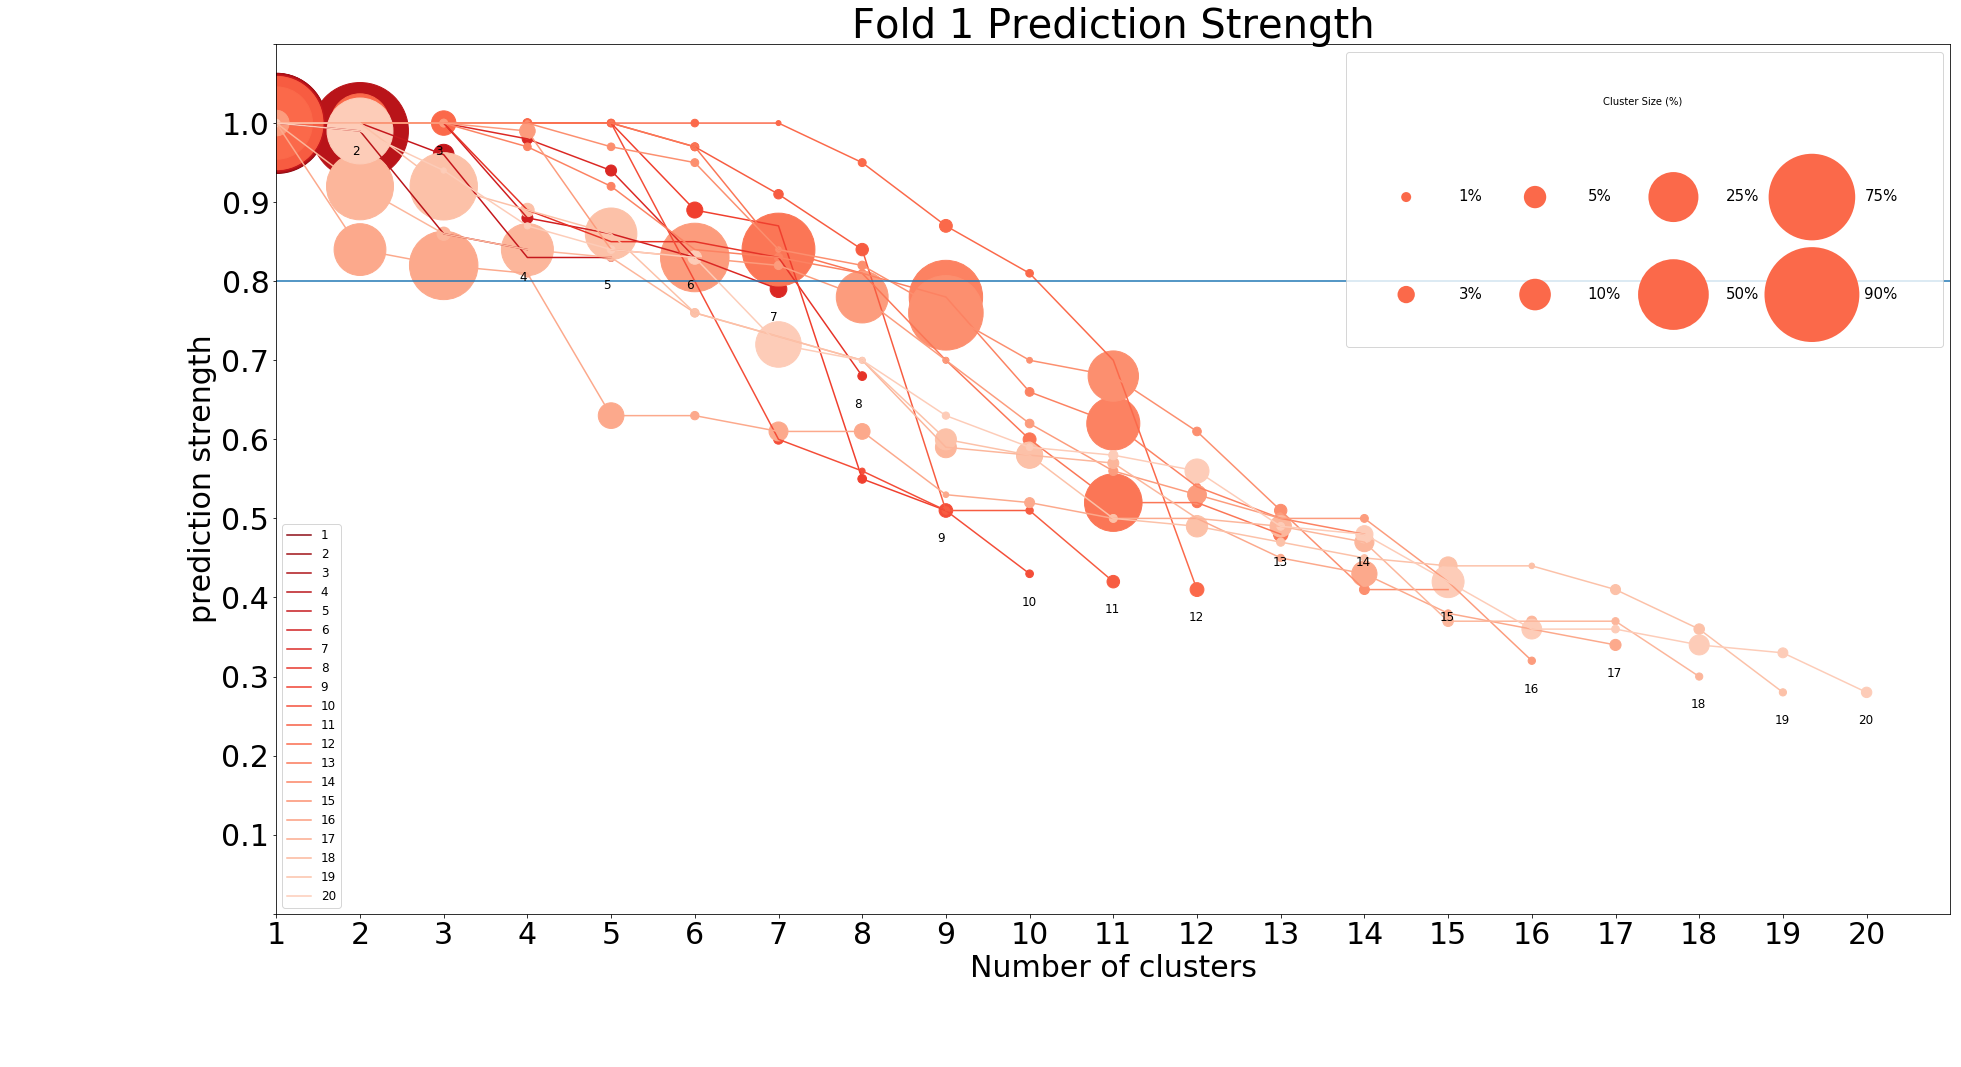

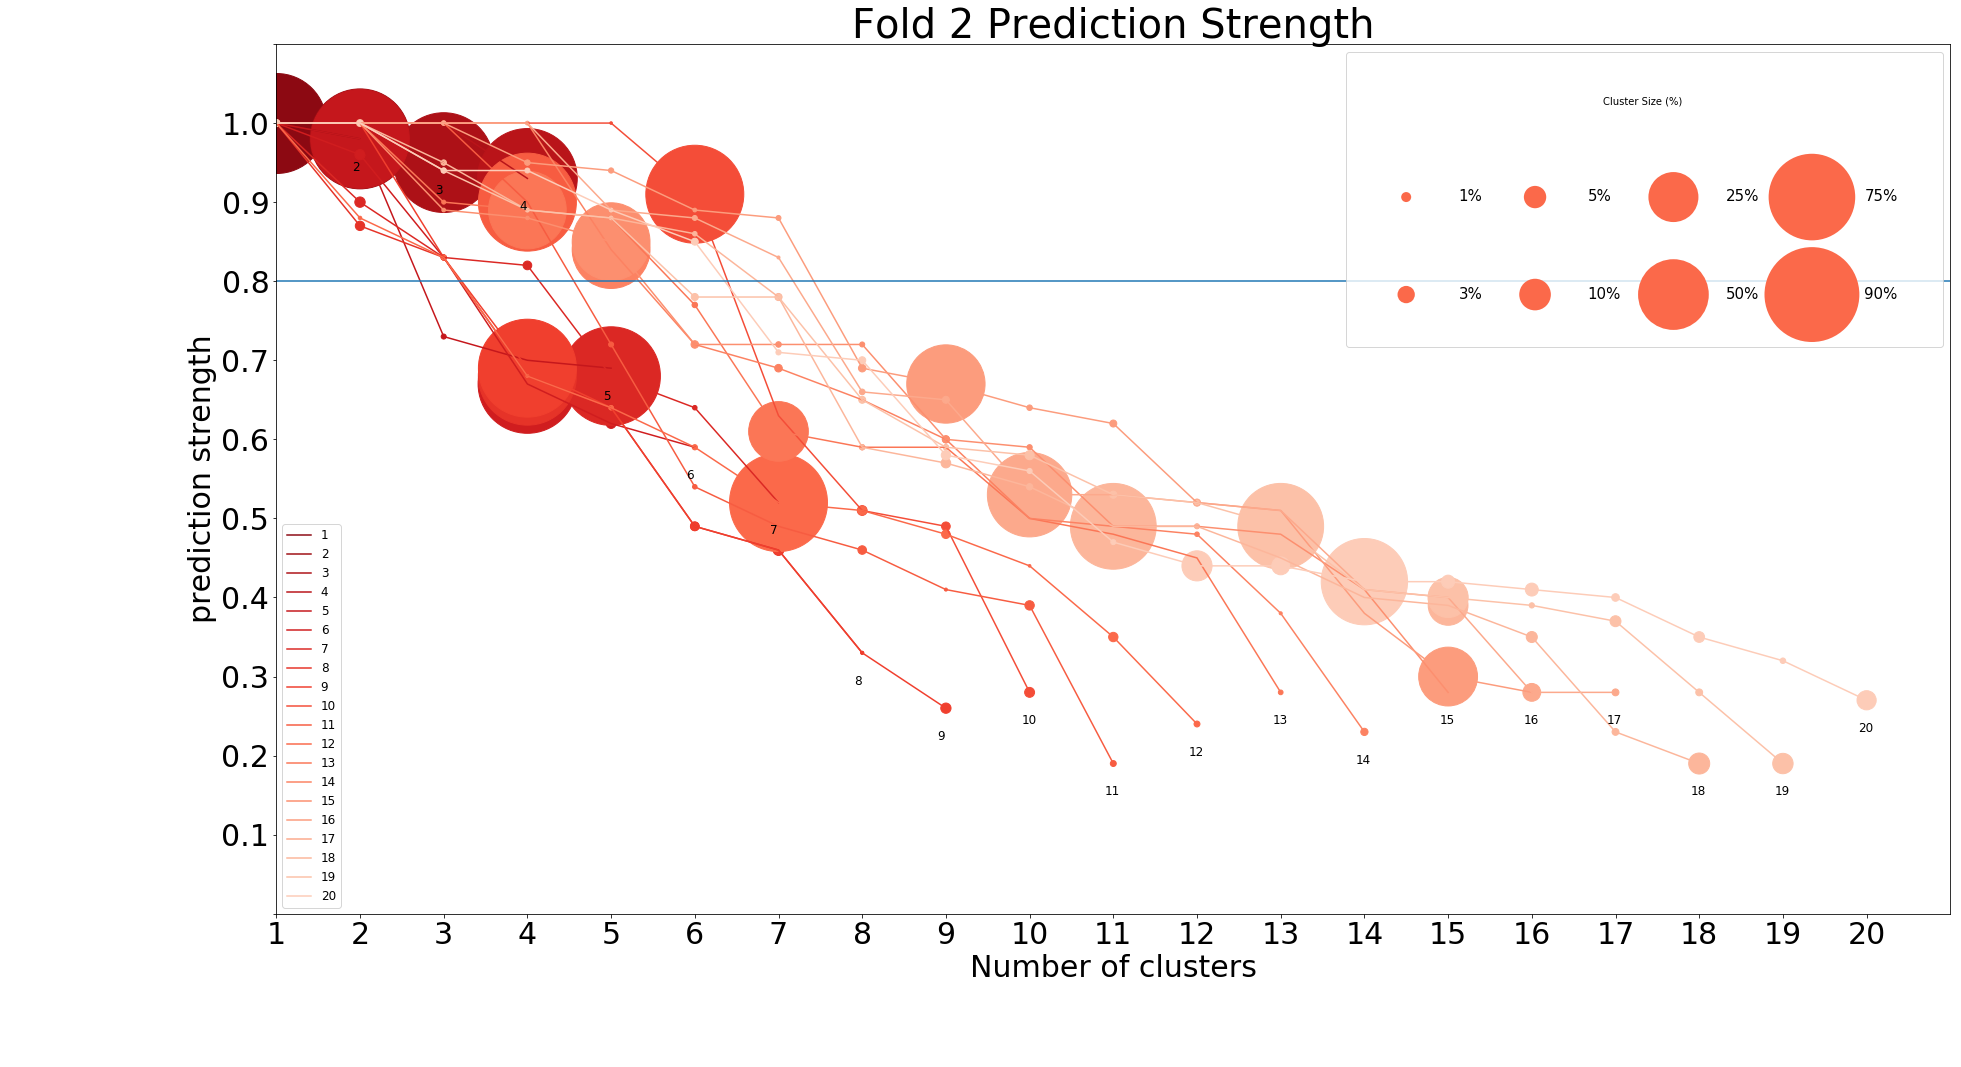

In [19]:
plot_prediction_strength(k_predictions_strength_cv,valid_cluster_size,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 2)

## Calculate proportion of Bursts from validation set falling into cluster with low prediction strength (below threshold of 0.8) per clustering with k clusters based on clusters found by spectral clustering.

In [96]:
def calculate_bad_cluster_sizes_cv(k_predictions_strength_cv, valid_cluster_size,valid_cluster_size_predicted, n_clusters = range(1,21), folds = 5, threshold = 0.8):
    """ Calculate proportion of datapoints from validation set falling into clusters with low prediction strength (below threshold = 0.8) per clustering with k clusters based on:
       a) clustres found by spectral clustering 
       b) clusters bound by centroid labeling based on training dataset

    Args:
        k_predictions_strength_cv (dict): Dictonary containig for each clustering with n_clusters the prediction strength for each cluster in each fold 
                                          keys = n_clusters  values = folds x n_clusters 
        valid_cluster_size (dict): containing for each clustering with n_cluster the cluster size of the separately clustered validation set for each fold
                                  keys = n_clusters  values = k_folds x size for each cluster 
        valid_cluster_size_predicted (dict): containing for each clustering with n_cluster the cluster size of the centroid assigned validation set clusters for each fold
                                             keys = n_clusters  values = k_folds x size for each cluster
        n_clusters (list): list number of k-clusters used in clustering 
        folds (int): number of folds used in cross validation 
        threshold (int): Prediction strength threshold indicating low prediction strength
    
    Returns:
        
        bad_cluster_sizes_cv (dict):  for each clustering with k_cluster proportion of datapoints from validation set falling into clusters with low prediction strength for each fold
                                      keys = n_clusters  values = k_folds x proportion of datapoints from validation set falling into clusters with low prediction strength

        bad_cluster_sizes_cv_predicted (dict):  for each labeling by k_cluster centroids based on training proportion of datapoints from validation set falling into clusters with low prediction strength for each fold
                                      keys = n_clusters  values = k_folds x proportion of datapoints from validation set falling into clusters with low prediction strength
    """

    bad_cluster_sizes_cv = {} 
    bad_cluster_sizes_cv_predicted = {}
    for i in n_clusters:
        bad_cluster_sizes_cv[i] = []
        bad_cluster_sizes_cv_predicted[i] = []

    for f in range(folds):
        for i in n_clusters:
            bad_cluster_idx = np.where(k_predictions_strength_cv[i][f] < threshold) #get index of cluster with prediction strength below 0.8
      
            #get proportion of burst in validation set falling into low predictive strength clusters for clustering with k clusters based on spectral cluster labels
            bad_cluster_sizes = (np.asarray((valid_cluster_size[i])[f]/np.sum(valid_cluster_size[i][f])) * 100)[bad_cluster_idx]  
        
            #get proportion of burst in validation set falling into low predictive strength clusters for clustering with k clusters based on centroid labels
            bad_cluster_sizes_predicted = (np.asarray((valid_cluster_size_predicted[i])[f]/np.sum(valid_cluster_size_predicted[i][f])) * 100)[bad_cluster_idx] # 
        
            bad_cluster_sizes_cv[i].append(list(bad_cluster_sizes))
            bad_cluster_sizes_cv_predicted[i].append(list(bad_cluster_sizes_predicted))
        
    return bad_cluster_sizes_cv, bad_cluster_sizes_cv_predicted

In [97]:
bad_cluster_sizes_cv, bad_cluster_sizes_cv_predicted = calculate_bad_cluster_sizes_cv(k_predictions_strength_cv, valid_cluster_size,valid_cluster_size_predicted,folds = 2)

In [98]:
def calculate_average_bad_cluster_sizes(bad_cluster_sizes_cv, bad_cluster_sizes_cv_predicted, n_clusters = range(1,21), folds = 5):
    """ Calculate average proportion of datapoints from validation set falling into clusters with low prediction strength (below threshold = 0.8) per clustering with k clusters based on:
       a) clustres found by spectral clustering 

    Args:
        bad_cluster_sizes_cv (dict):  for each clustering with k_cluster proportion of datapoints from validation set falling into clusters with low prediction strength for each fold
                                      keys = n_clusters  values = k_folds x proportion of datapoints from validation set falling into clusters with low prediction strength

        bad_cluster_sizes_cv_predicted (dict):  for each labeling by k_cluster centroids based on training proportion of datapoints from validation set falling into clusters with low prediction strength for each fold
                                      keys = n_clusters  values = k_folds x proportion of datapoints from validation set falling into clusters with low prediction strength
        n_clusters (list): list number of k-clusters used in clustering 
        folds (int): number of folds used in cross validation 
    
    Returns:
        
        average_bad_cluster_size (dict):  for each clustering with k_cluster proportion of datapoints from validation set falling into clusters with low prediction strength averaged by folds
                                      keys = n_clusters  values = k_folds x proportion of datapoints from validation set falling into clusters with low prediction strength

        average_bad_cluster_size_predicted (dict):  for each labeling by k_cluster centroids based on training proportion of datapoints from validation set falling into clusters with low prediction strength averaged by folds
                                      keys = n_clusters  values = k_folds x proportion of datapoints from validation set falling into clusters with low prediction strength
    """



    average_bad_cluster_size = []
    average_bad_cluster_size_predicted = []

    for i in n_clusters:
        bad_cluster_fold_sum = np.sum(sum(bad_cluster_sizes_cv[i],[]))
        bad_cluster_fold_sum_predicted = np.sum(sum(bad_cluster_sizes_cv_predicted[i],[]))

        average_bad_cluster_size.append(bad_cluster_fold_sum/folds)
        average_bad_cluster_size_predicted.append(bad_cluster_fold_sum_predicted/folds)
        
    return average_bad_cluster_size, average_bad_cluster_size_predicted

In [99]:
average_bad_cluster_size, average_bad_cluster_size_predicted = calculate_average_bad_cluster_sizes(bad_cluster_sizes_cv, bad_cluster_sizes_cv_predicted,folds = 2)

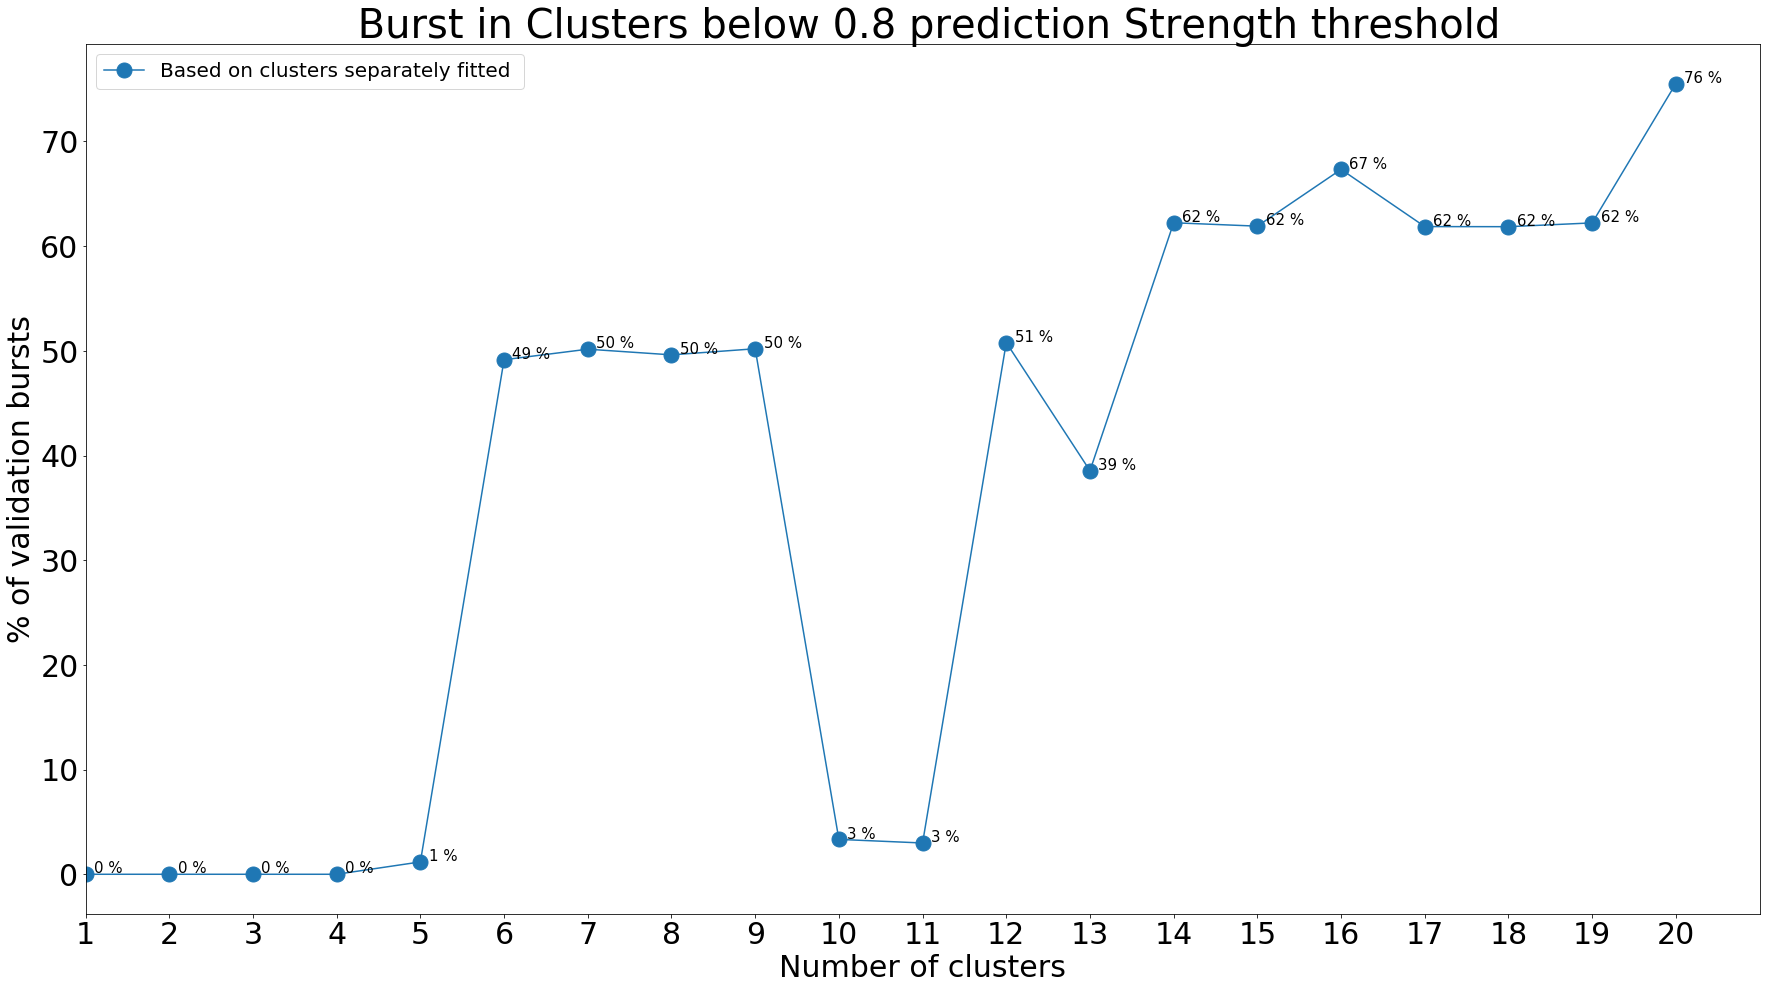

In [100]:
plot_average_proportion_of_bursts_in_low_clusters_per_k(average_bad_cluster_size, average_bad_cluster_size_predicted, n_cluster = range(1,21))

In [101]:
bad_cluster_size_fold = []
bad_cluster_size_predicted_fold = []

for f in range(2):
    bad_cluster_size_f = []
    bad_cluster_size_predicted_f = []
    for i in range(1,21):
        bad_cluster_fold_sum = np.sum(bad_cluster_sizes_cv[i][f])
        bad_cluster_fold_sum_predicted = np.sum(bad_cluster_sizes_cv_predicted[i][f])

        bad_cluster_size_f.append(bad_cluster_fold_sum)
        bad_cluster_size_predicted_f.append(bad_cluster_fold_sum_predicted)
    bad_cluster_size_fold.append(bad_cluster_size_f)
    bad_cluster_size_predicted_fold.append(bad_cluster_size_predicted_f)

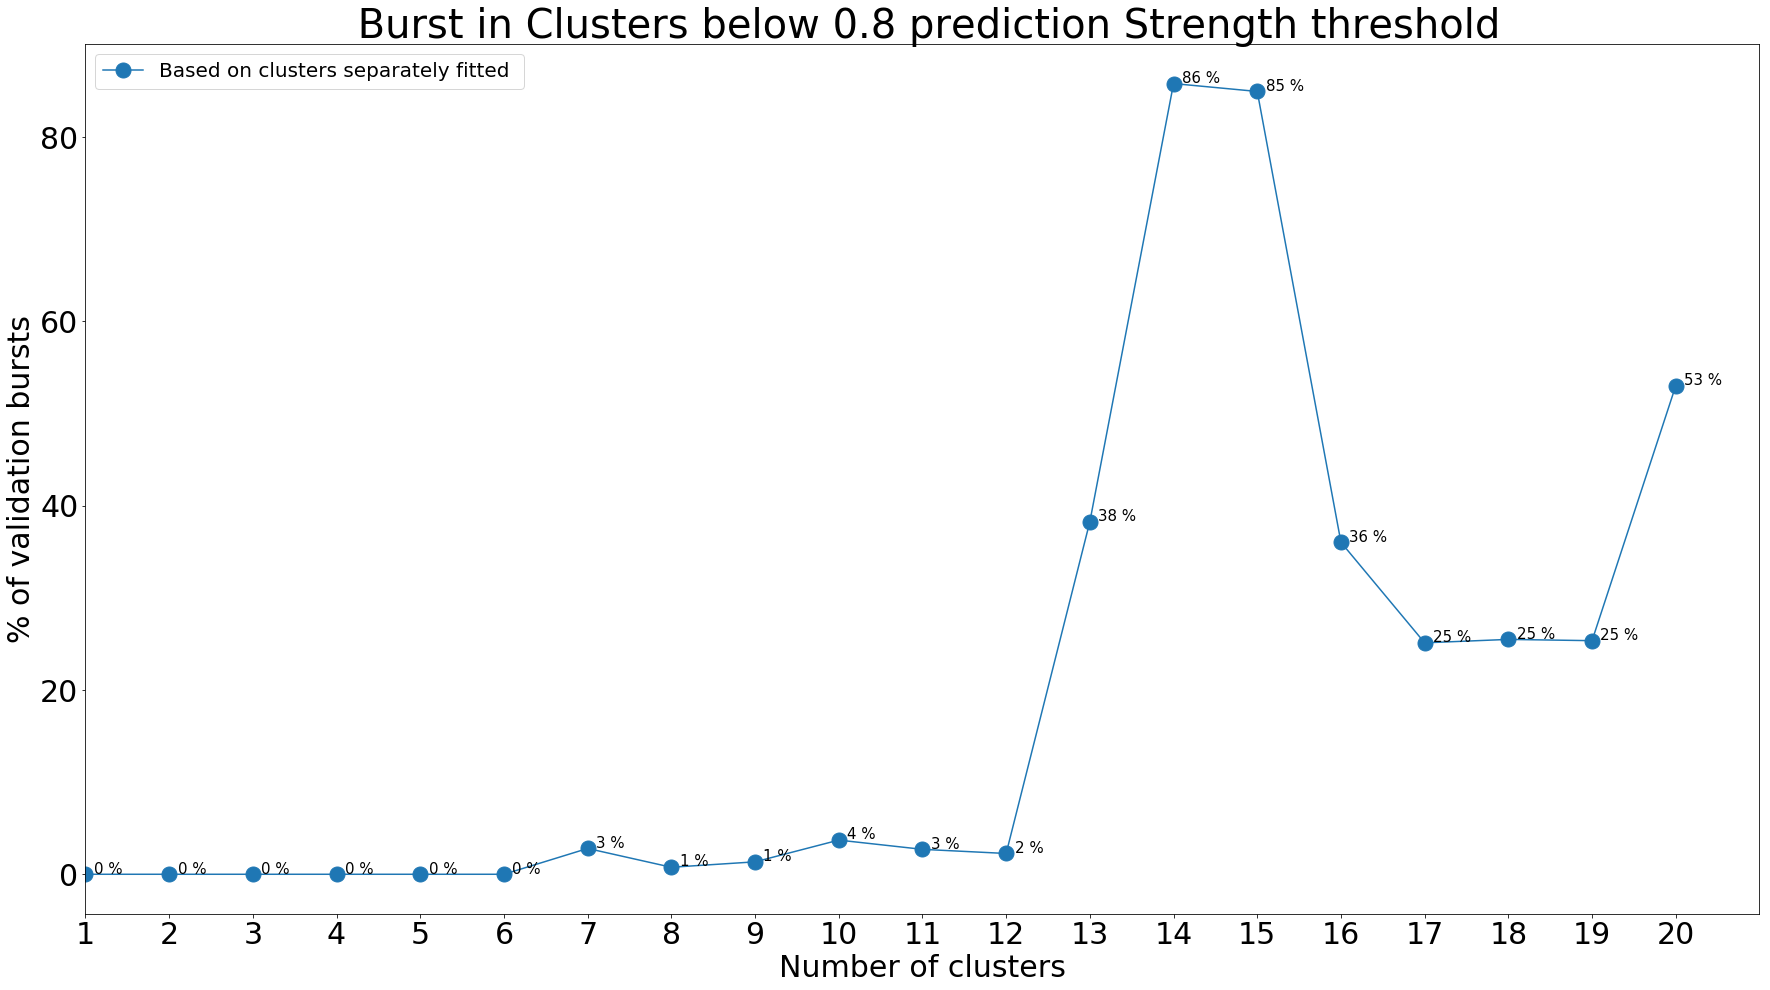

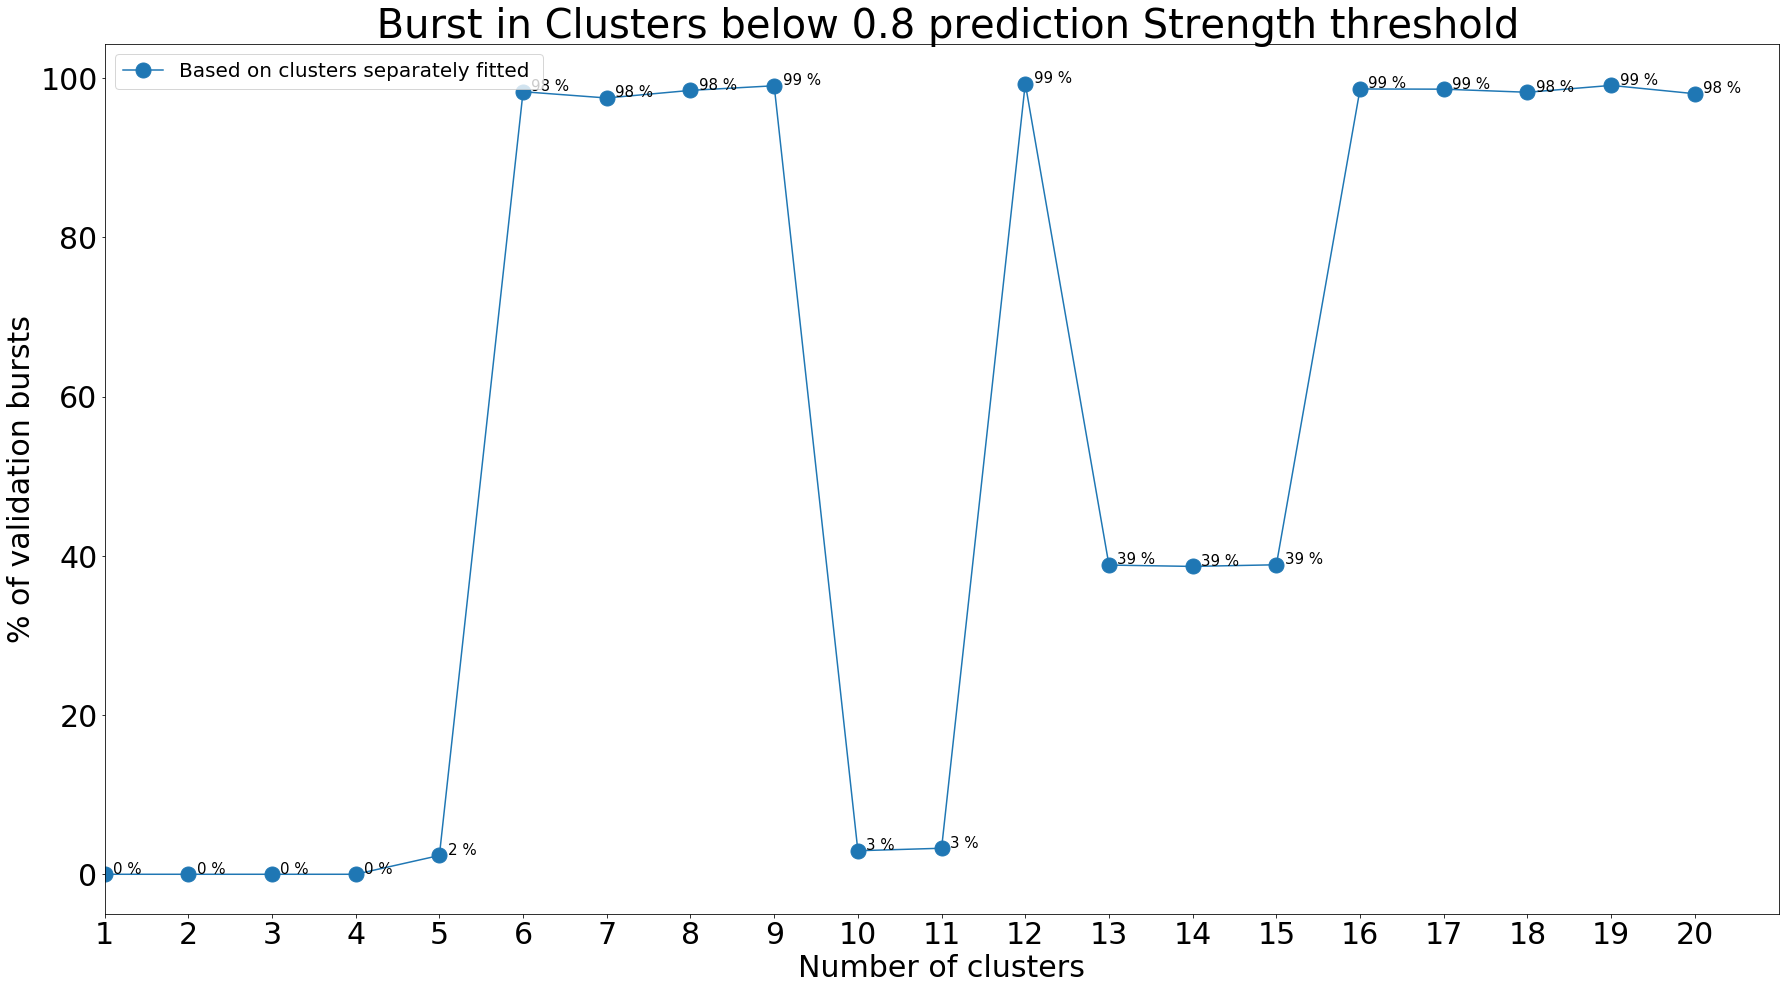

In [102]:
for i in range(2):
    plot_average_proportion_of_bursts_in_low_clusters_per_k(bad_cluster_size_fold[i], bad_cluster_size_predicted_fold[i], n_cluster = range(1,21))

### Plot cluster examples

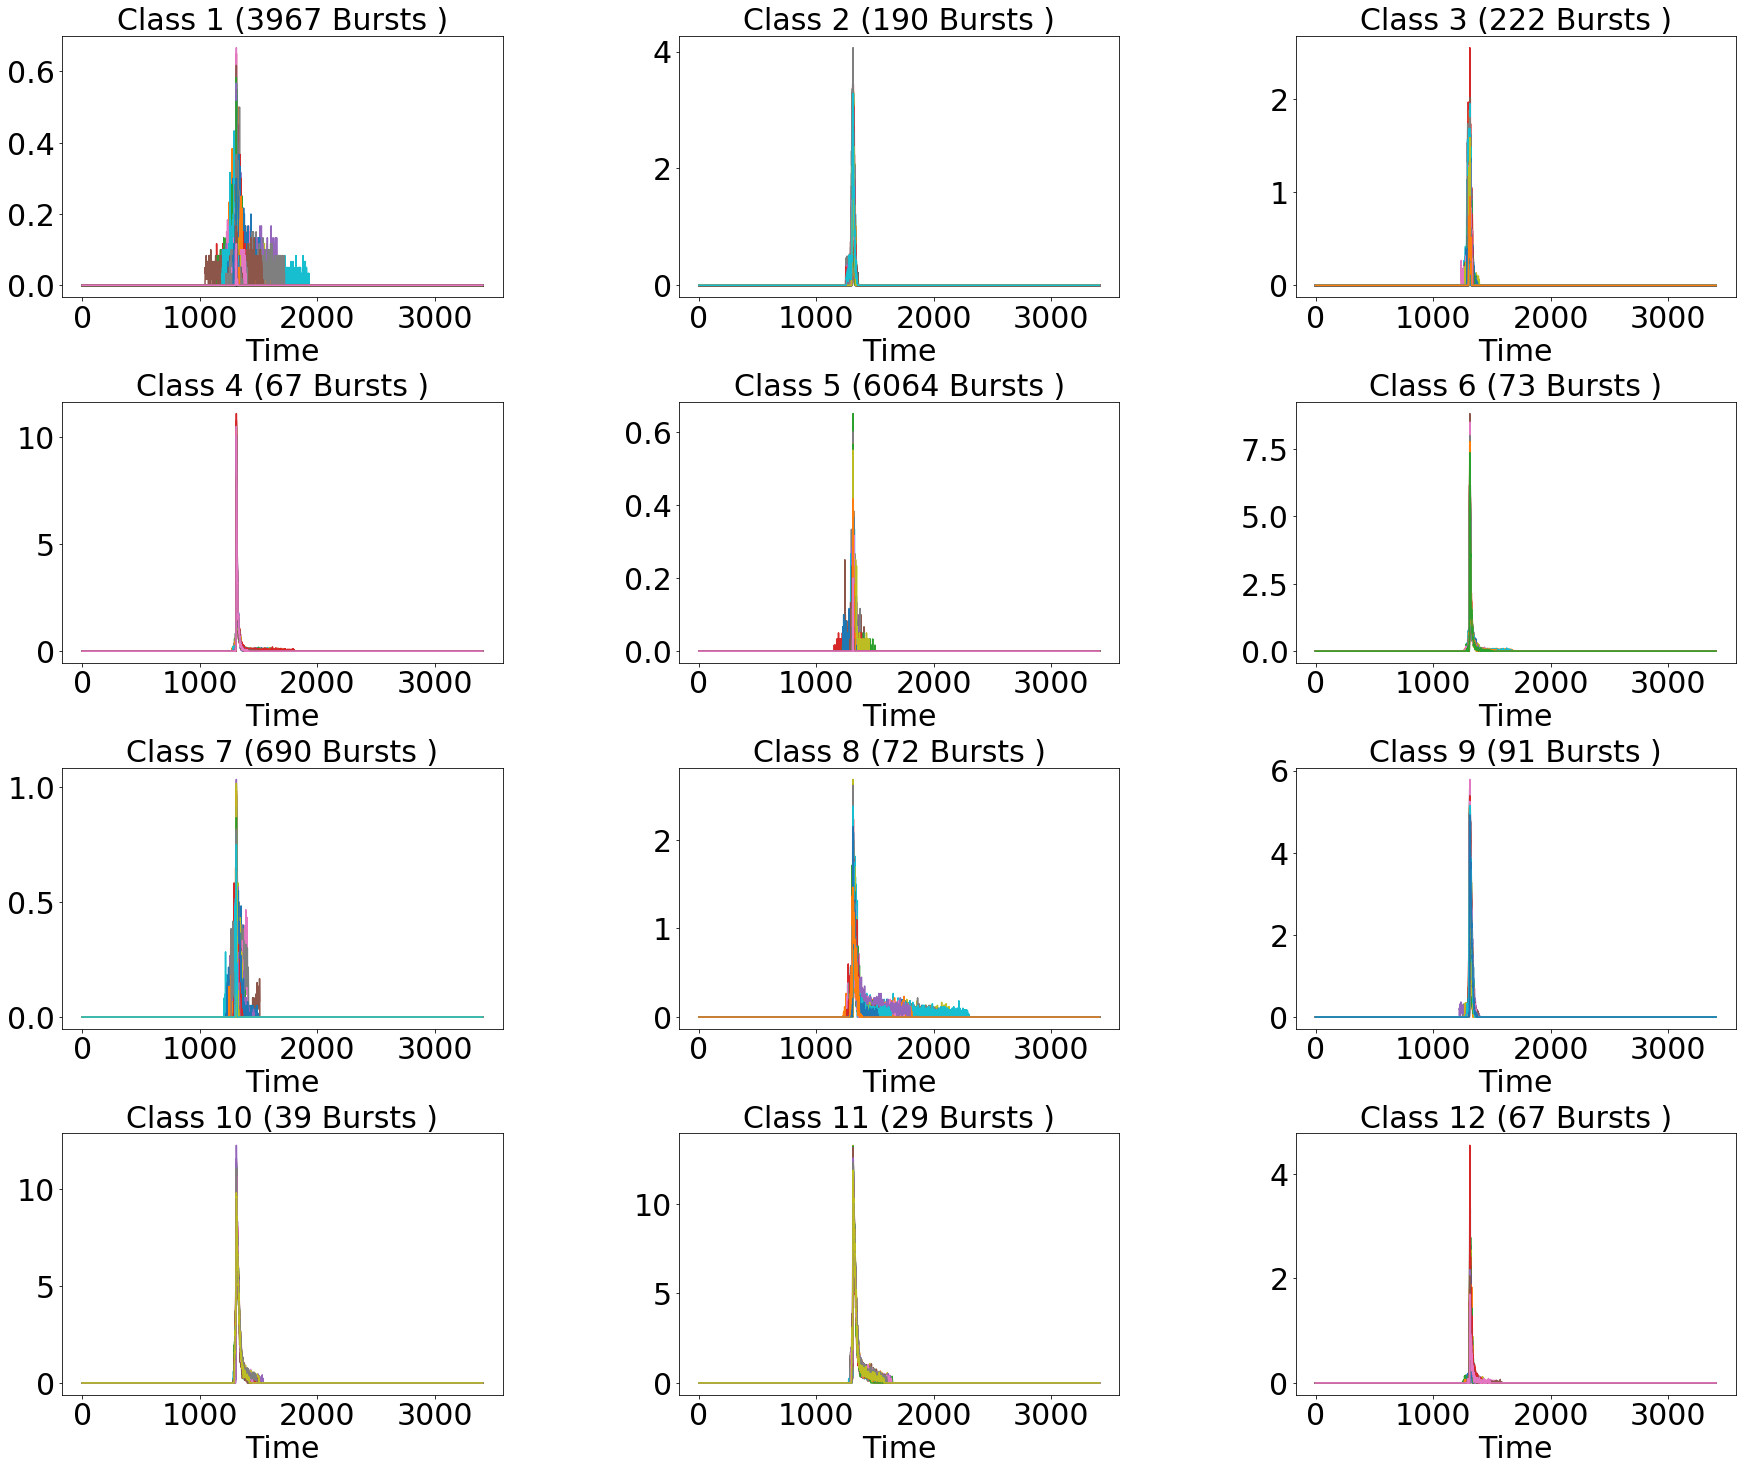

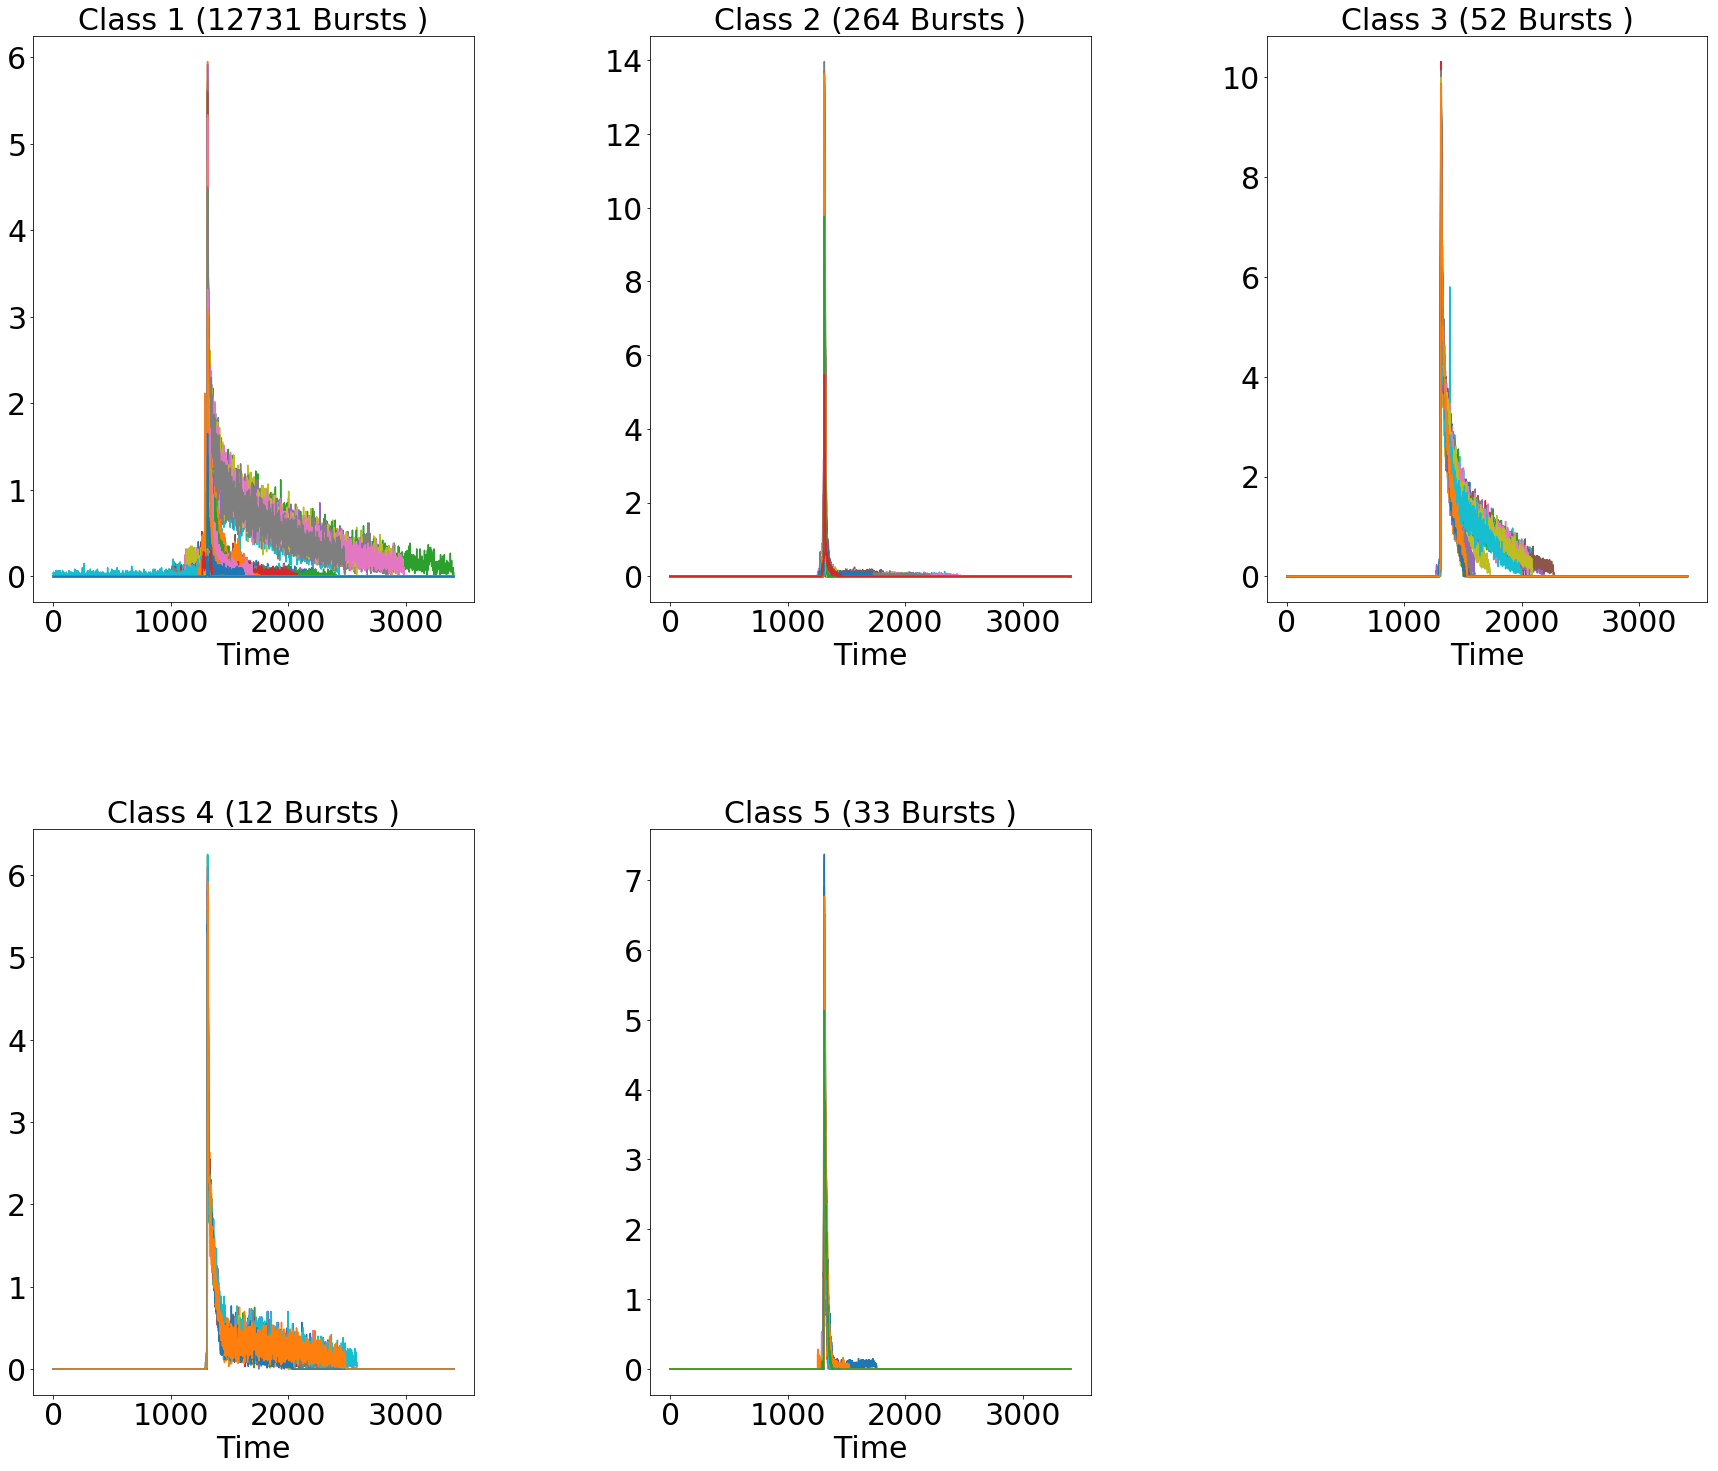

In [116]:
k_clusters_fold = [12,5]
for i,validation_set in enumerate(validation_sets):
    k_clusters = k_clusters_fold[i]
    plot_cluster_examples(validation_set, valid_fold_labels[i][k_clusters-1], k_clusters)

## Calculate number of Bursts from validation set with low individual prediction strength (below threshold of 0.8) per clustering with k clusters based on clusters found by spectral clustering.

In [20]:
def get_low_individual_ps_bursts(data, train_folds, valid_folds, train_fold_labels, valid_fold_labels ,predictions_strengths_cv_per_samples, n_clusters = range(1,21), threshold = 0.8):
    """ extract burst indices for burst with low individual prediction strength for clustering with k clusters per cluster
    Args:
        data (nd.array): Array containing data (n x m)
        train_folds (list of nd.arrays): list of k training set indices each with dimension n-(n/k) x m
        valid_folds (list of nd.arrays): list of k validation set indices each with dimension n/k x m
        train_fold_labels (list of lists): list of lists containing the cluster labels for each point in training set
        valid_fold_labels (list of lists): list of lists containing the cluster labels for each point in validation set
        predictions_strengths_cv_per_samples(list of lists): list of lists containin the prediction strength for individual bursts in each cluster by clustering with k clusters for each folds 
                                                             1. dim n-folds 2.dim n-clusters 3.dim prediction strength for each cluster i in clustering with k clusters 
        n_clusters (nd.array): range of clusters to use for clustering
        n_folds (int): number of folds the data is splitted 
        threshold (float): cutoff for defining low individual prediction strength                                                    
    
    Returns:
        k_low_individual_ps_cv (list of lists): list of lists containin the burst indices for bursts with individual ps below threshold  strength for individual bursts in each cluster by clustering with k clusters for each folds 
                                                keys = n_clusters  values = k_folds x n_clusters (burst indices of bursts from validation set with individual ps below threshold for each cluster) 
    
    """     
    
    
    k_low_individual_ps_cv = {}
    k_low_individual_ps_cv_sizes = {}
    k_low_individual_ps_cv_sizes_prop = {}
    
    for i in n_clusters: # for each clustering ranging from 1 to max n_clusters 
        k_low_individual_ps_cv[i] = []
        k_low_individual_ps_cv_sizes[i] = []
        k_low_individual_ps_cv_sizes_prop[i] = []
    
    for f, fold in enumerate(predictions_strengths_cv_per_samples): # for each fold
        train_fold = train_folds[f] # training set for fold k splitting
        valid_fold = valid_folds[f] # validation set for fold k splitting
        
        train_labels = train_fold_labels[f] # labels for training set  
        valid_labels = valid_fold_labels[f] # labels for validation set 
        
        for j,k in enumerate(fold): # for each clustering j with k clusters prediction strenght of fold 
            train_labels_k = train_labels[j] 
            valid_labels_k = valid_labels[j]
            
            #print(j, len(train_labels_k),len(valid_labels_k))
            
            k_low_individual_ps_cv_k = []
            k_low_individual_ps_cv_sizes_k = []
            k_low_individual_ps_cv_sizes_prop_k = []
            
            #print(len(np.concatenate(predictions_strengths_cv_per_samples[f][j])))
            
            for i in range(j+1):
                index_in_class = np.where(np.asarray(predictions_strengths_cv_per_samples[f][j][i]) < threshold) #get position relative to class 
                low_predictive_bursts = valid_fold[np.where(valid_labels_k == i)[0][index_in_class]]
                
                k_low_individual_ps_cv_k.append(low_predictive_bursts) #get burst indices relative to overall data
                k_low_individual_ps_cv_sizes_k.append(len(low_predictive_bursts))
                k_low_individual_ps_cv_sizes_prop_k.append(len(low_predictive_bursts)/len(valid_fold[np.where(valid_labels_k == i)[0]]))
            
            k_low_individual_ps_cv[j+1].append(k_low_individual_ps_cv_k)
            k_low_individual_ps_cv_sizes[j+1].append(k_low_individual_ps_cv_sizes_k)
            k_low_individual_ps_cv_sizes_prop[j+1].append(k_low_individual_ps_cv_sizes_prop_k)
            
            
            
    return  k_low_individual_ps_cv,k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop        

In [42]:
threshold = 0.9
k_low_individual_ps_bursts, k_low_individual_ps_cv_sizes,k_low_individual_ps_cv_sizes_prop = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels, valid_fold_labels ,predictions_strengths_cv_per_sample,threshold = threshold)

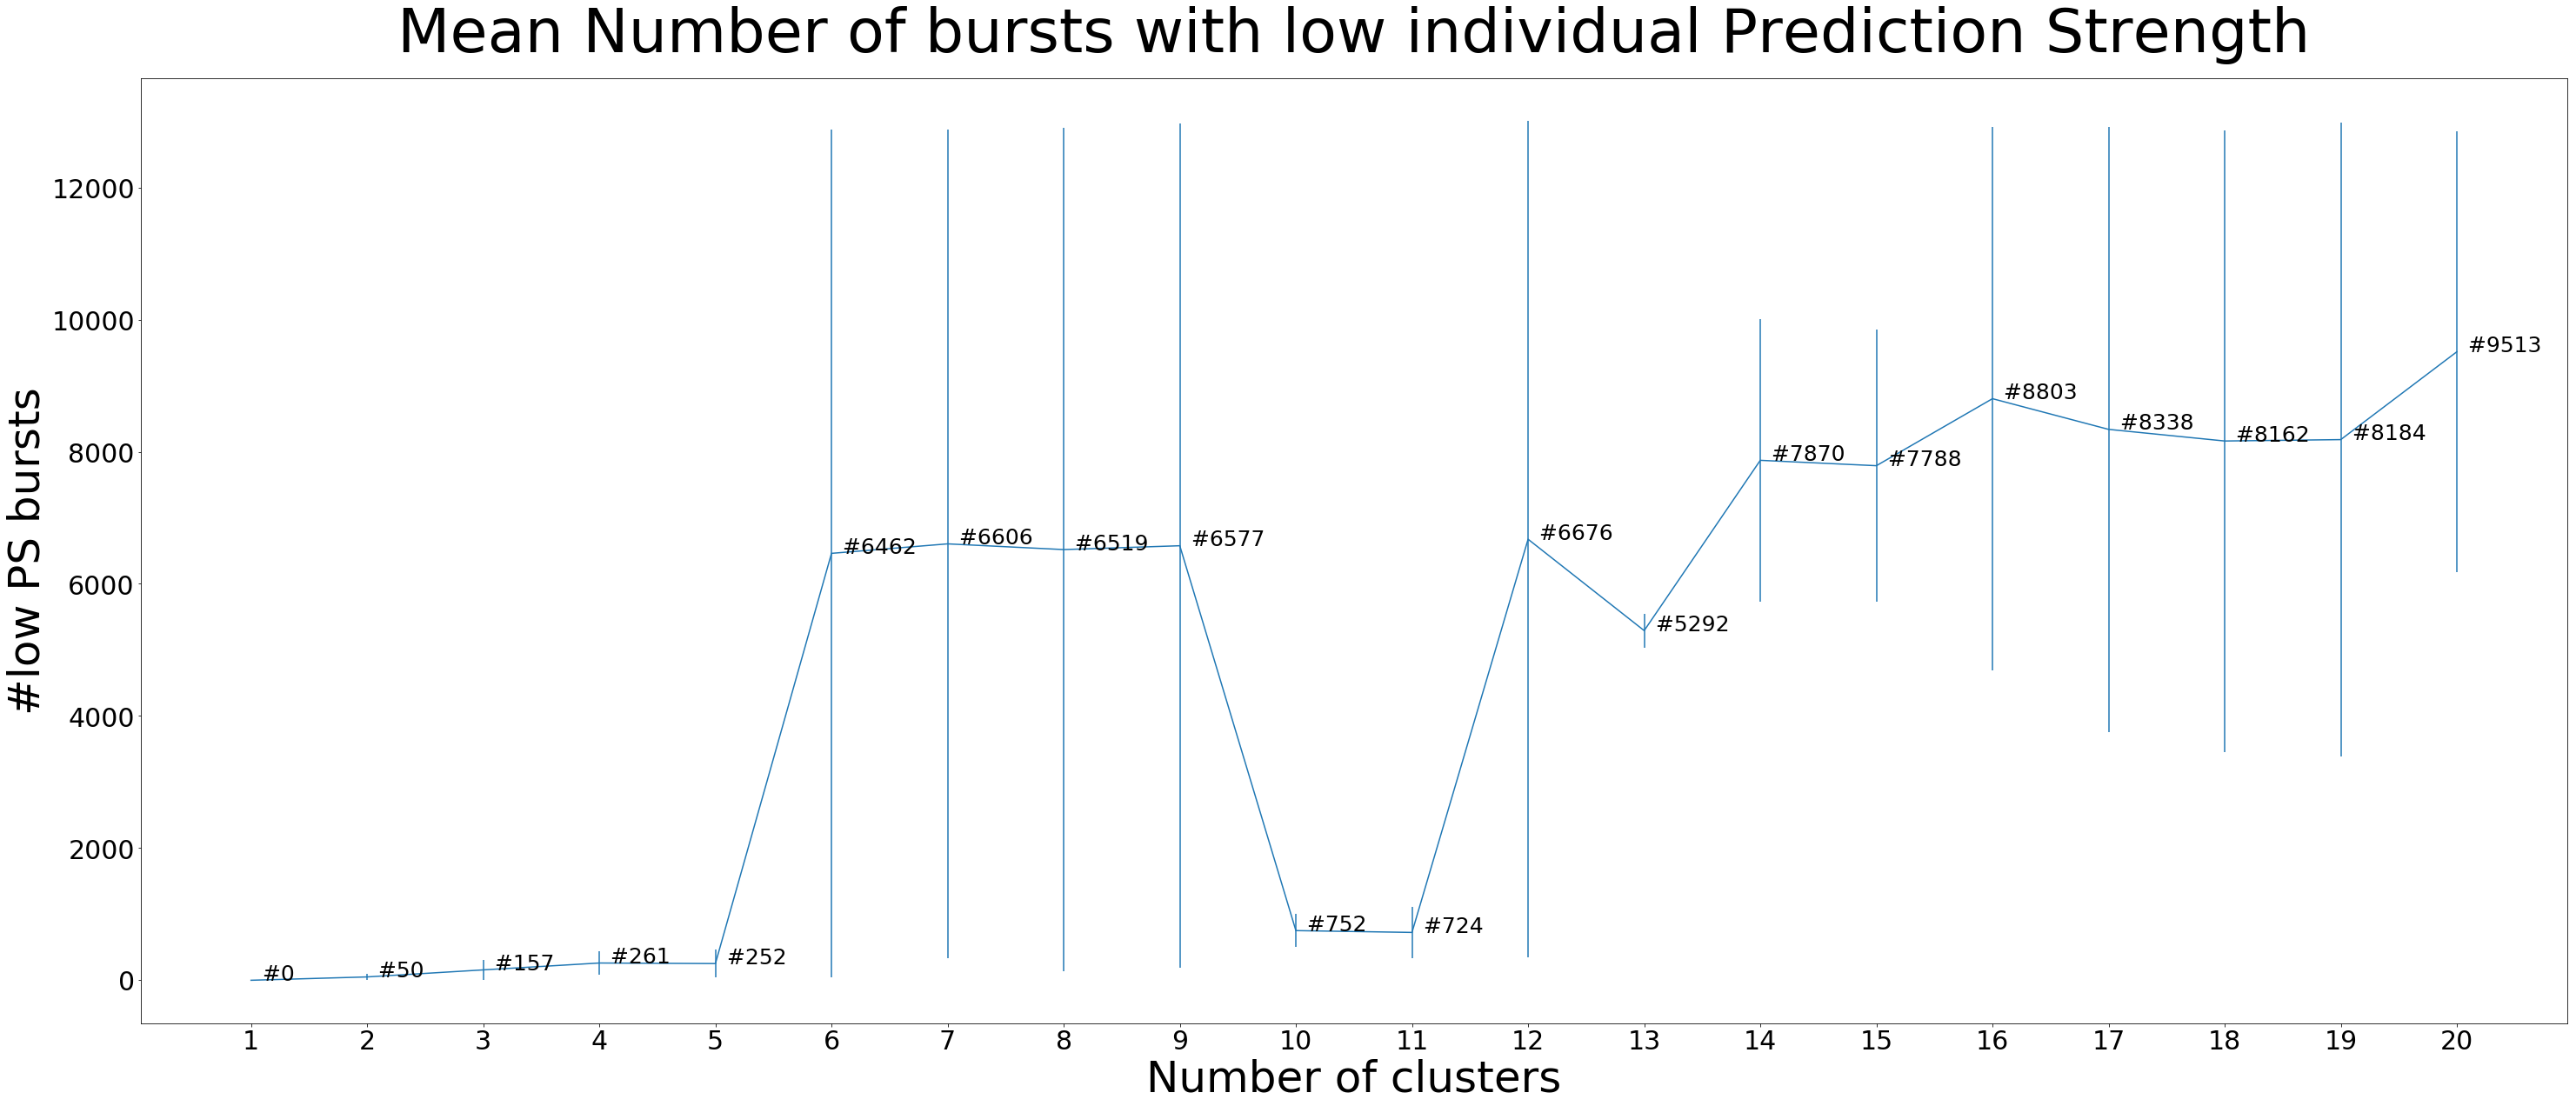

In [43]:
plot_mean_number_of_low_prediction_strength_samples(k_low_individual_ps_cv_sizes,n_clusters = range(1,21))

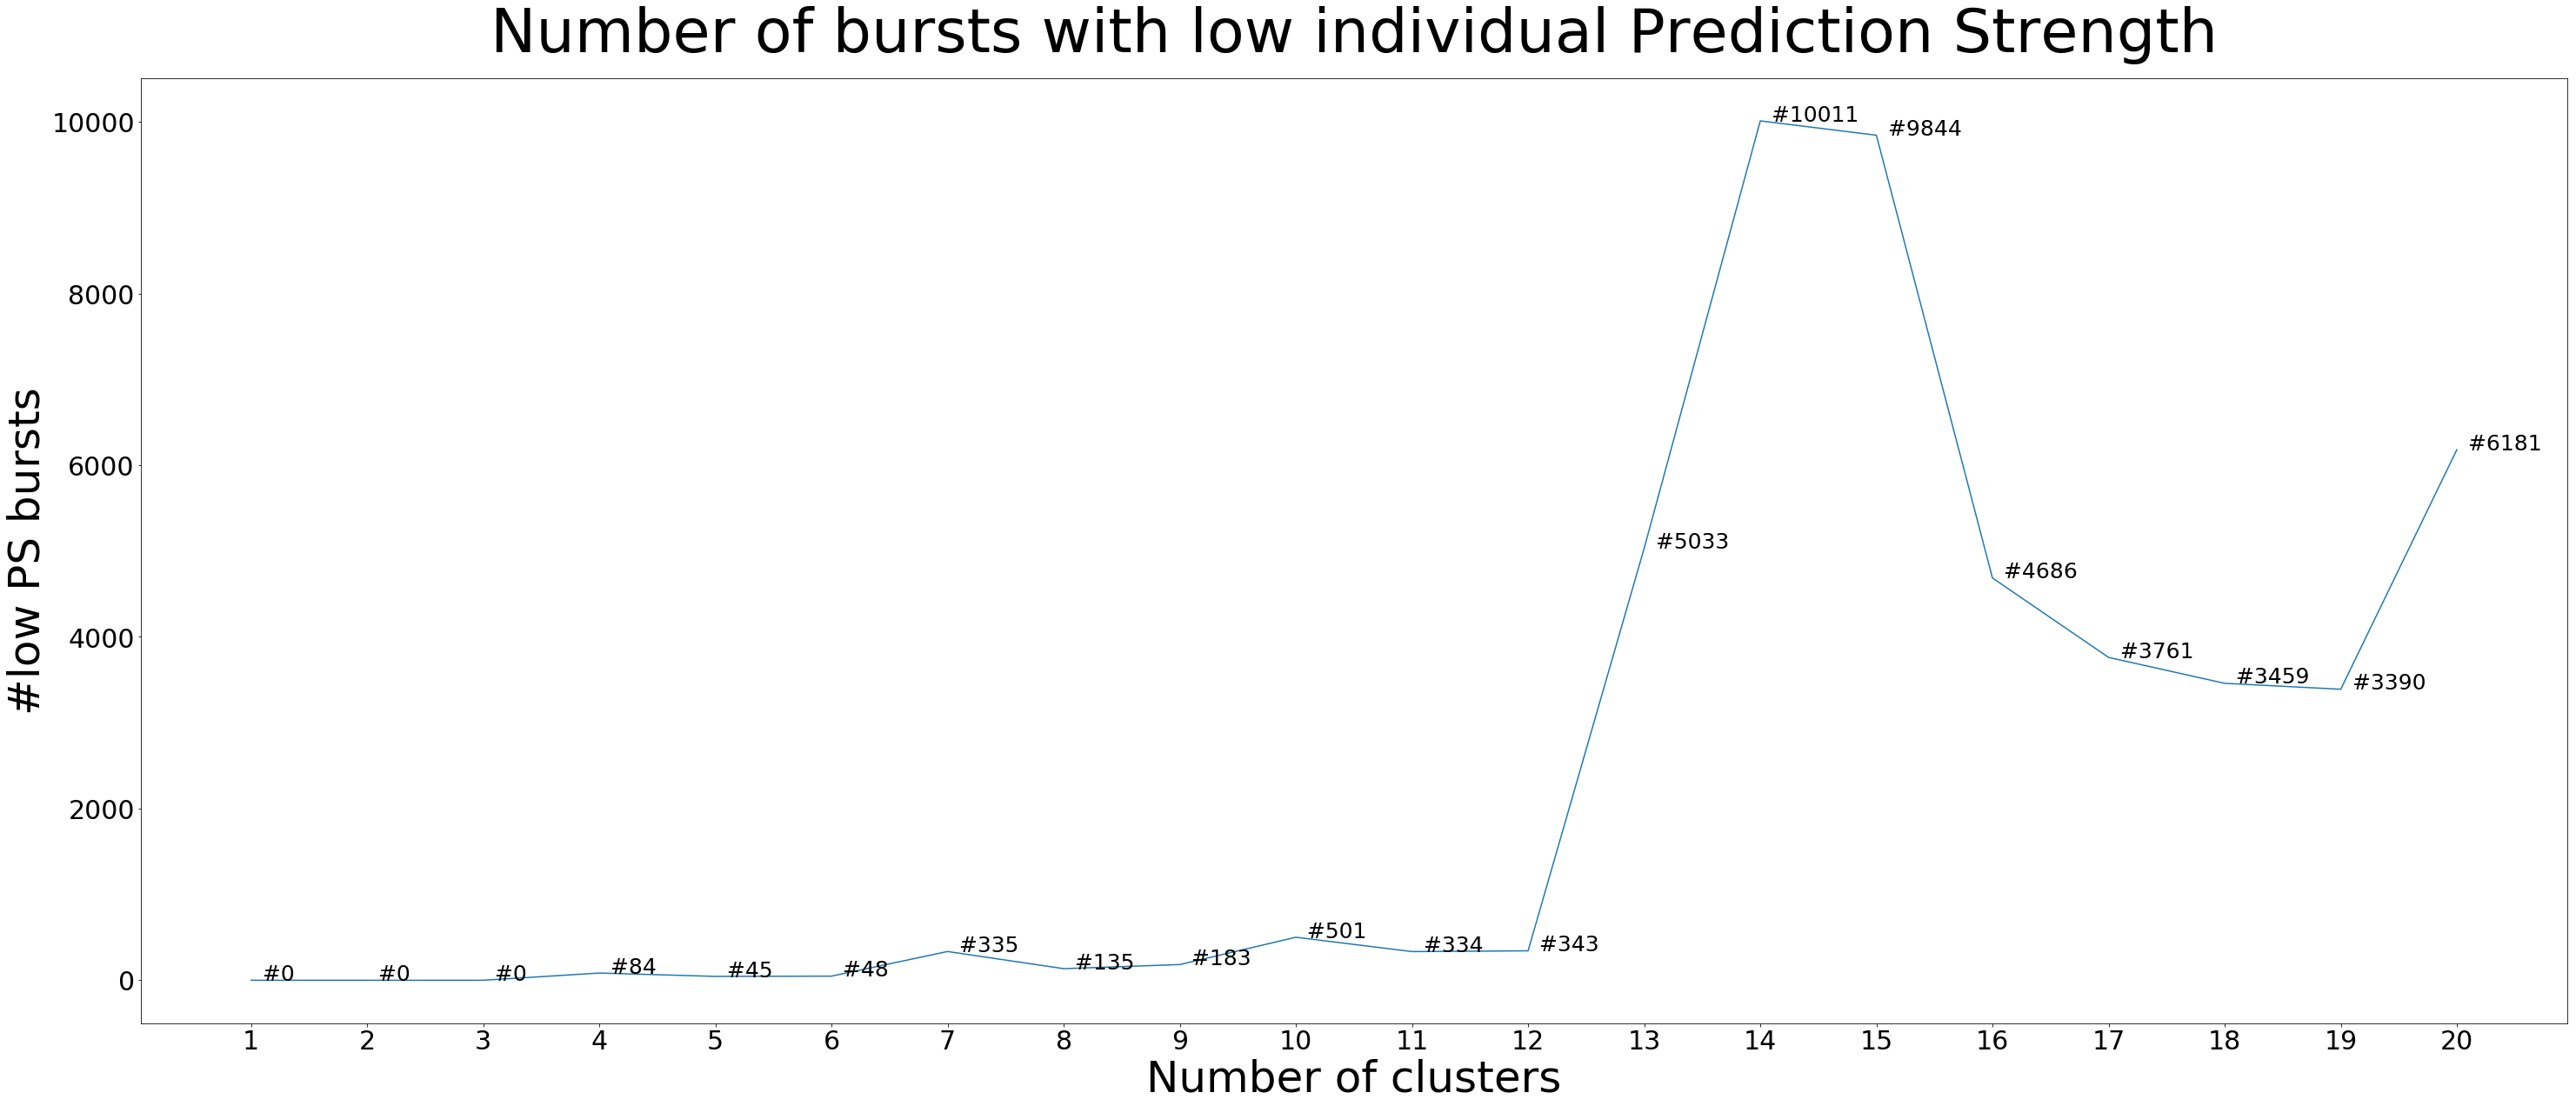

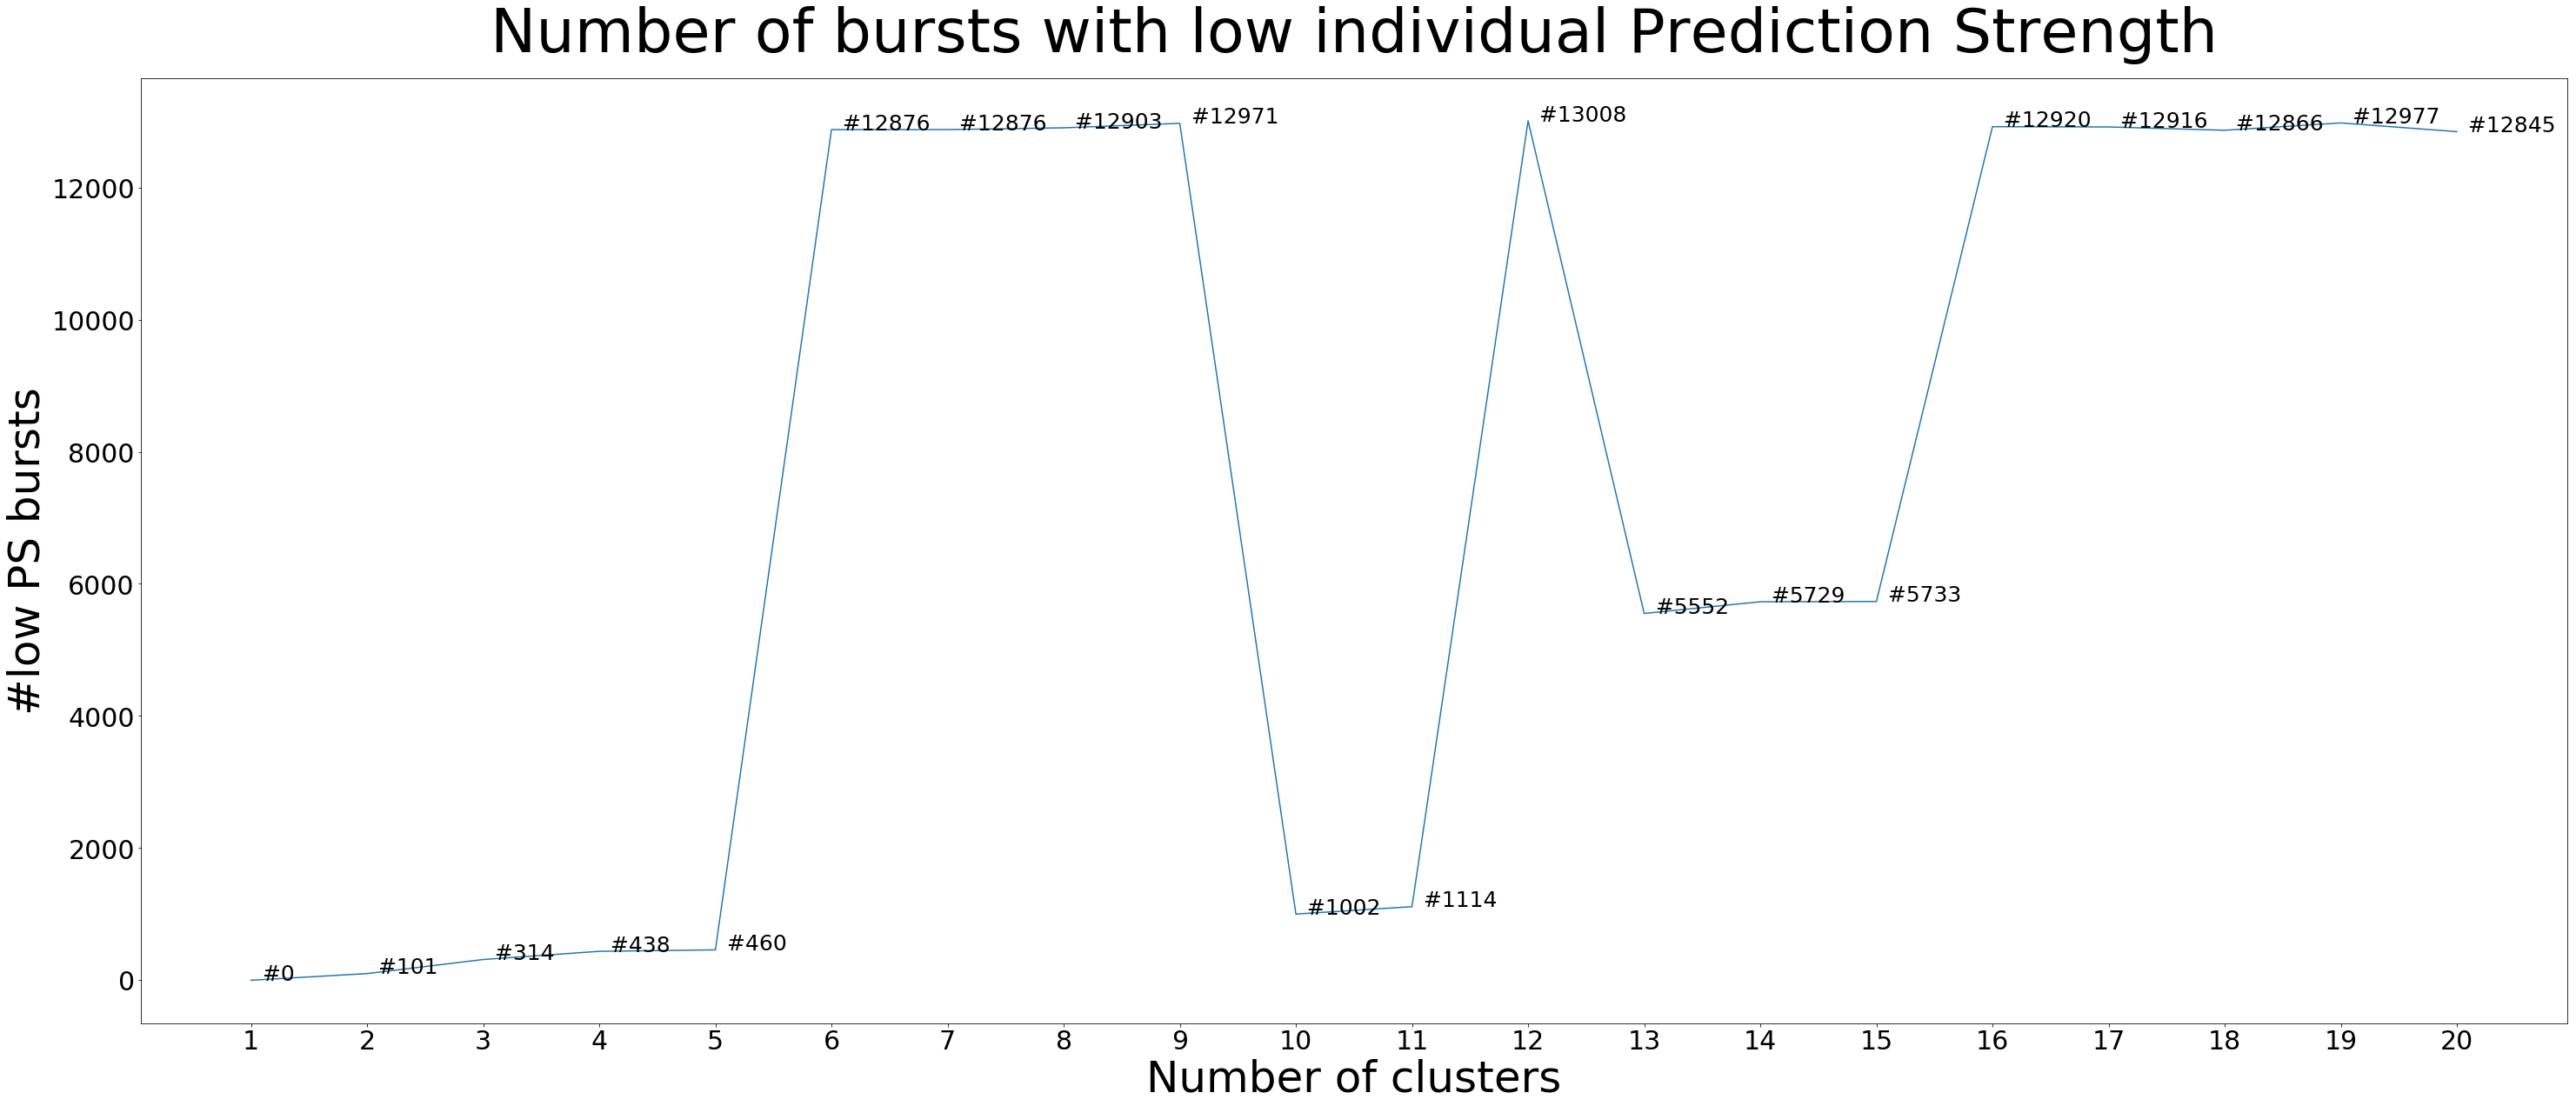

In [44]:
n_folds = 2
threshold = 0.9
n_cluster = range(1,21)

for i in range(n_folds):
    fold_i_low_bursts,fold_i_low_burst_sizes,fold_i_low_burst_sizes_prop = get_low_individual_ps_bursts(data,[train_folds[i]], [valid_folds[i]], [train_fold_labels[i]], [valid_fold_labels[i]] ,[predictions_strengths_cv_per_sample[i]],threshold = threshold)
    plot_mean_number_of_low_prediction_strength_samples(fold_i_low_burst_sizes, n_clusters = n_cluster)

### plot bursts with low and high prediction strength for each cluster 

In [32]:
def get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = 2,n_clusters = range(1,21)):
    k_low_ps_bursts_folds = {}
    k_high_ps_bursts_folds = {}
    low_ps_bursts_fold_labels = []
    high_ps_bursts_fold_labels = []
    
    for k in n_clusters:
        k_low_ps_bursts_folds[k] = [np.concatenate(k_low_individual_ps_bursts[k][f],axis=None) for f in range(n_folds)]
        high_ps_bursts_folds_k = [list(valid_fold) for valid_fold in valid_folds]
        for f in range(n_folds):
            for idx in k_low_ps_bursts_folds[k][f]:  
                high_ps_bursts_folds_k[f].remove(idx)
        k_high_ps_bursts_folds[k] = high_ps_bursts_folds_k
        
    
    for f in range(n_folds):
        low_ps_bursts_labels_f = []
        high_ps_bursts_labels_f = []
        for k in n_clusters:
            high_ps_bursts_labels_f_k = valid_fold_labels[f][k-1]
            remove_label_idx = []
            low_ps_bursts_labels_f_k = []
            for key in range(k):
                low_ps_bursts_labels_f_k += list(np.repeat(key,k_low_individual_ps_cv_sizes[k][f][key]))
            low_ps_bursts_labels_f.append(np.asarray(low_ps_bursts_labels_f_k))
            for idx in k_low_ps_bursts_folds[k][f]:
                remove_label_idx.append(np.where(valid_folds[f] == idx)[0][0])
            
            high_ps_bursts_labels_f_k = np.delete(high_ps_bursts_labels_f_k,remove_label_idx) 
            high_ps_bursts_labels_f.append(np.asarray(high_ps_bursts_labels_f_k))
            
        low_ps_bursts_fold_labels.append(np.asarray(low_ps_bursts_labels_f))
        high_ps_bursts_fold_labels.append(np.asarray(high_ps_bursts_labels_f))
        
    return k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels

In [45]:
k_high_ps_bursts_folds, high_ps_bursts_fold_labels, k_low_ps_bursts_folds, low_ps_bursts_fold_labels = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels,k_low_individual_ps_bursts,k_low_individual_ps_cv_sizes, n_folds = 2,n_clusters = range(1,21))

In [165]:
len(np.unique(high_ps_bursts_fold_labels[0][10]))

9

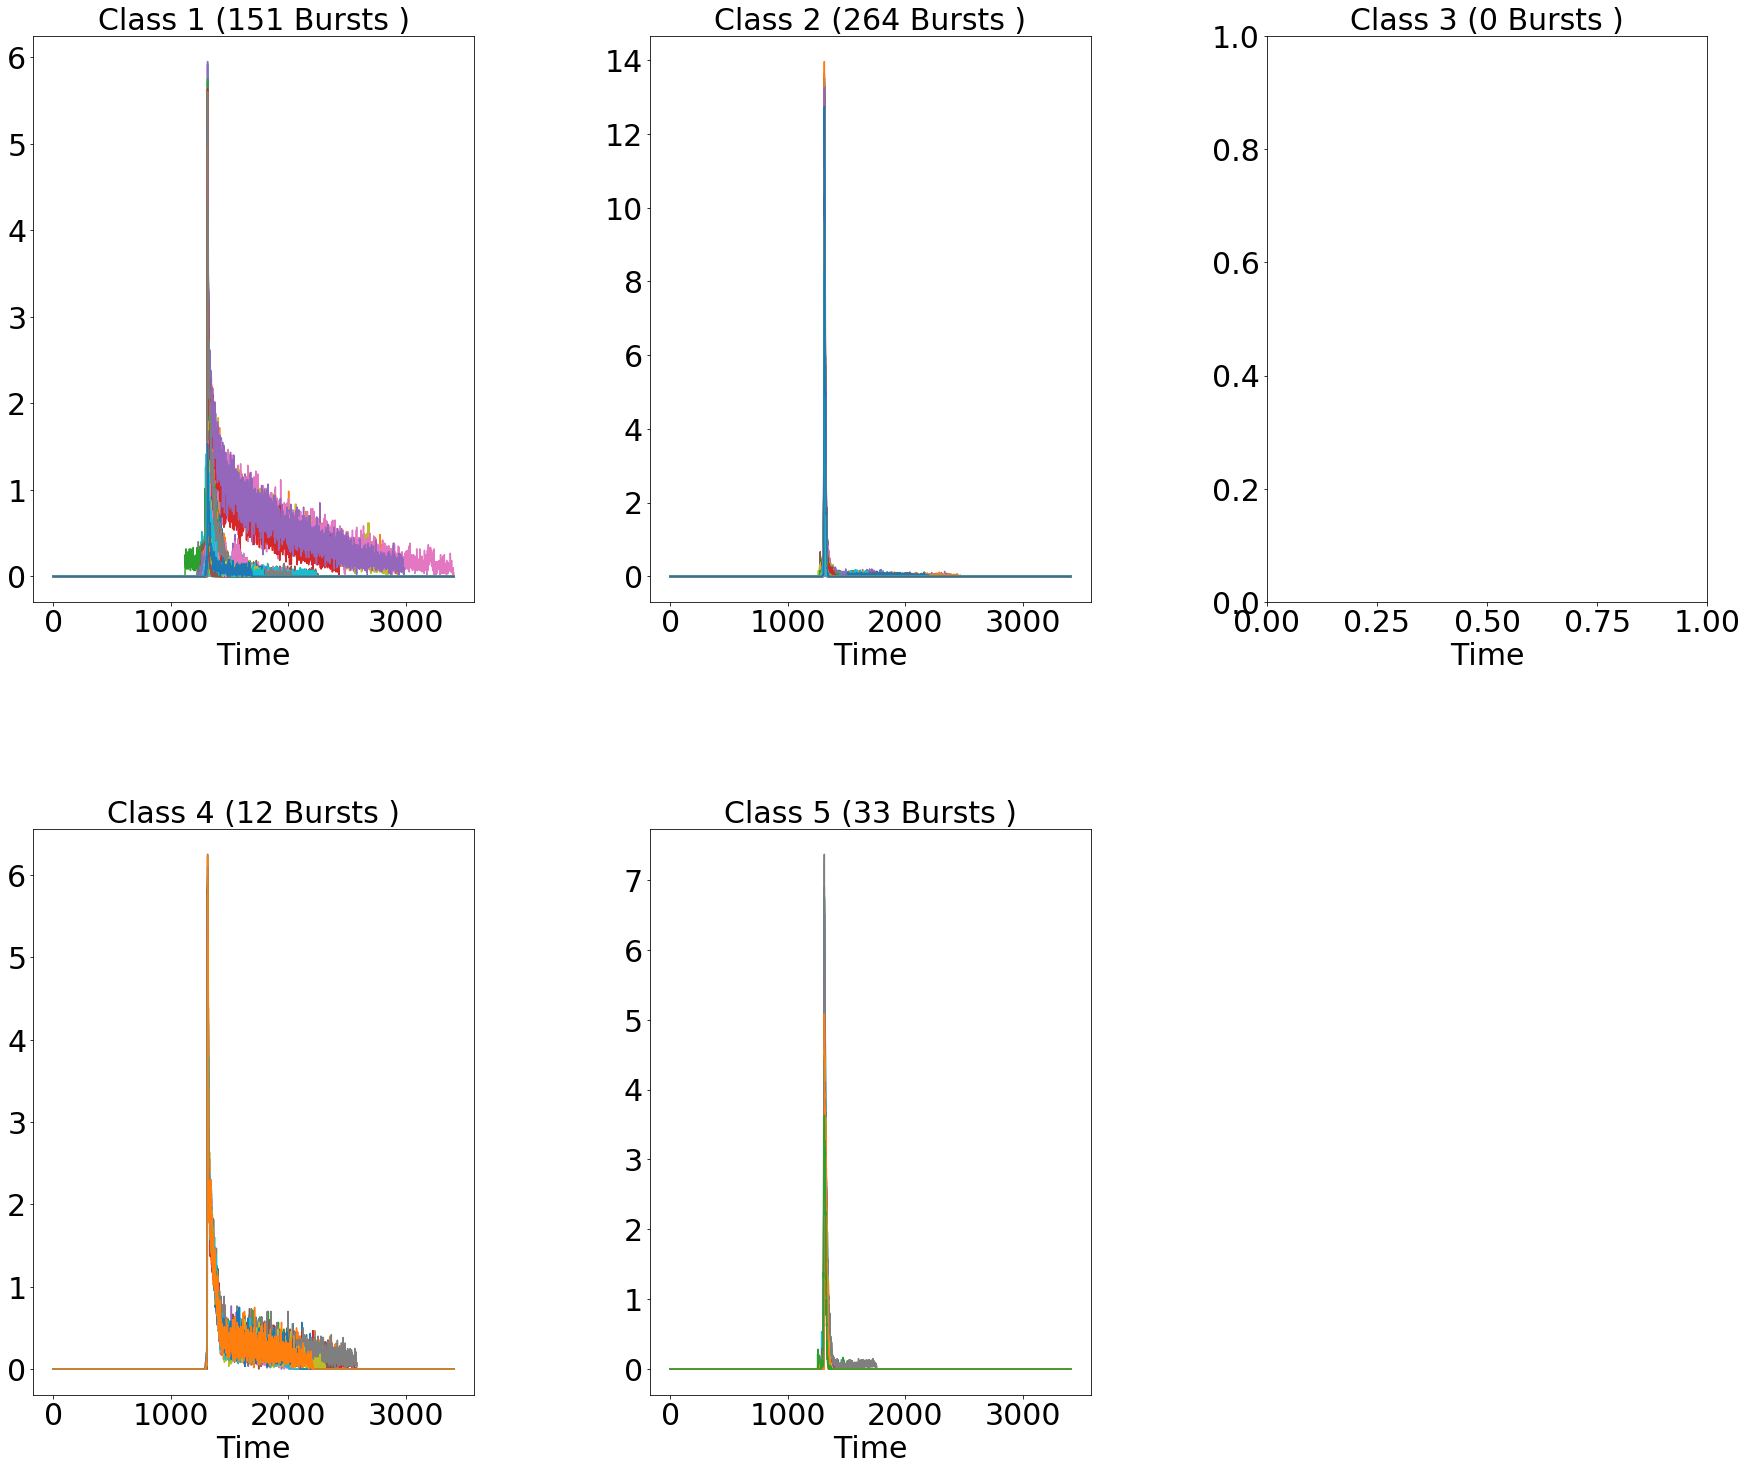

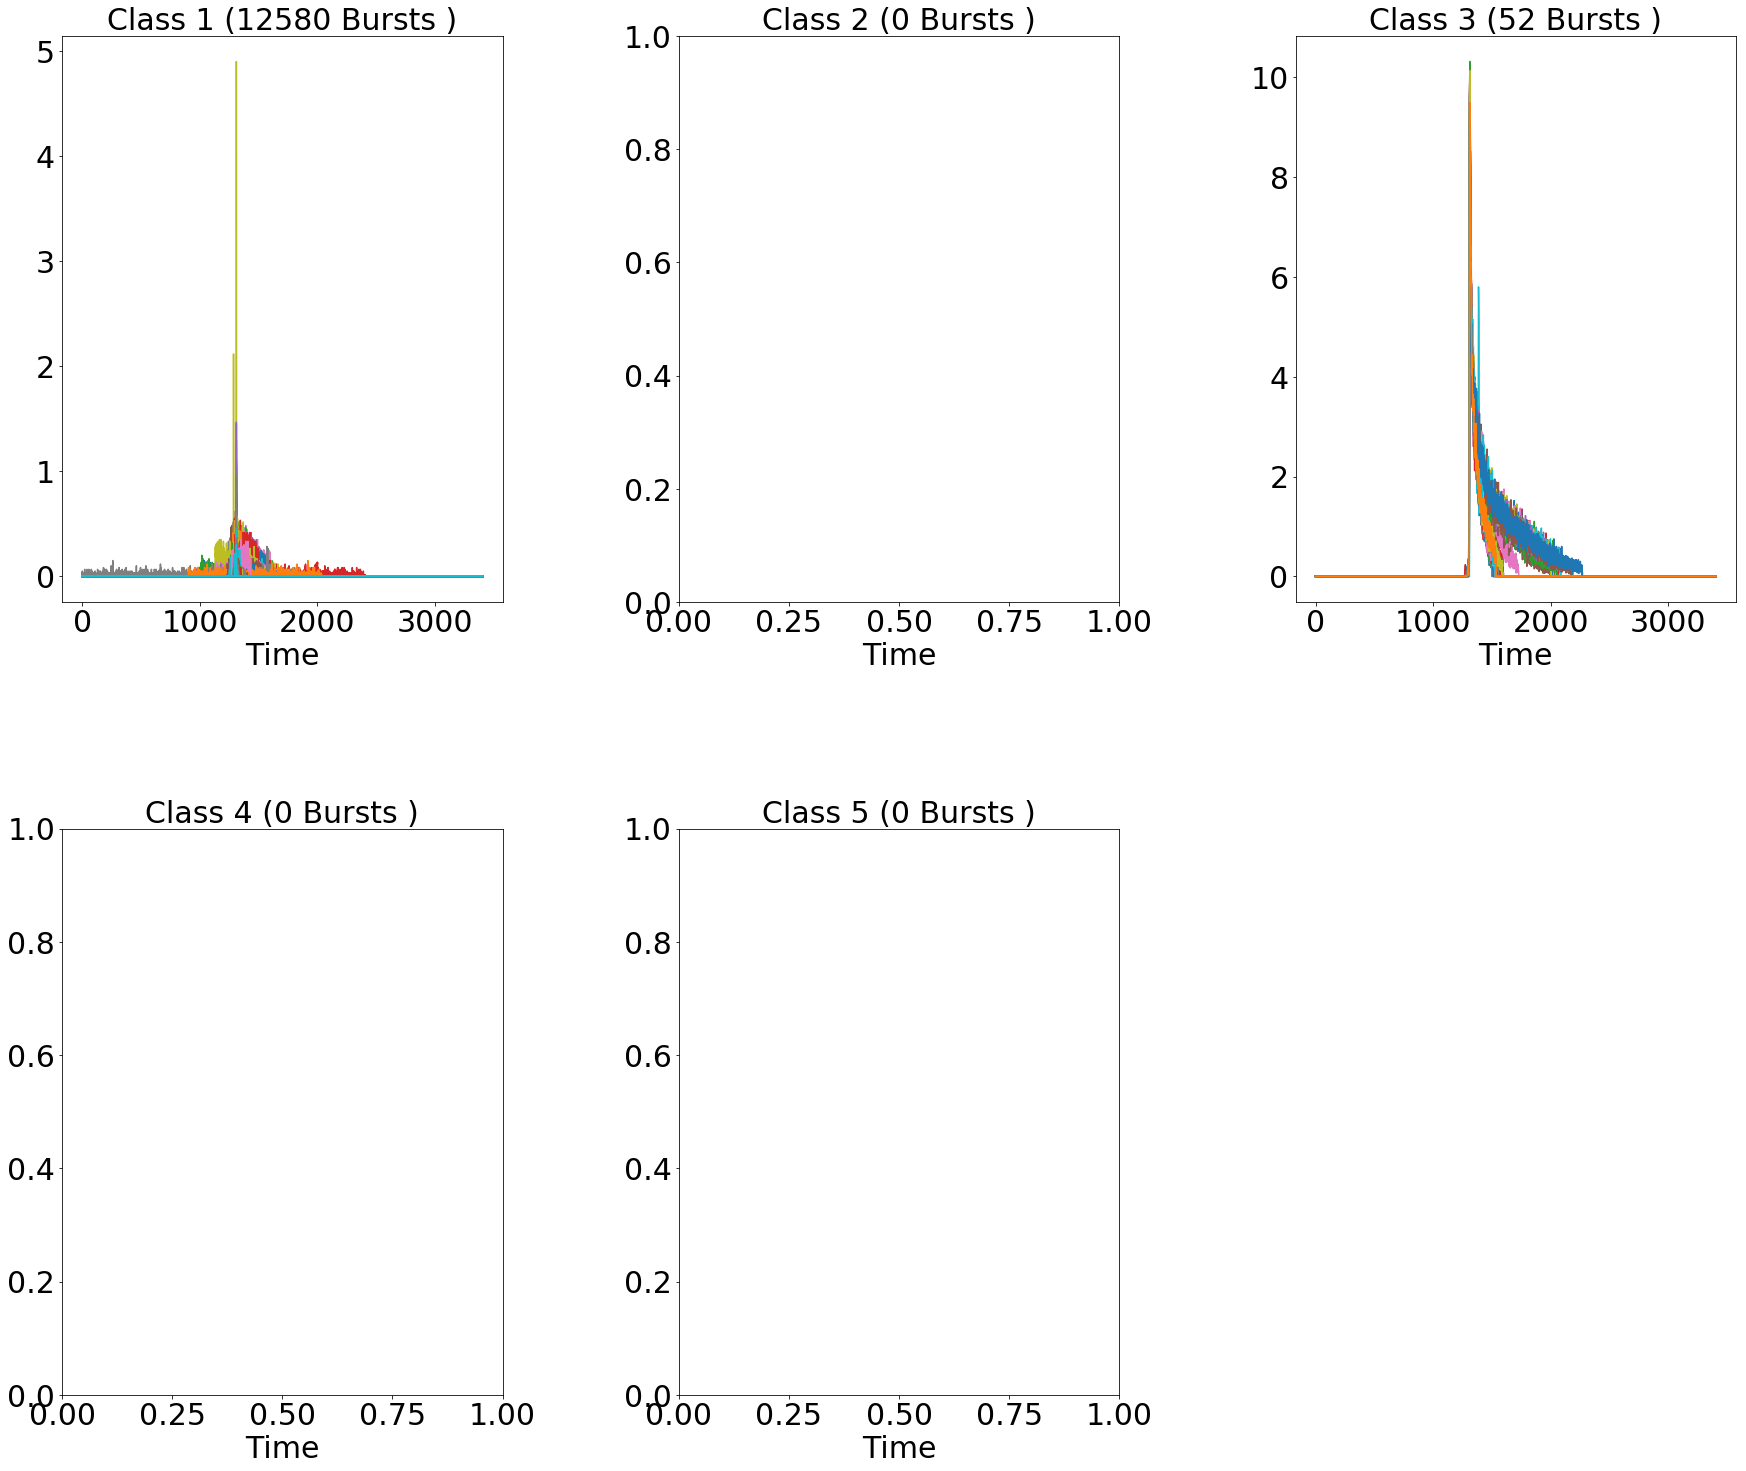

In [48]:
k_clusters_fold = [12,5]
for i in range(1,2):
    k_clusters = k_clusters_fold[i]
    plot_cluster_examples(data[k_low_ps_bursts_folds[k_clusters][i]],low_ps_bursts_fold_labels[i][k_clusters-1], k_clusters)
    plot_cluster_examples(data[k_high_ps_bursts_folds[k_clusters][i]],high_ps_bursts_fold_labels[i][k_clusters-1], k_clusters)

## Mean cluster Prediction Strength for clustering with k clusters

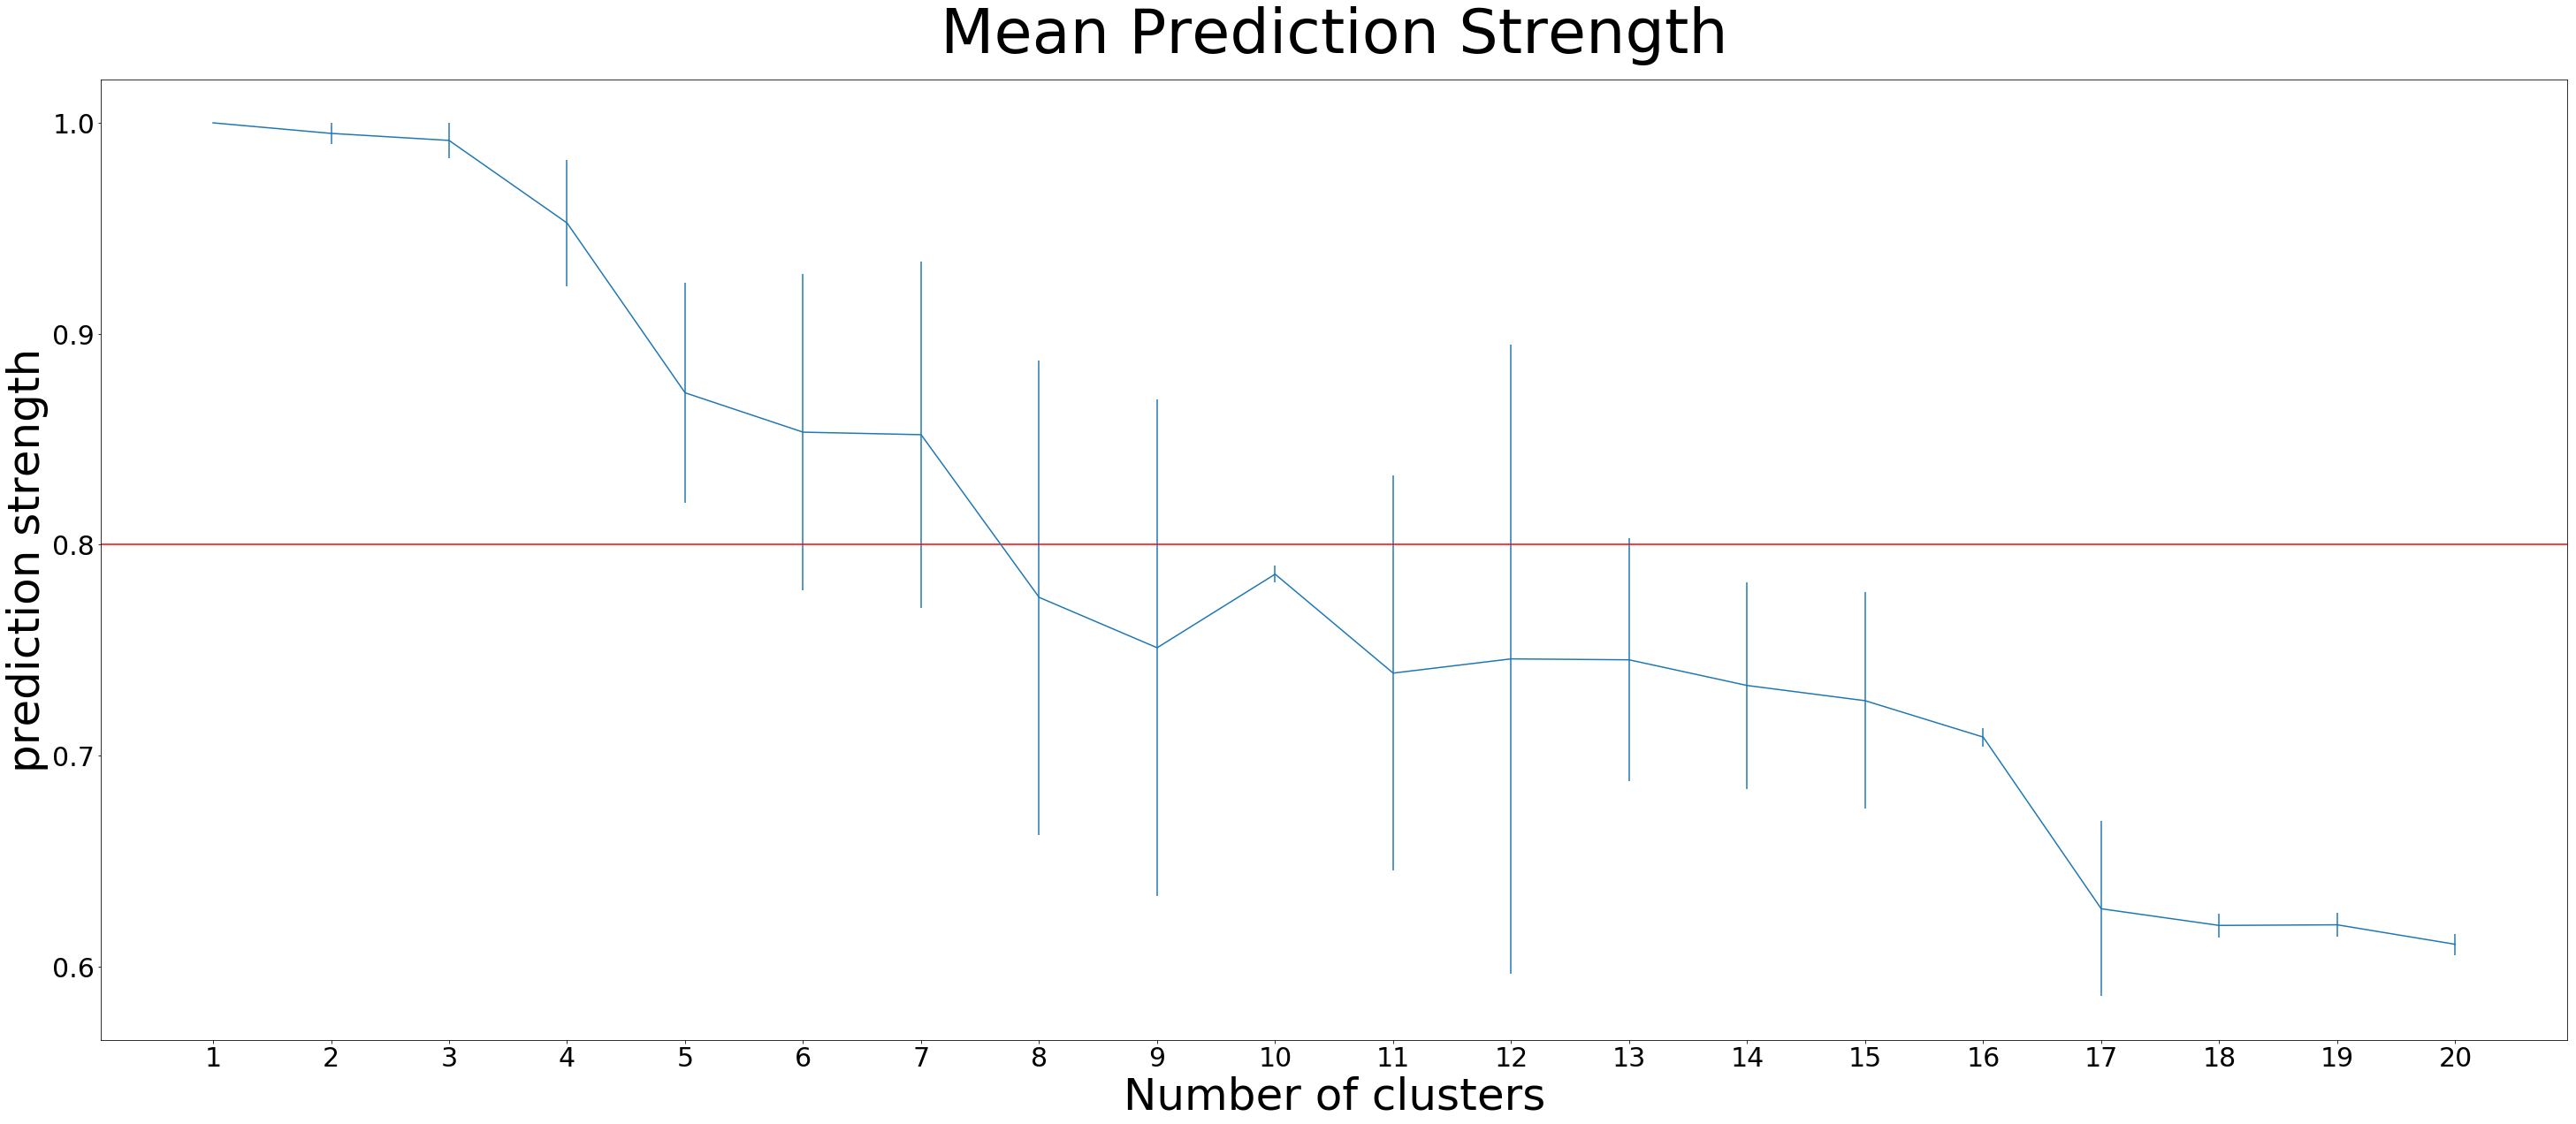

In [113]:
plot_mean_prediction_strengths(k_predictions_strength_cv)

In [114]:
def plot_proportion_weighted_mean_prediction_strengths(k_predictions_strength_cv, valid_cluster_size,n_folds = 1,threshold = 0.8):
    fig, ax = plt.subplots(figsize=(50,20))
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 
    
    n_clusters = range(1,len(k_predictions_strength_cv)+1)
    mean_min_prediction_strengths = []
    err_min_prediction_strengths = []
    
    for i in n_clusters:
        #prop_cluster_sizes = np.asarray((valid_cluster_size[i])/np.sum(valid_cluster_size[i],axis = 1)[:, np.newaxis])           

        
        mean_min_prediction_strength_i = np.mean(np.sum(k_predictions_strength_cv[i]*np.asarray(valid_cluster_size[i]) ,axis = 1)/np.sum(valid_cluster_size[i],axis = 1))
        err_min_prediction_strength_i = np.std(np.sum(k_predictions_strength_cv[i]*np.asarray(valid_cluster_size[i]), axis = 1)/np.sum(valid_cluster_size[i],axis = 1))
        #mean_min_prediction_strength_i = np.mean(np.mean(k_predictions_strength_cv[i]*prop_cluster_sizes,axis=1))
        #err_min_prediction_strength_i = np.std(np.mean(k_predictions_strength_cv[i]*prop_cluster_sizes,axis=1))


        mean_min_prediction_strengths.append(mean_min_prediction_strength_i)
        err_min_prediction_strengths.append(err_min_prediction_strength_i)

  
    ax.errorbar(n_clusters, mean_min_prediction_strengths, yerr=err_min_prediction_strengths)
    for i,k in enumerate(n_clusters):
        ax.annotate("%.2f" % (mean_min_prediction_strengths[i]), (k+0.01,mean_min_prediction_strengths[i] + 0.01), fontsize = 15)
    
    
    if threshold:
        ax.axhline(threshold, color = "red", label = "Threshold")
        plt.yticks(list(plt.yticks()[0]) + [threshold])
    ax.set_title("Mean Prediction Strength weighted by Cluster Size", fontsize = 70,pad = 30)
    ax.set_xticks(n_clusters)
    ax.set_xlabel("Number of clusters",fontsize=50)
    ax.set_ylabel("prediction strength",fontsize=50) 
    ax.legend(fontsize = 35)
    ax.set_ylim((0,1.1))
    

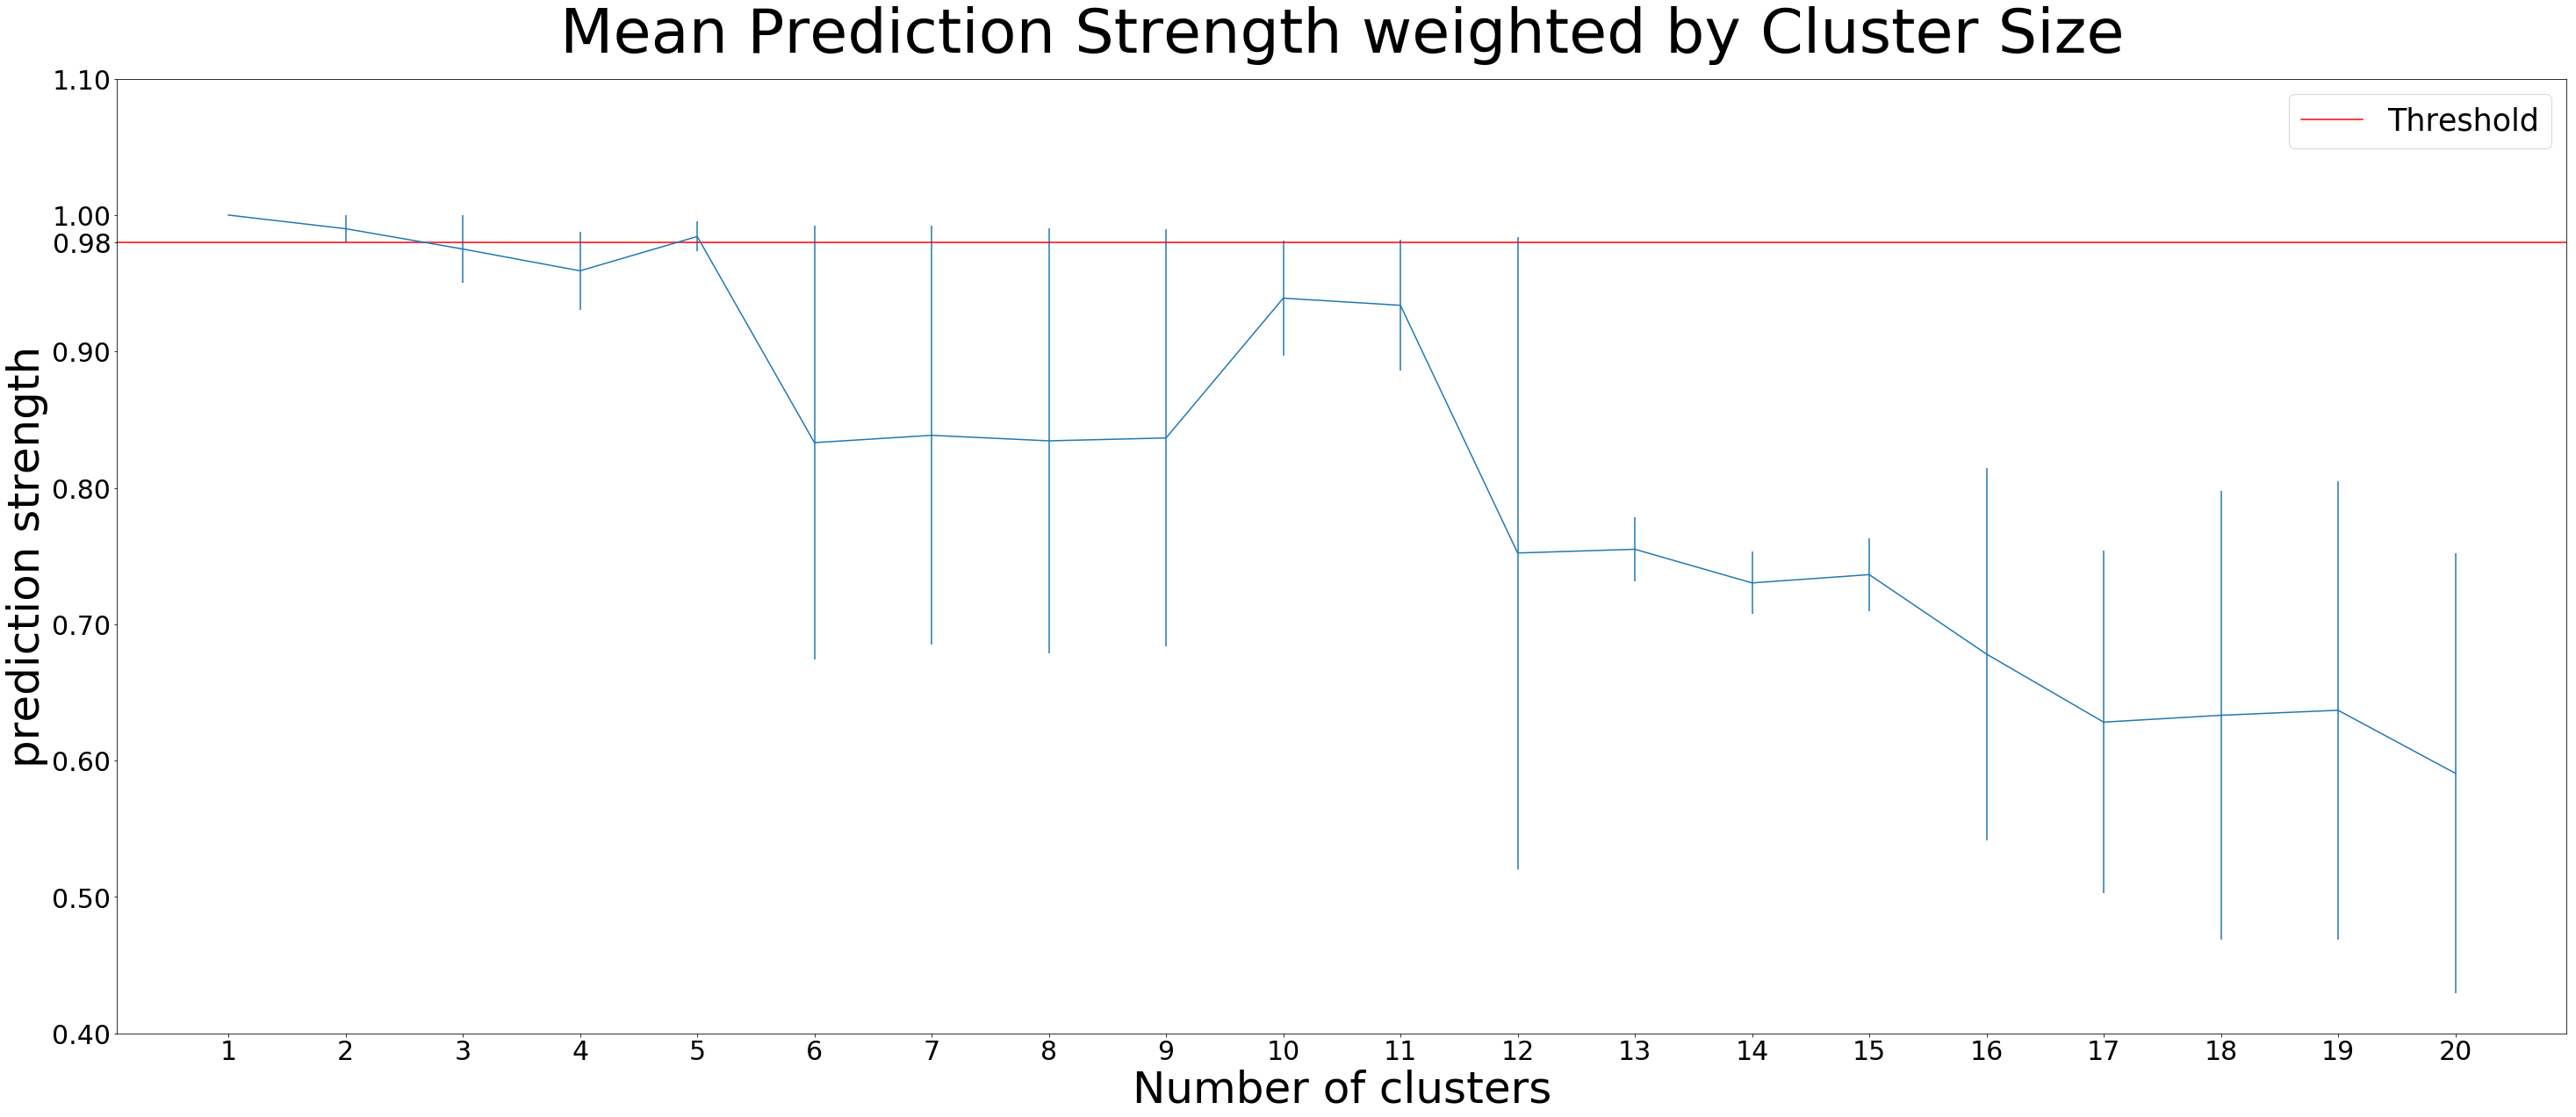

In [115]:
plot_proportion_weighted_mean_prediction_strengths(k_predictions_strength_cv, valid_cluster_size,n_folds = 2, threshold = 0.98)

## Prediction Strength of GMM with k clusters
- compute the co-membership matrix of bursts falling into same clusters after assigning clusters based on nearest centroids calculated on training set clusters
- compare clusters computed on validation dataset with clusters computed by nearest centroids based on comembership
- measure how well the centroids of training data predict spectral cluster labels of the validation set

In [51]:
bics = list(np.load(data_dir + 'culture_balanced/bics.npy',allow_pickle=True))
scores = list(np.load(data_dir + 'culture_balanced/scores.npy',allow_pickle=True))
predictions_valid = list(np.load(data_dir + 'culture_balanced/predictions_valid.npy',allow_pickle=True))
predictions_train = list(np.load(data_dir + 'culture_balanced/predictions_train.npy',allow_pickle=True))
predictions_valid_fitted = list(np.load(data_dir + 'culture_balanced/predictions_valid_fitted.npy',allow_pickle=True))        

In [52]:
n_clusters = 20
n_folds = 1
train_fold_labels_gmm = []
valid_fold_labels_gmm = []

for i in range(n_folds):
    train_fold_labels_gmm.append([])
    valid_fold_labels_gmm.append([])
  
  
for i in range(n_clusters):
    train_fold_labels_gmm[0].append(predictions_train[i])
    valid_fold_labels_gmm[0].append(predictions_valid_fitted[i])

In [54]:
print(len(train_fold_labels_gmm[0]))

20


In [21]:
bics = list(np.load(data_dir + '50_50_split/bics_1.npy',allow_pickle=True)) # contains bic score for training and validation set since 50/50 split one file contains full info about bic 
scores_1 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True)) # scores for training and validation set 
scores_2 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True))

predictions_valid_1 = list(np.load(data_dir + '50_50_split/predictions_valid_1.npy',allow_pickle=True)) # predictions of validation set 
predictions_valid_2 = list(np.load(data_dir + '50_50_split/predictions_valid_2.npy',allow_pickle=True))

predictions_train_1 = list(np.load(data_dir + '50_50_split/predictions_train_1.npy',allow_pickle=True)) # predictions of training set 
predictions_train_2 = list(np.load(data_dir + '50_50_split/predictions_train_2.npy',allow_pickle=True)) 

predictions_valid_fitted_1 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_1.npy',allow_pickle=True)) # predictions of validation set after fitting gmm on it
predictions_valid_fitted_2 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_2.npy',allow_pickle=True)) 

In [22]:
n_clusters = 20
n_folds = 2


train_fold_labels_gmm = np.stack((predictions_train_1,predictions_train_2),axis = 0)
valid_fold_labels_gmm = np.stack((predictions_valid_fitted_1,predictions_valid_fitted_2), axis = 0)

In [58]:
print(len(train_fold_labels_gmm[0]))

20


In [69]:
predictions_strengths_cv_gmm,valid_fold_labels_predicted_gmm = cross_valdation_prediction_strength(data, train_folds, valid_folds, train_fold_labels_gmm, valid_fold_labels_gmm)

Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold


In [96]:
predictions_strengths_cv_gmm_per_sample,_ = cross_valdation_prediction_strength(data, train_folds, valid_folds, train_fold_labels_gmm, valid_fold_labels_gmm,per_sample=True)

Calculate Predictions Strength for 1. Fold
Calculate Predictions Strength for 2. Fold


In [97]:
#np.save(data_dir + '50_50_split/prediction_strength_gmm_per_sample',predictions_strengths_cv_gmm_per_sample)
#np.save(data_dir + '50_50_split/prediction_strength_gmm',predictions_strengths_cv_gmm)
#np.save(data_dir + '50_50_split/valid_fold_labels_predicted_gmm',valid_fold_labels_predicted_gmm)

In [23]:
predictions_strengths_cv_gmm_per_sample = list(np.load(data_dir + '50_50_split/prediction_strength_gmm_per_sample.npy',allow_pickle=True))
predictions_strengths_cv_gmm = list(np.load(data_dir + '50_50_split/prediction_strength_gmm.npy',allow_pickle=True))
valid_fold_labels_predicted_gmm = list(np.load(data_dir + '50_50_split/valid_fold_labels_predicted_gmm.npy',allow_pickle=True))

In [89]:
k_predictions_strength_cv_gmm, k_valid_fold_labels_predicted_gmm, k_valid_fold_labels_gmm, valid_cluster_size_gmm, valid_cluster_size_predicted_gmm = calculate_prediction_strength_per_k(predictions_strengths_cv_gmm,valid_fold_labels_gmm,valid_fold_labels_predicted_gmm, strength_sorted = False)

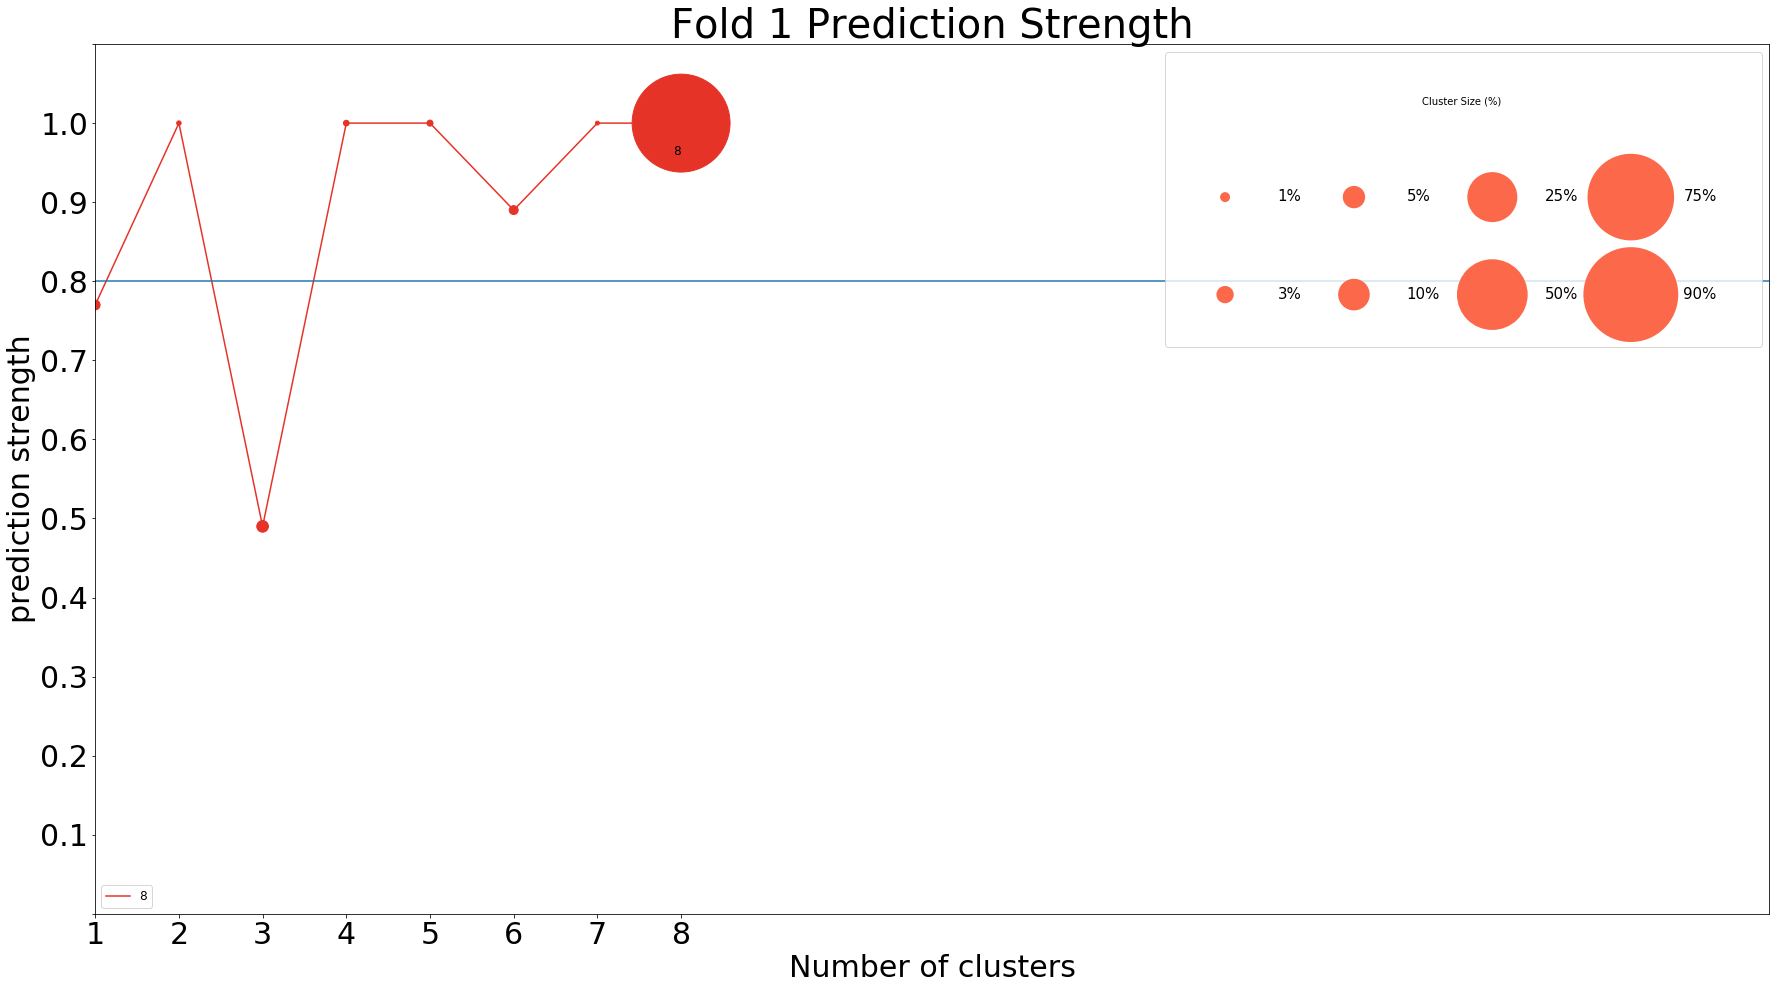

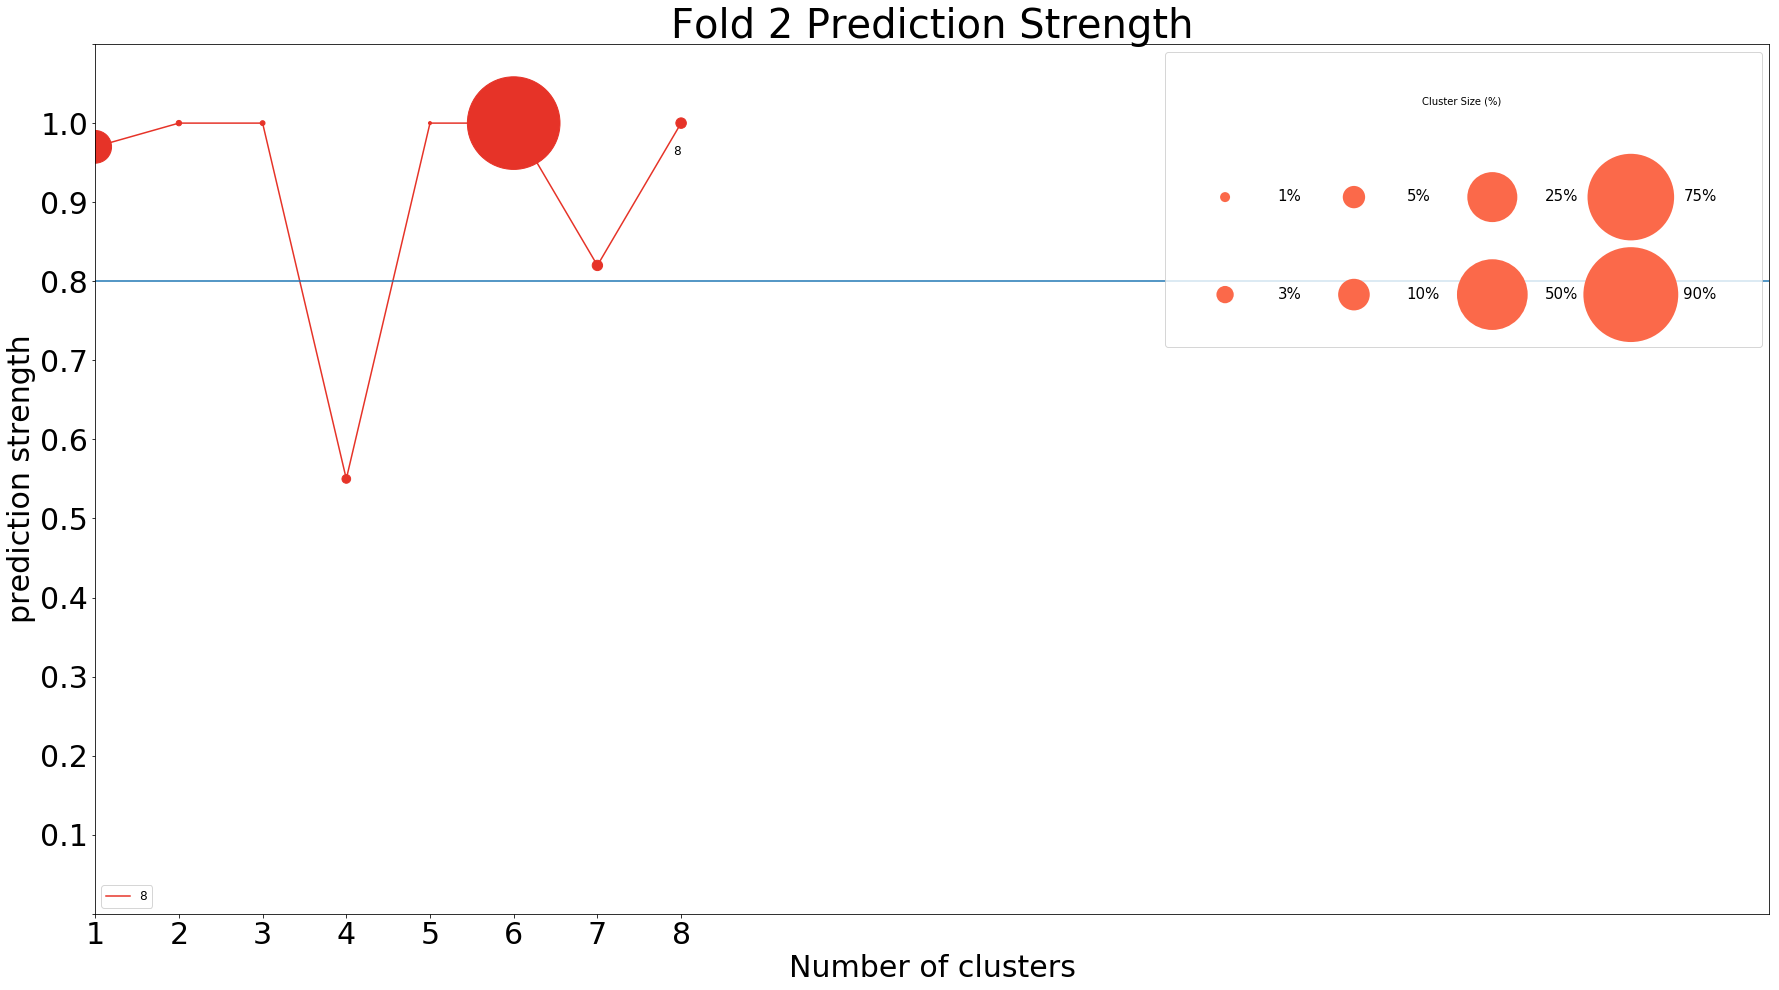

In [91]:
plot_prediction_strength(k_predictions_strength_cv_gmm,valid_cluster_size_gmm,color = sns.color_palette('Reds', 25,)[::-1], n_folds = 2,k_clusters= [8])

Calculate proportion of Bursts from validation set falling into cluster with low prediction strength (below threshold of 0.8) per clustering with k clusters based on clusters found by GMM.

In [80]:
bad_cluster_sizes_cv_gmm, bad_cluster_sizes_cv_predicted_gmm = calculate_bad_cluster_sizes_cv(k_predictions_strength_cv_gmm, valid_cluster_size_gmm,valid_cluster_size_predicted_gmm,folds = 2)

In [83]:
average_bad_cluster_size_gmm, average_bad_cluster_size_predicted_gmm = calculate_average_bad_cluster_sizes(bad_cluster_sizes_cv_gmm, bad_cluster_sizes_cv_predicted_gmm,folds = 2)

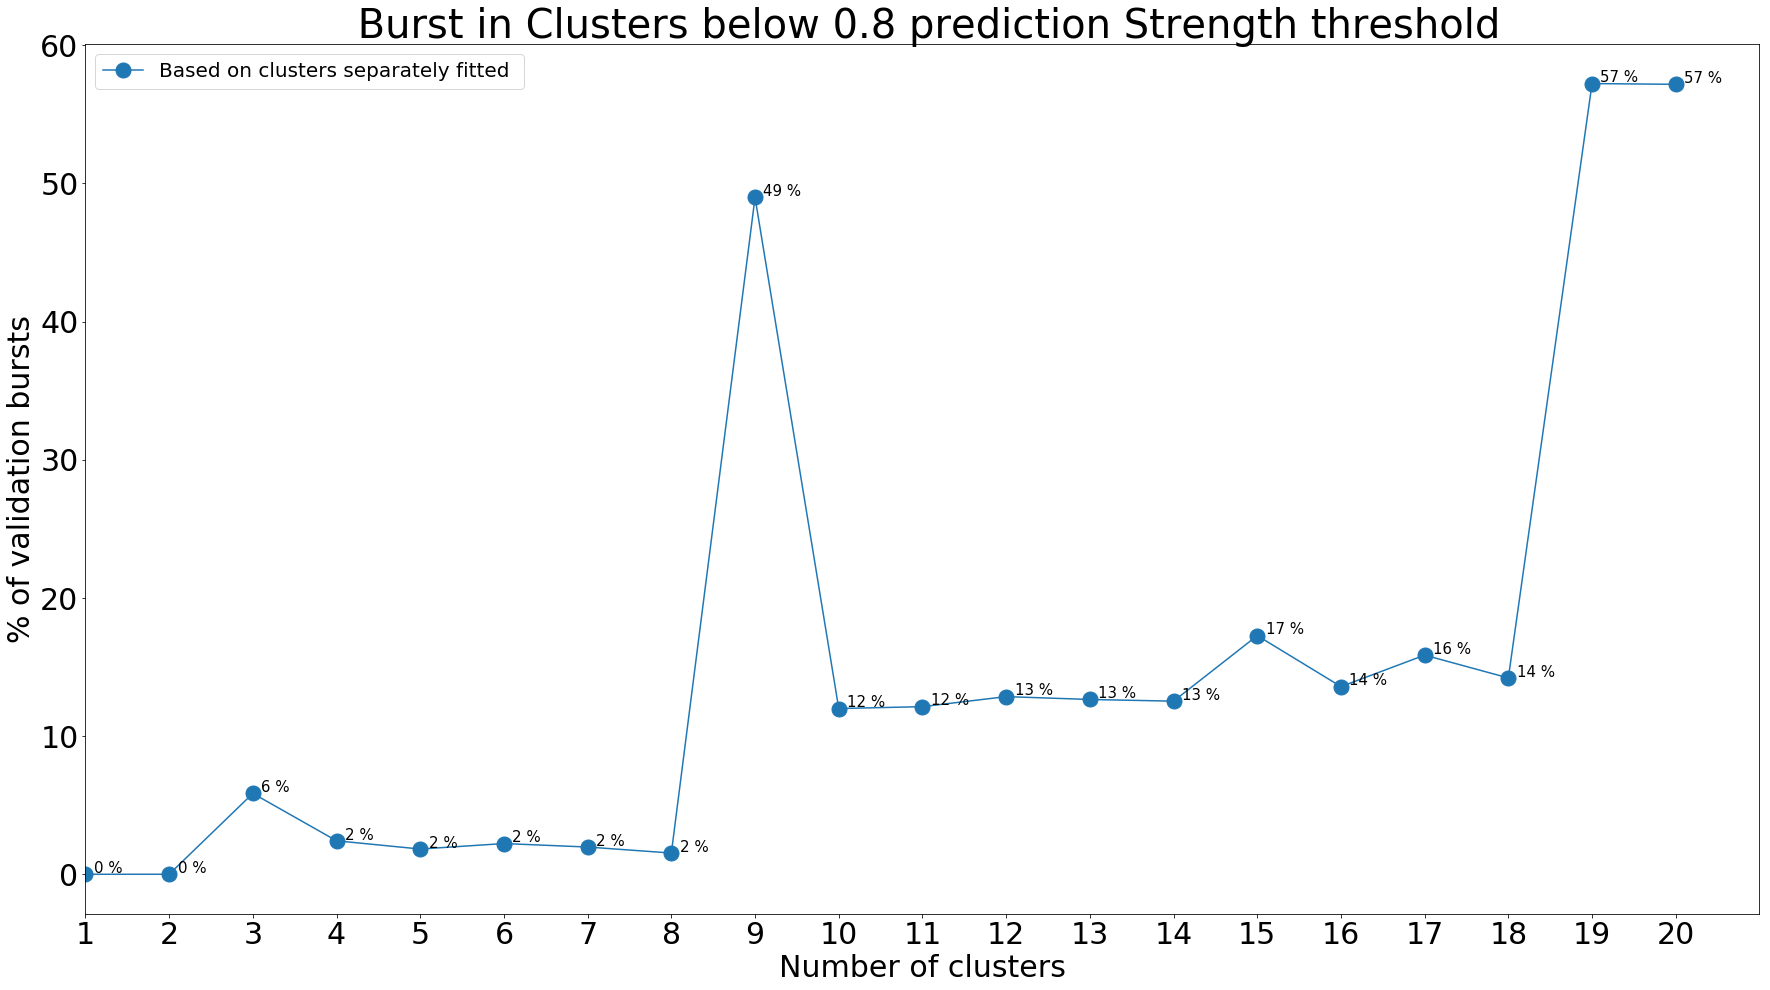

In [84]:
plot_average_proportion_of_bursts_in_low_clusters_per_k(average_bad_cluster_size_gmm, average_bad_cluster_size_predicted_gmm, n_cluster = range(1,21))

In [93]:
n_folds = 2
n_clusters = 20
bad_cluster_size_fold_gmm = []
bad_cluster_size_predicted_fold_gmm = []

for f in range(n_folds):
    bad_cluster_size_f = []
    bad_cluster_size_predicted_f = []
    for i in range(1,n_clusters+1):
        bad_cluster_fold_sum = np.sum(bad_cluster_sizes_cv_gmm[i][f])
        bad_cluster_fold_sum_predicted = np.sum(bad_cluster_sizes_cv_predicted_gmm[i][f])

        bad_cluster_size_f.append(bad_cluster_fold_sum)
        bad_cluster_size_predicted_f.append(bad_cluster_fold_sum_predicted)
    bad_cluster_size_fold_gmm.append(bad_cluster_size_f)
    bad_cluster_size_predicted_fold_gmm.append(bad_cluster_size_predicted_f)

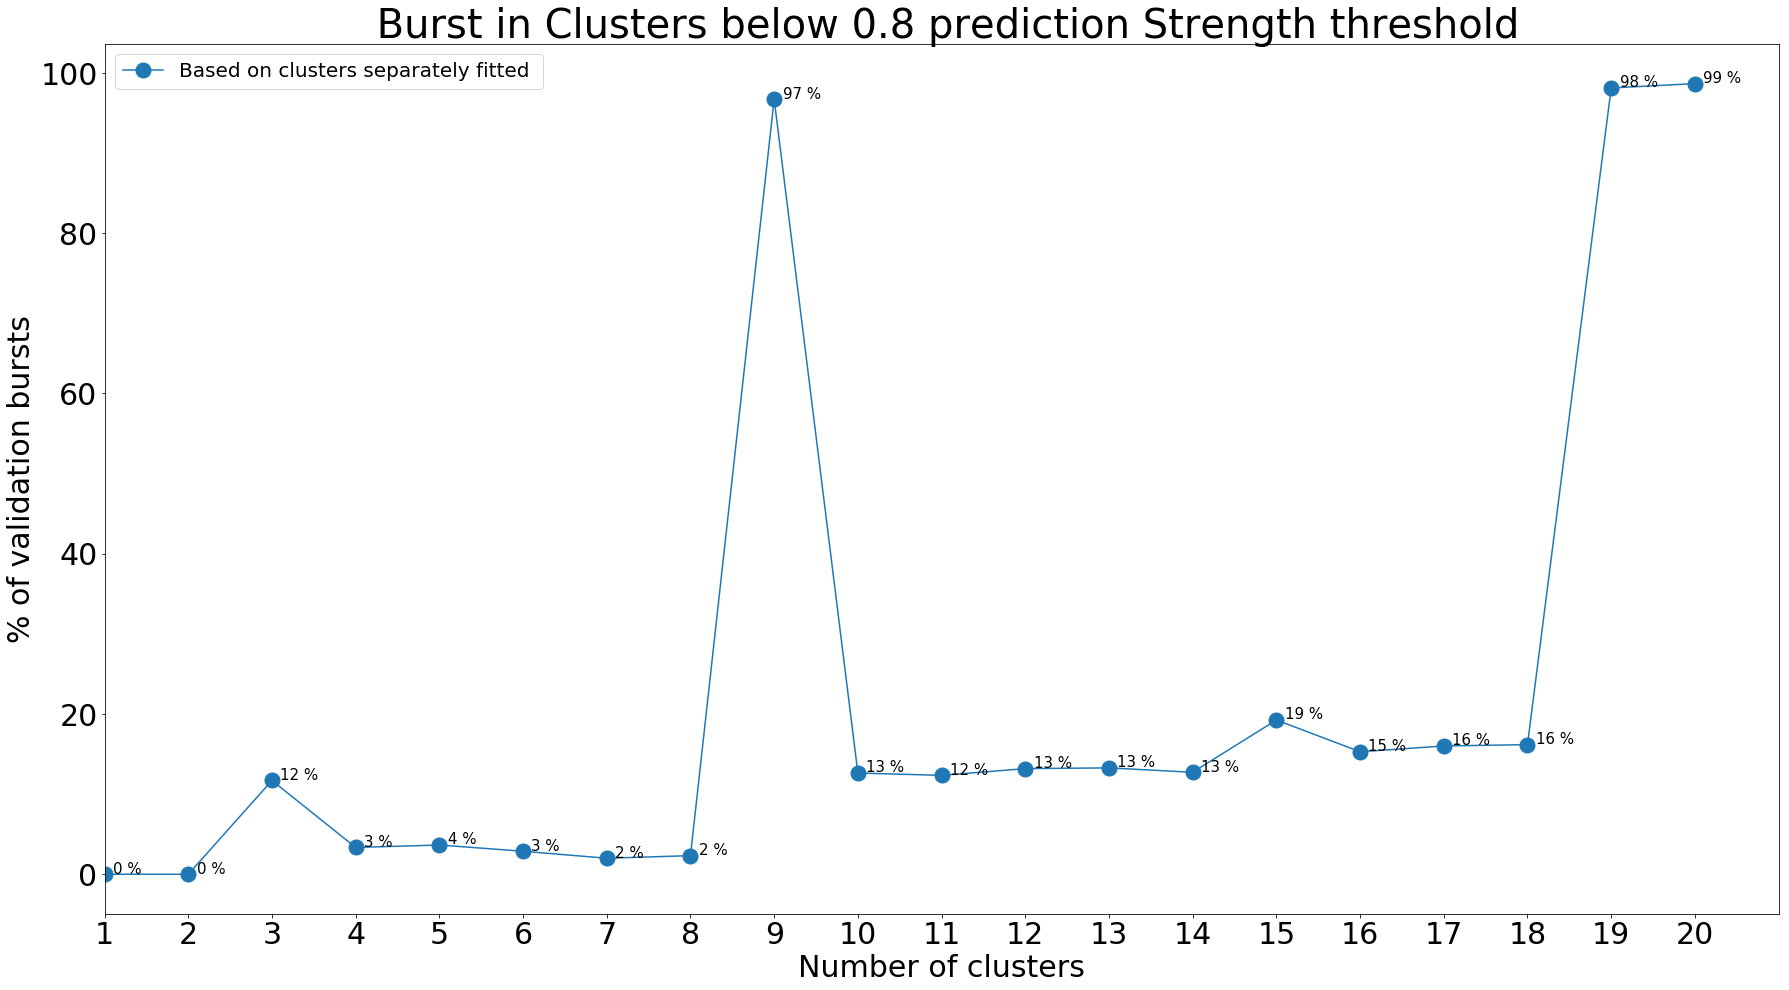

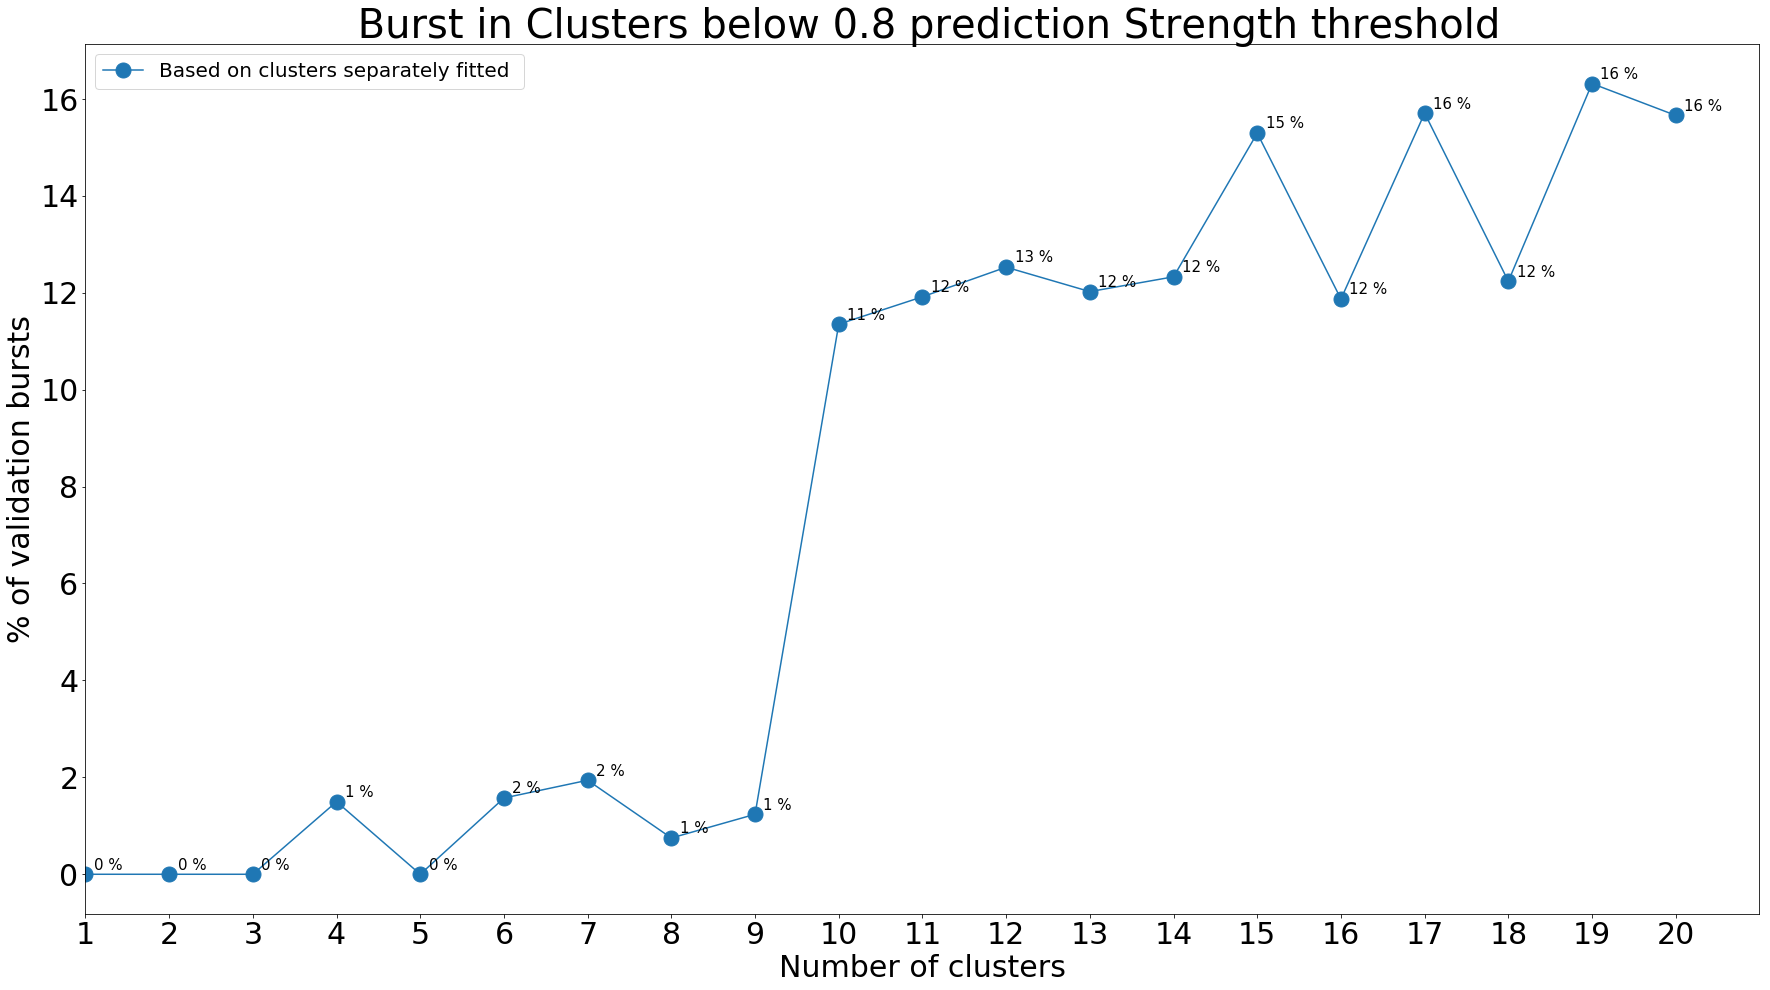

In [94]:
for i in range(n_folds):
    plot_average_proportion_of_bursts_in_low_clusters_per_k(bad_cluster_size_fold_gmm[i], bad_cluster_size_predicted_fold_gmm[i], n_cluster = range(1,21))

### Plot cluster examples

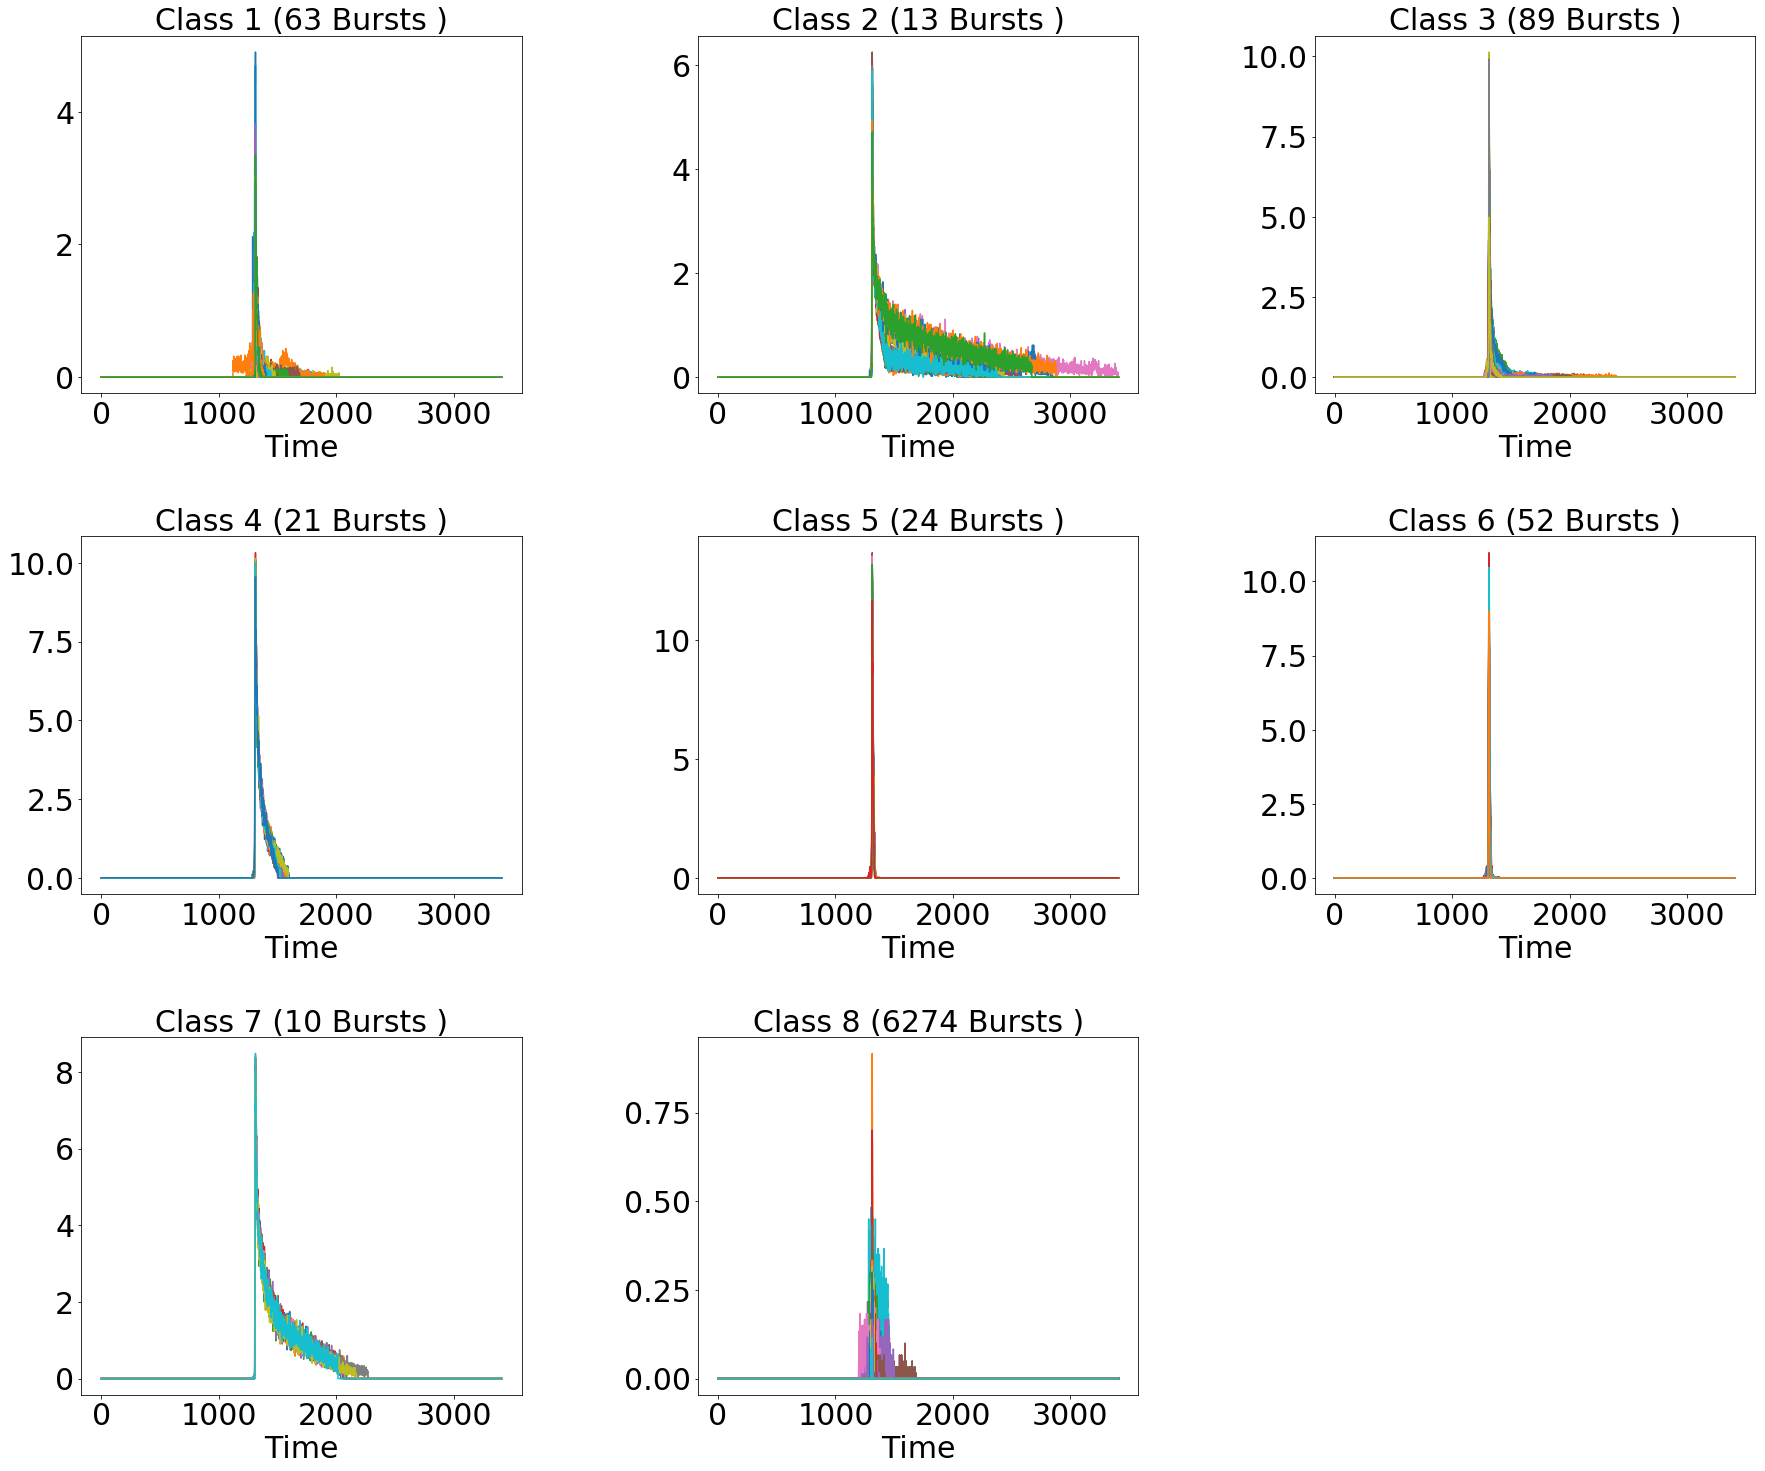

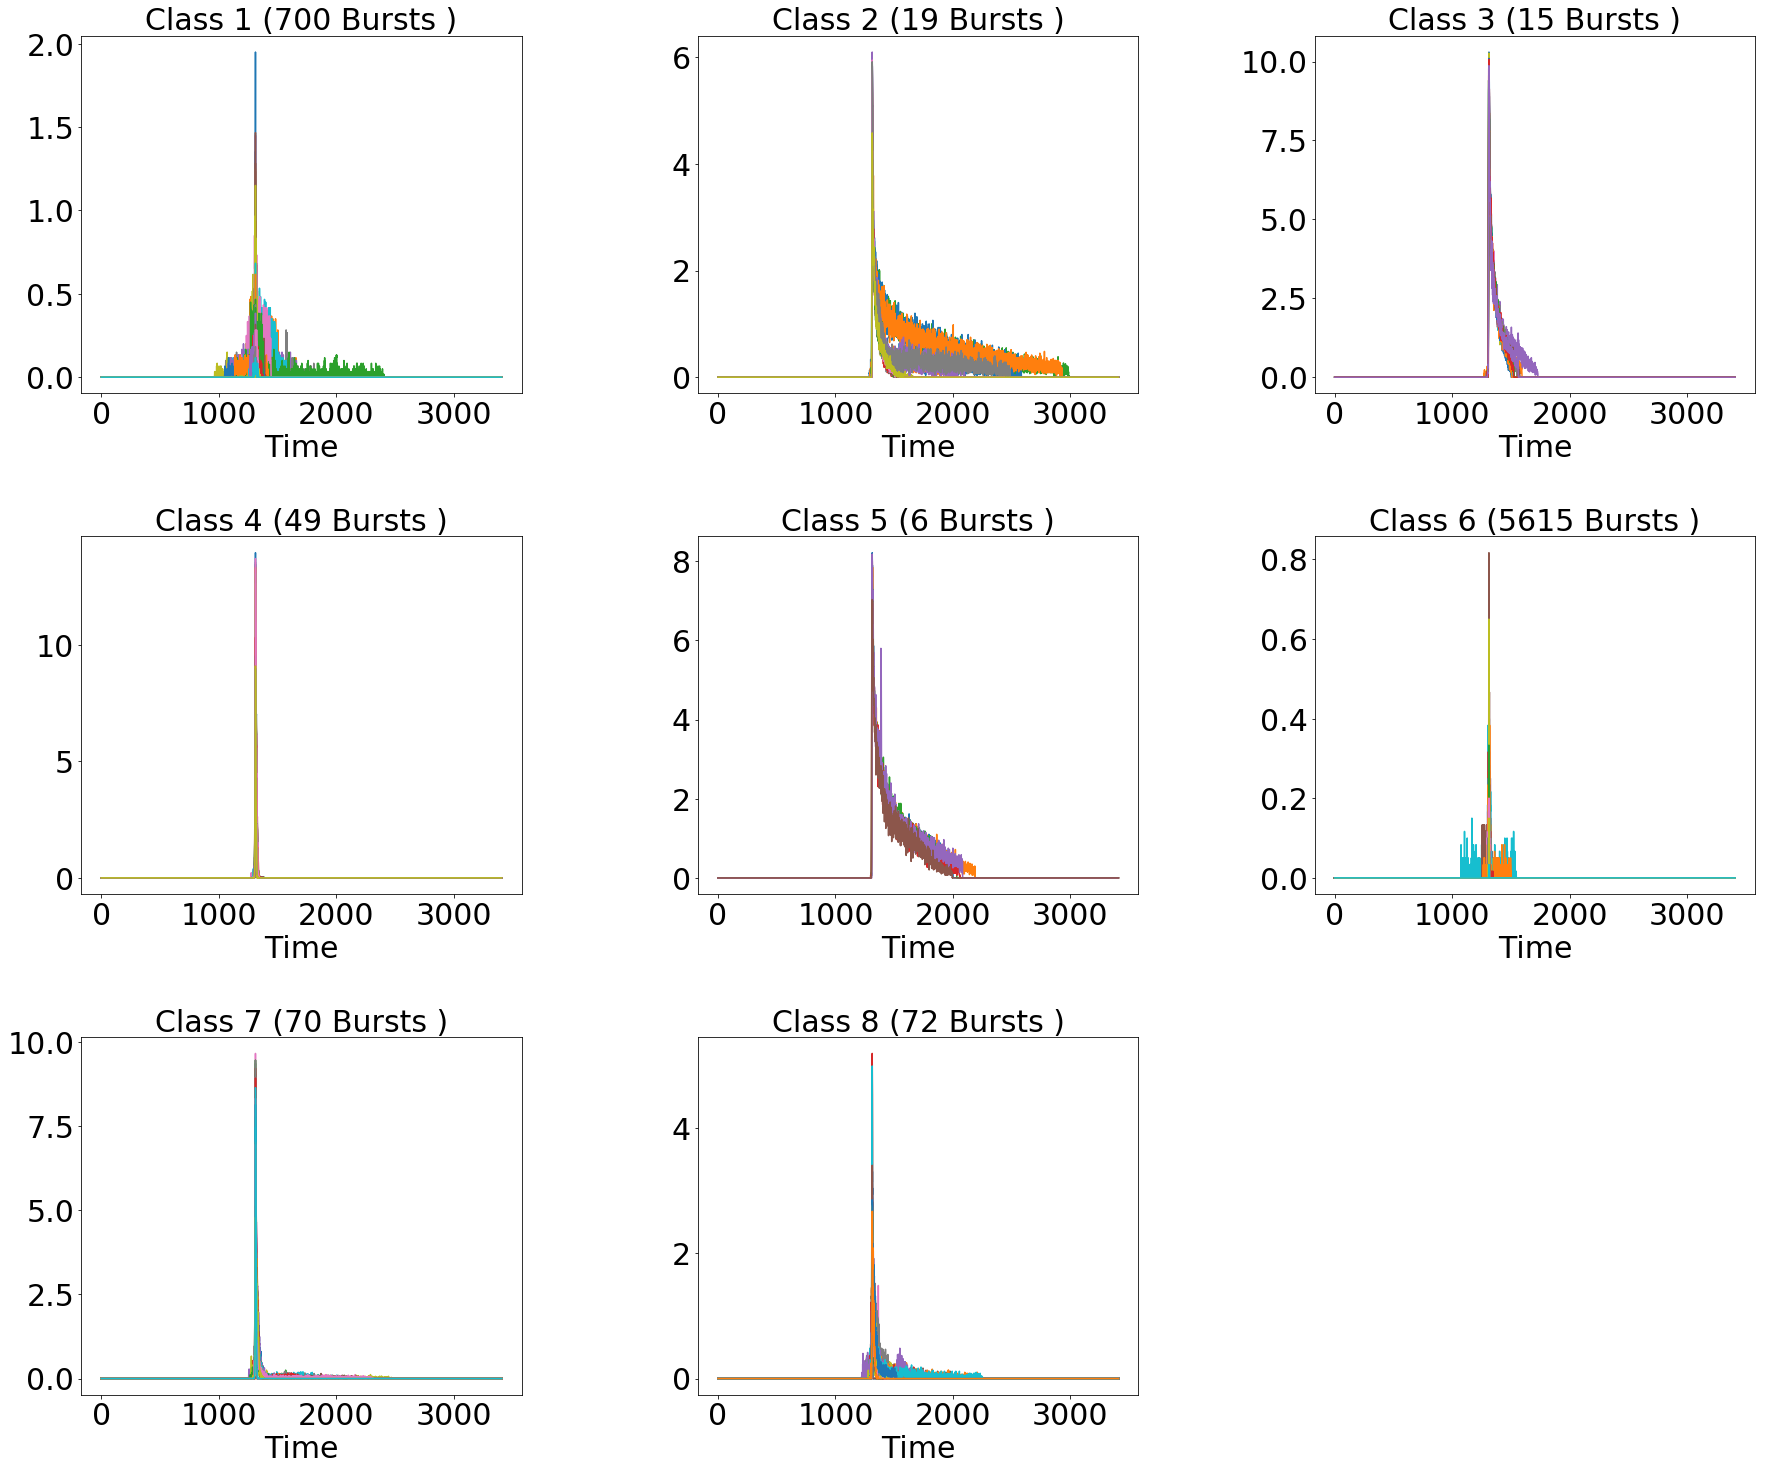

In [95]:
k_clusters_fold = [8,8]
for i,validation_set in enumerate(validation_sets):
    k_clusters = k_clusters_fold[i]
    plot_cluster_examples(validation_set, valid_fold_labels_gmm[i][k_clusters-1], k_clusters)

## Calculate number of Bursts from validation set with low individual prediction strength (below threshold of 0.8) per clustering with k clusters based on clusters found by gmm clustering.

In [44]:
threshold = 0.1
k_low_individual_ps_bursts_gmm, k_low_individual_ps_cv_sizes_gmm,k_low_individual_ps_cv_sizes_prop_gmm = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels_gmm, valid_fold_labels_gmm ,predictions_strengths_cv_gmm_per_sample,threshold = threshold)

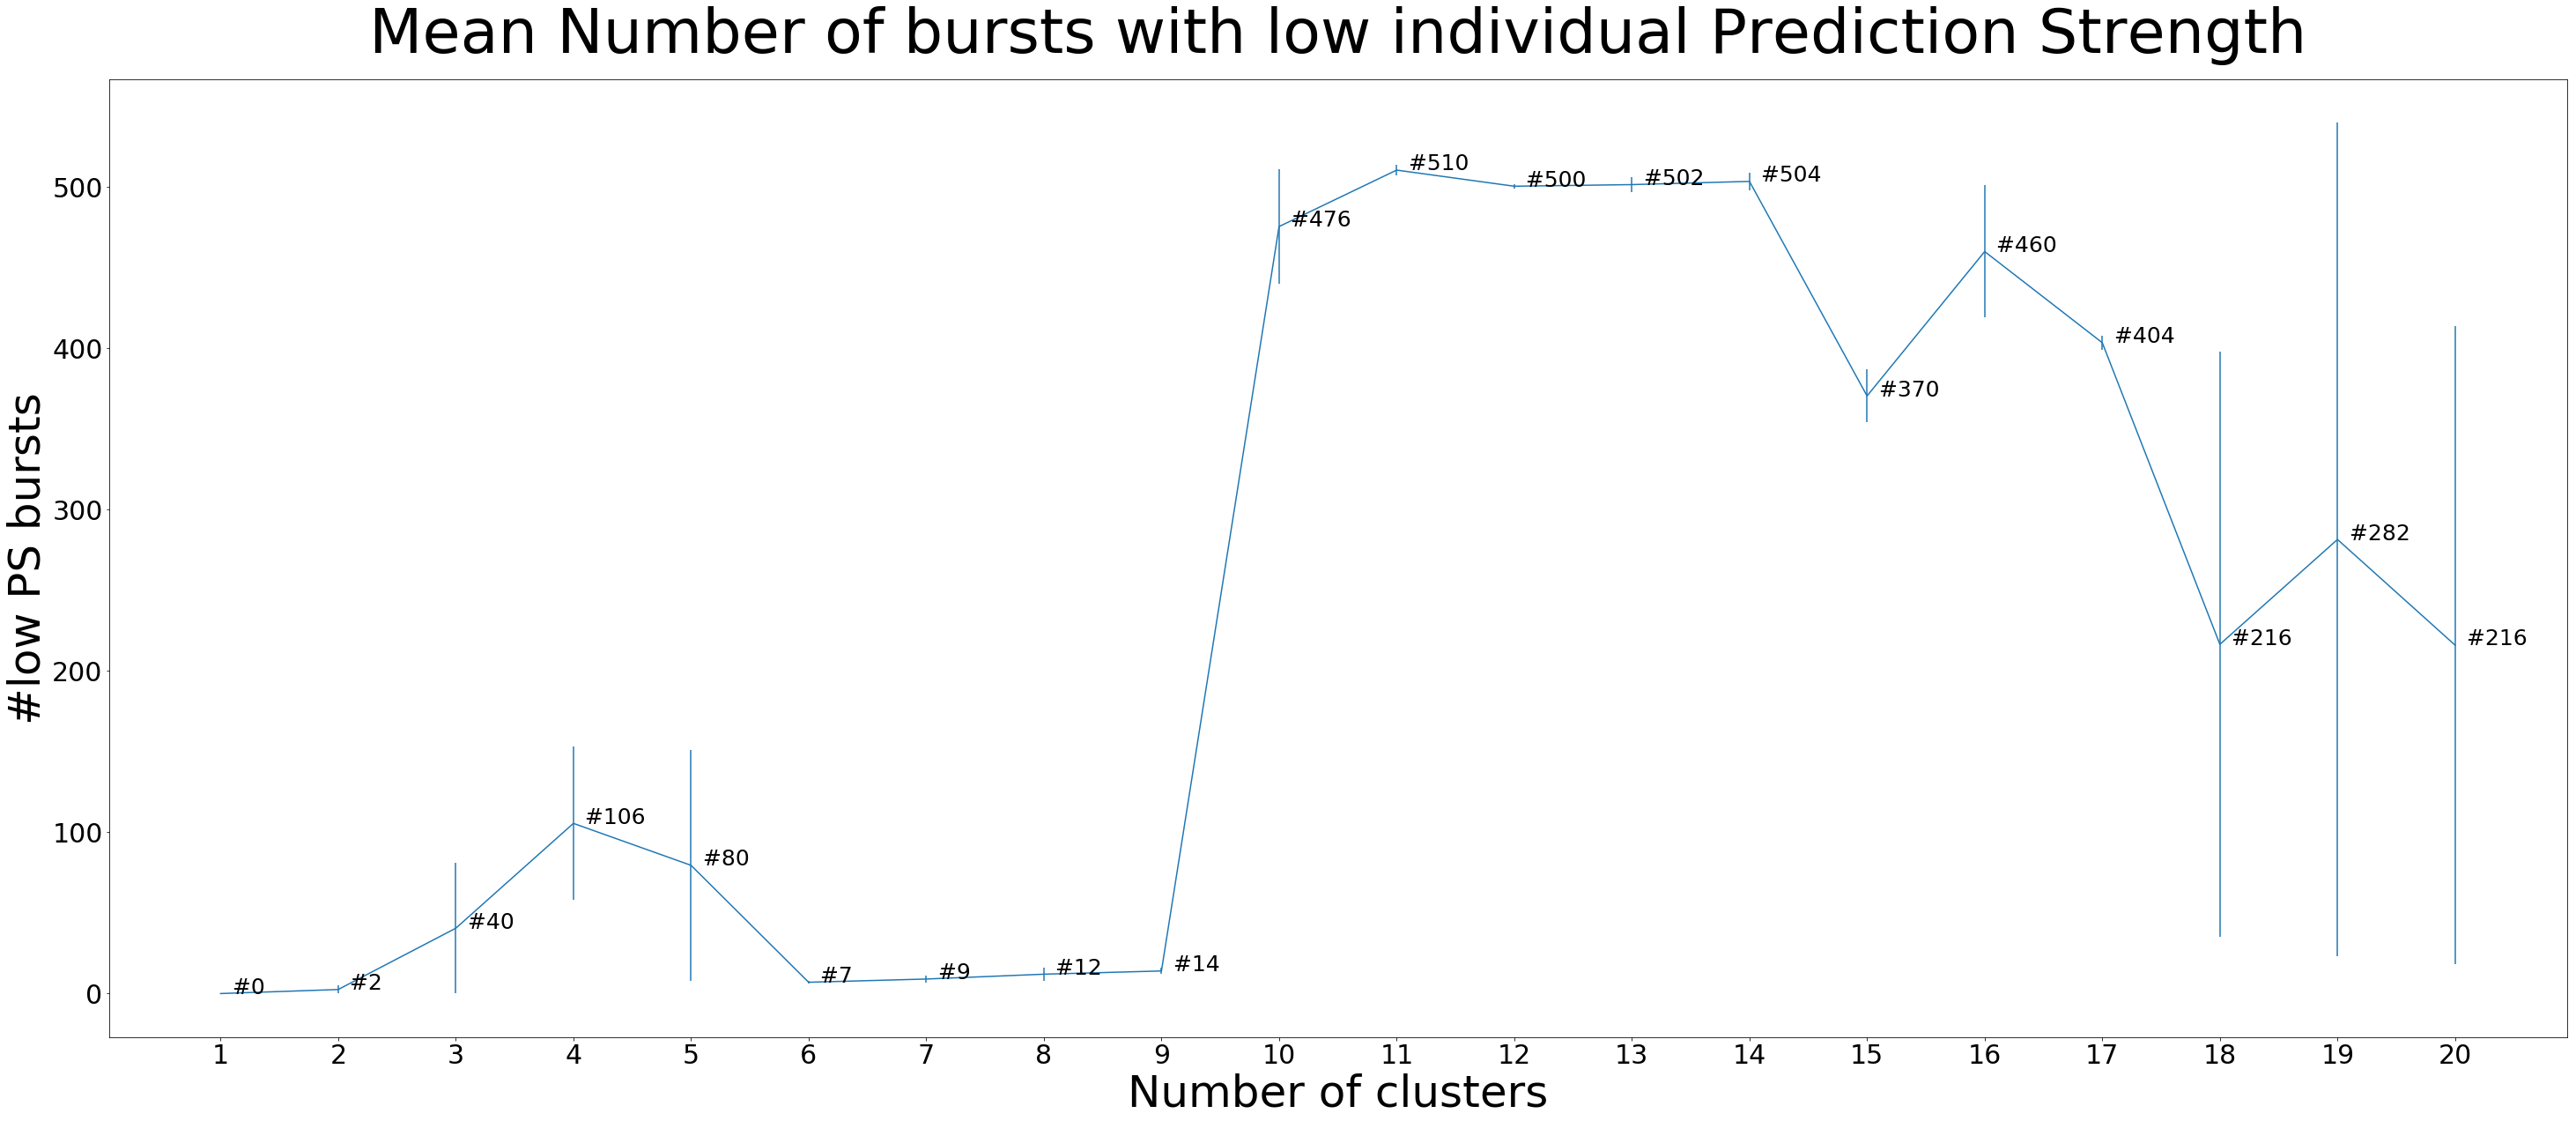

In [45]:
plot_mean_number_of_low_prediction_strength_samples(k_low_individual_ps_cv_sizes_gmm,n_clusters = range(1,21))

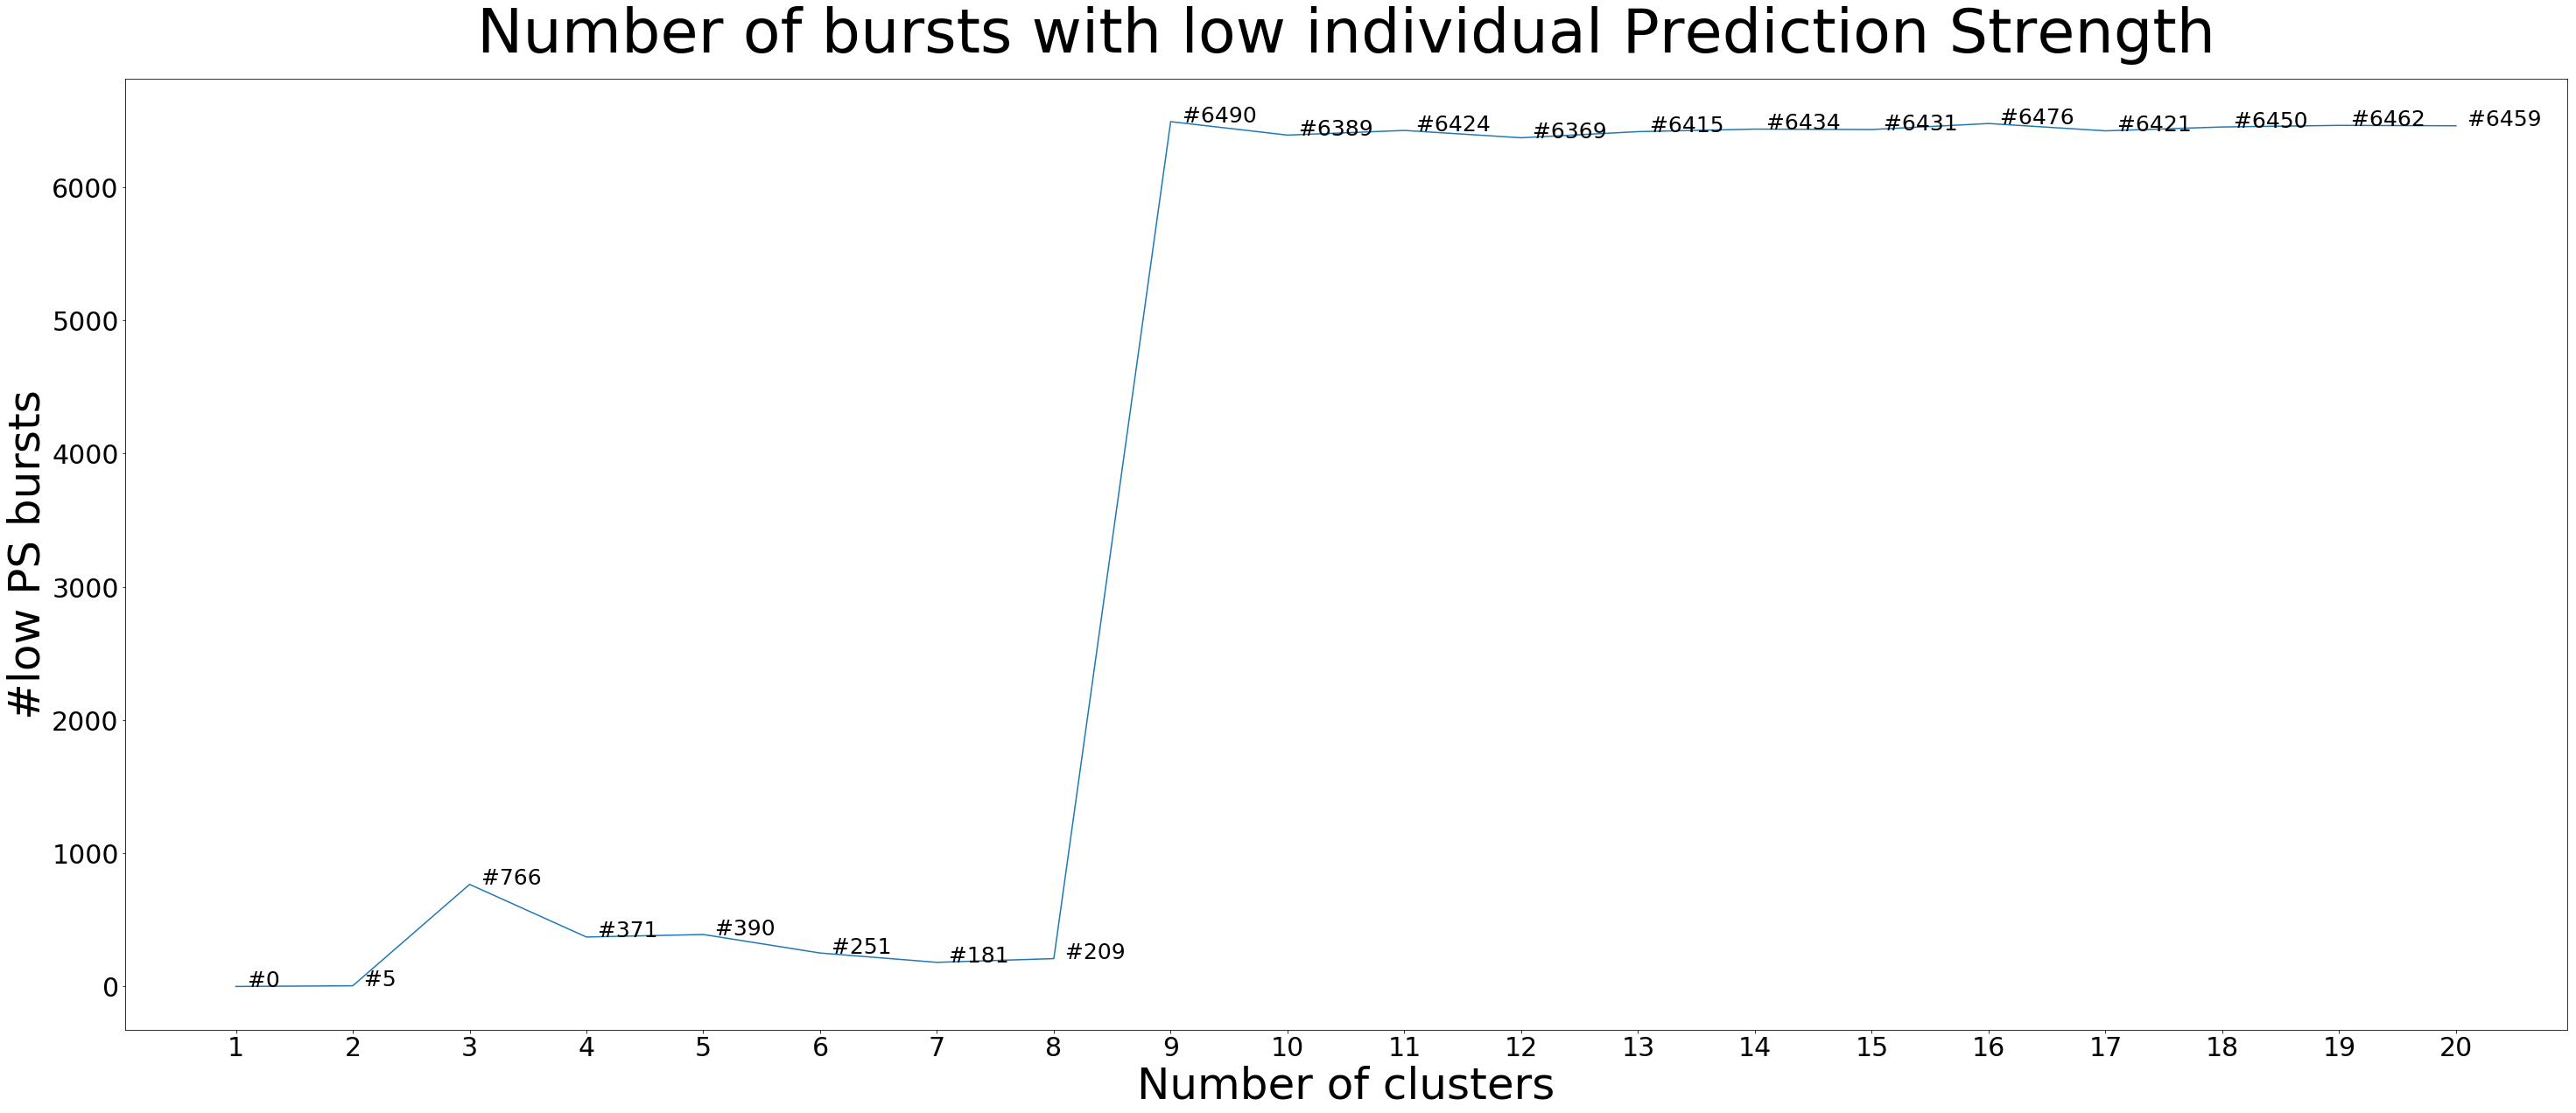

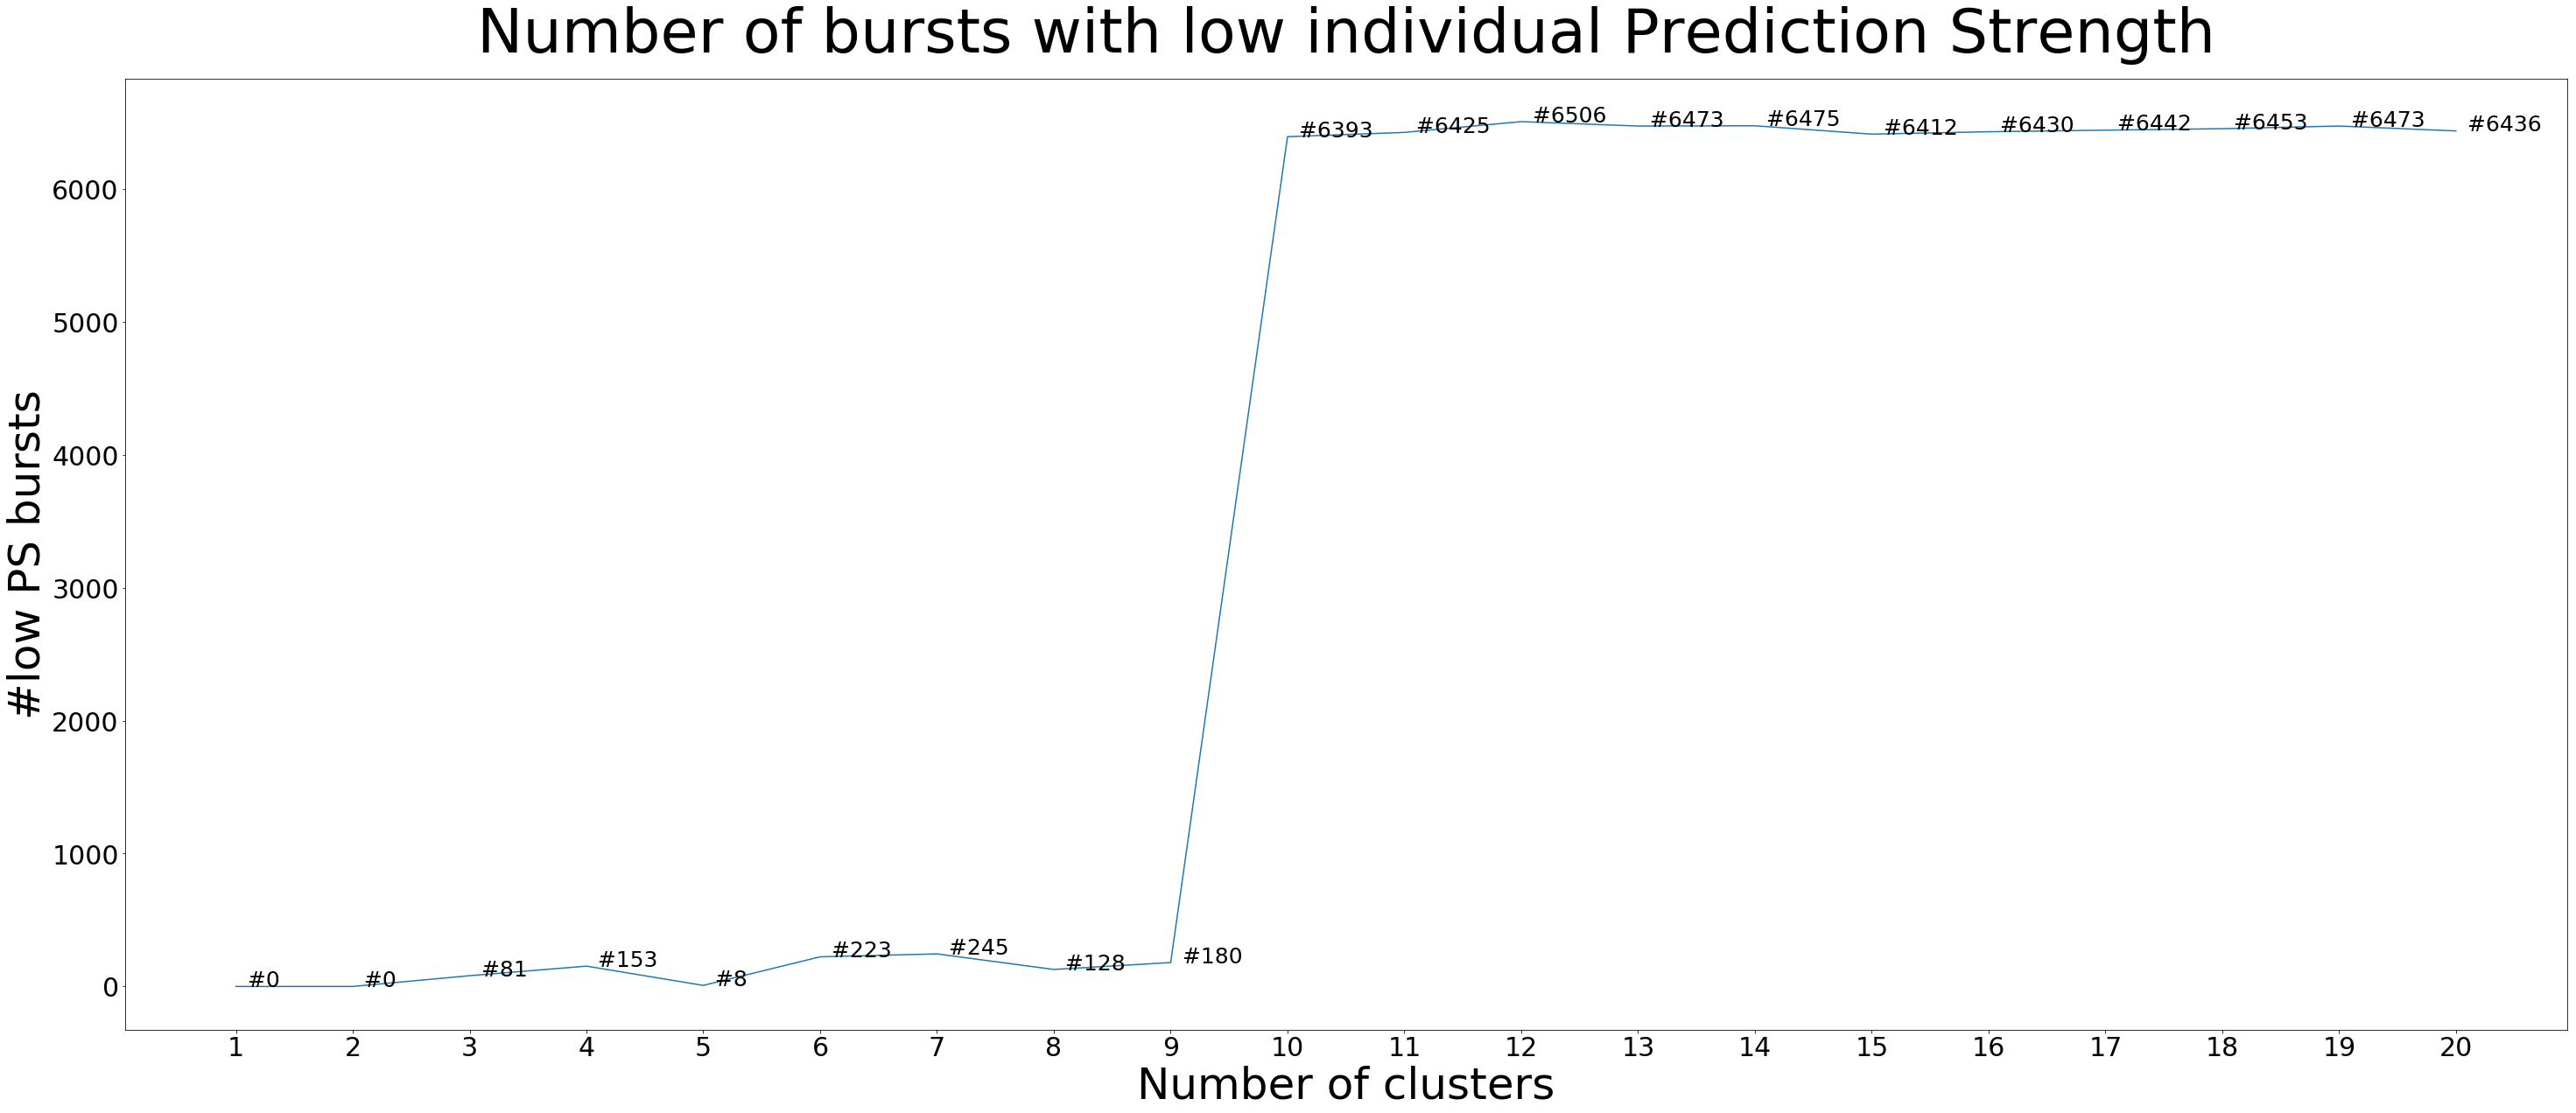

In [57]:
n_folds = 2
threshold = 0.95
n_clusters = range(1,21)

for i in range(n_folds):
    fold_i_low_bursts,fold_i_low_burst_sizes,fold_i_low_burst_sizes_prop = get_low_individual_ps_bursts(data,[train_folds[i]], [valid_folds[i]], [train_fold_labels_gmm[i]], [valid_fold_labels_gmm[i]] ,[predictions_strengths_cv_gmm_per_sample[i]],threshold = threshold)
    plot_mean_number_of_low_prediction_strength_samples(fold_i_low_burst_sizes, n_clusters = n_clusters)

### plot bursts with low and high prediction strength for each cluster 

In [58]:
threshold = 0.95
k_low_individual_ps_bursts_gmm, k_low_individual_ps_cv_sizes_gmm,k_low_individual_ps_cv_sizes_prop_gmm = get_low_individual_ps_bursts(data,train_folds, valid_folds, train_fold_labels_gmm, valid_fold_labels_gmm ,predictions_strengths_cv_gmm_per_sample,threshold = threshold)
k_high_ps_bursts_folds_gmm, high_ps_bursts_fold_labels_gmm, k_low_ps_bursts_folds_gmm, low_ps_bursts_fold_labels_gmm = get_low_and_high_ps_bursts_fold_with_labels(valid_folds,valid_fold_labels_gmm,k_low_individual_ps_bursts_gmm,k_low_individual_ps_cv_sizes_gmm, n_folds = 2,n_clusters = range(1,21))

In [165]:
len(np.unique(high_ps_bursts_fold_labels[0][10]))

9

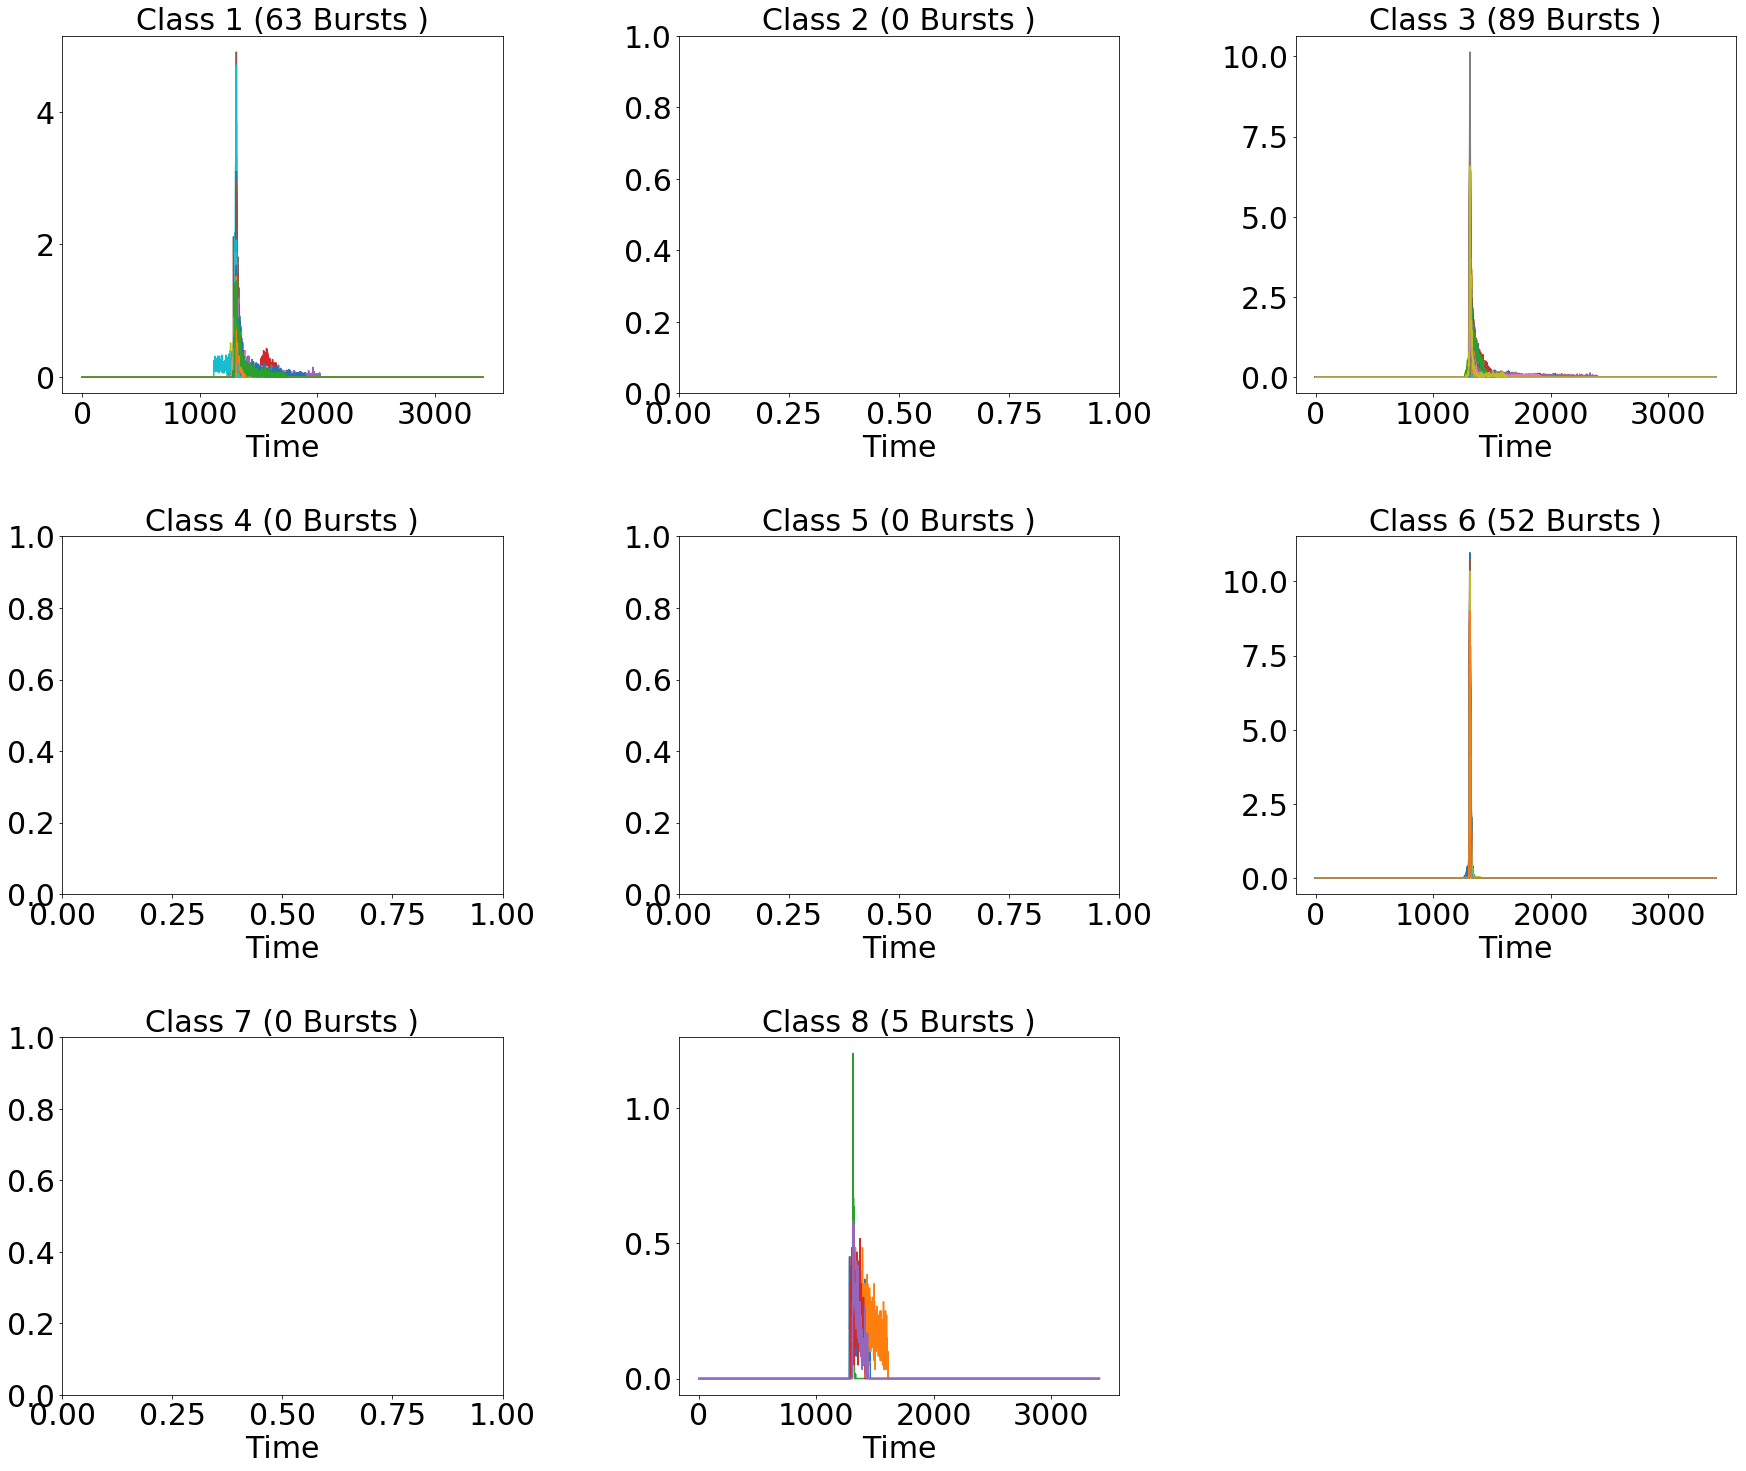

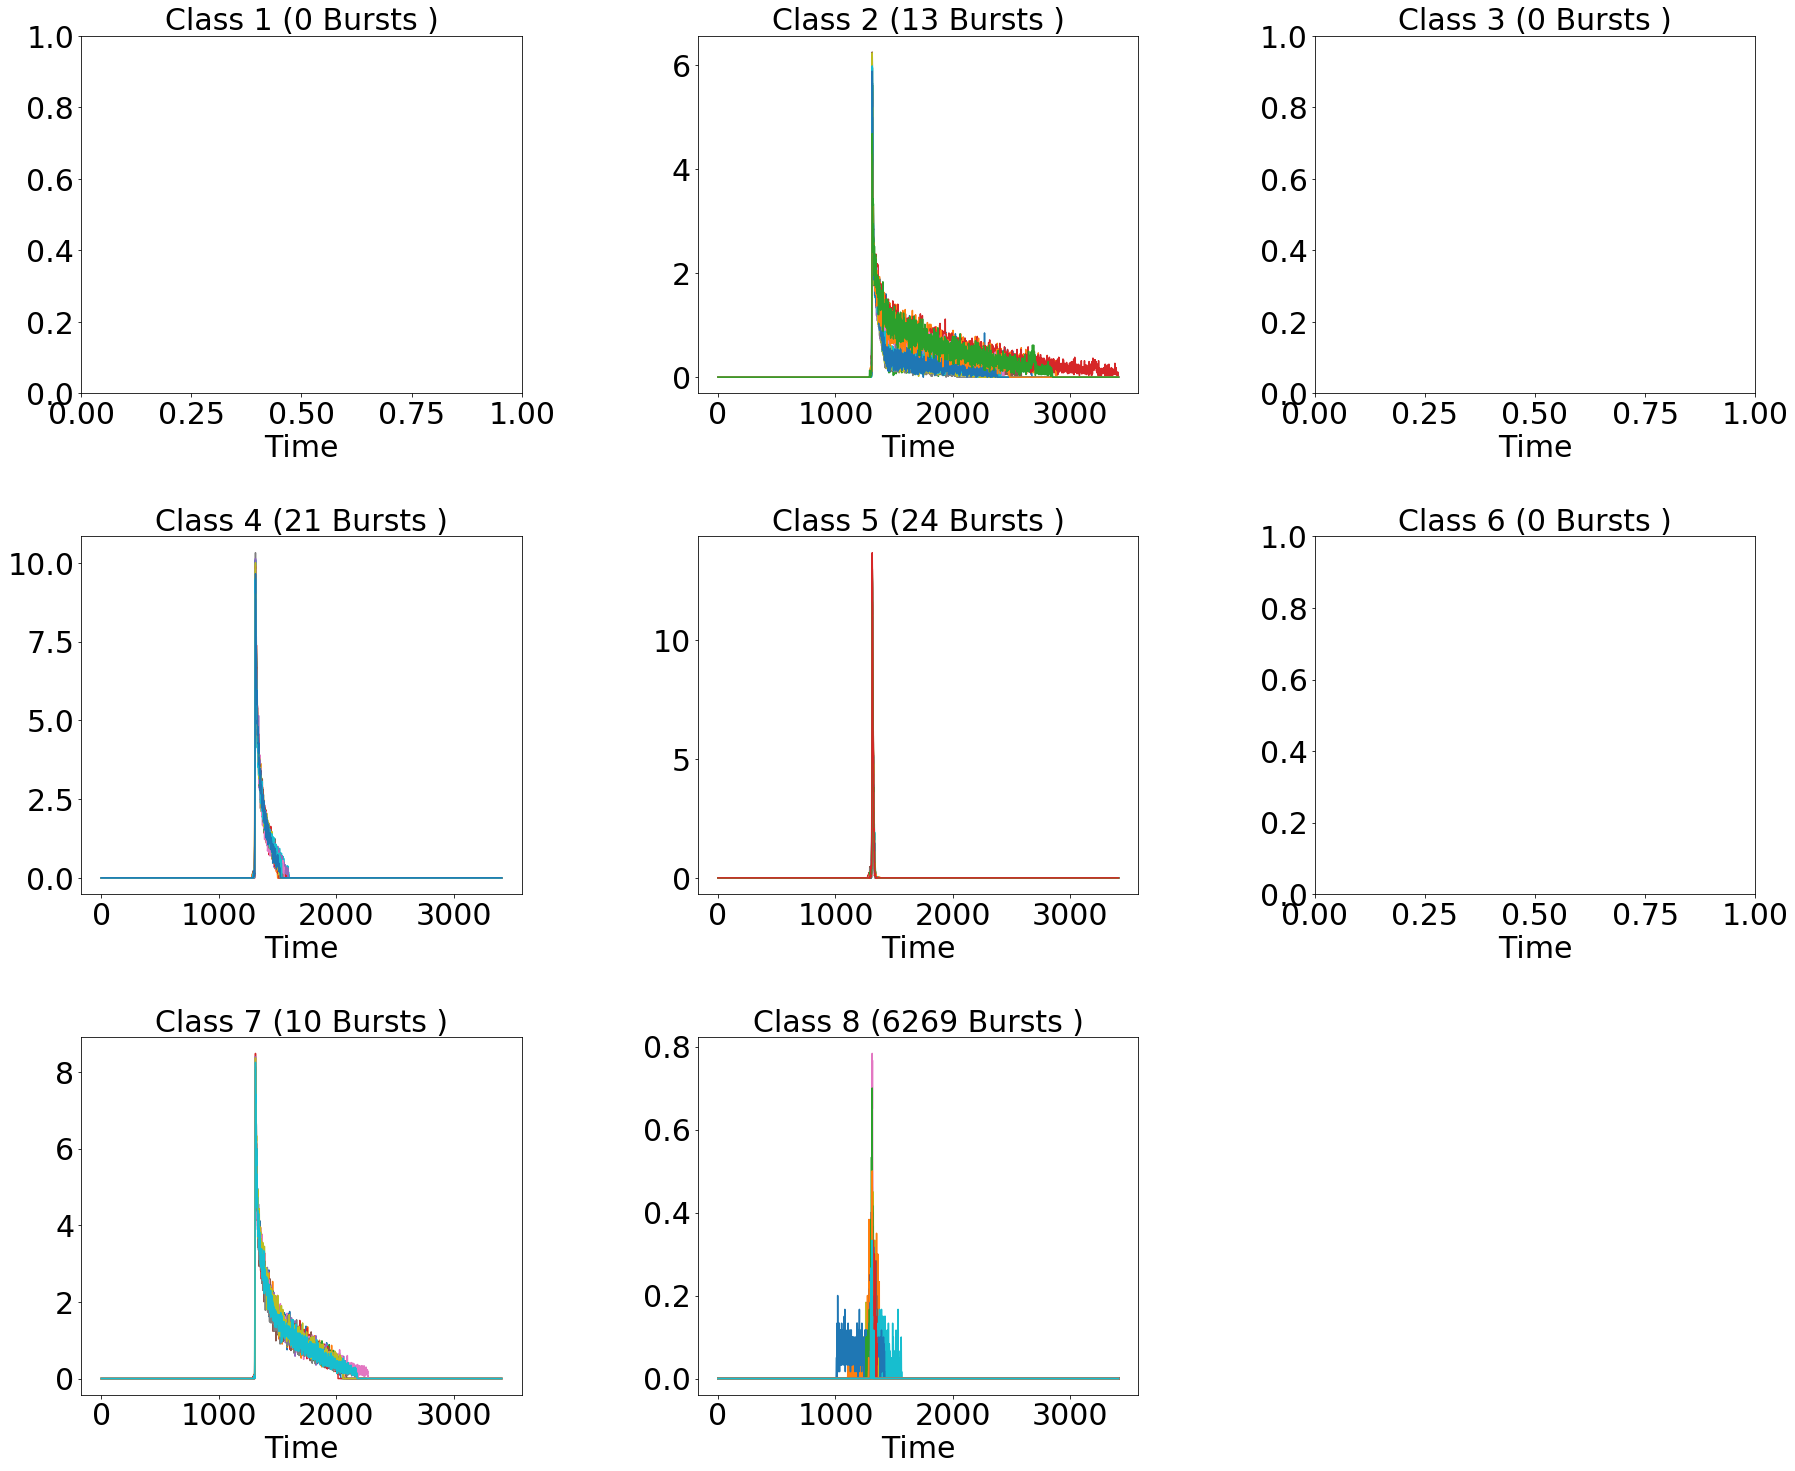

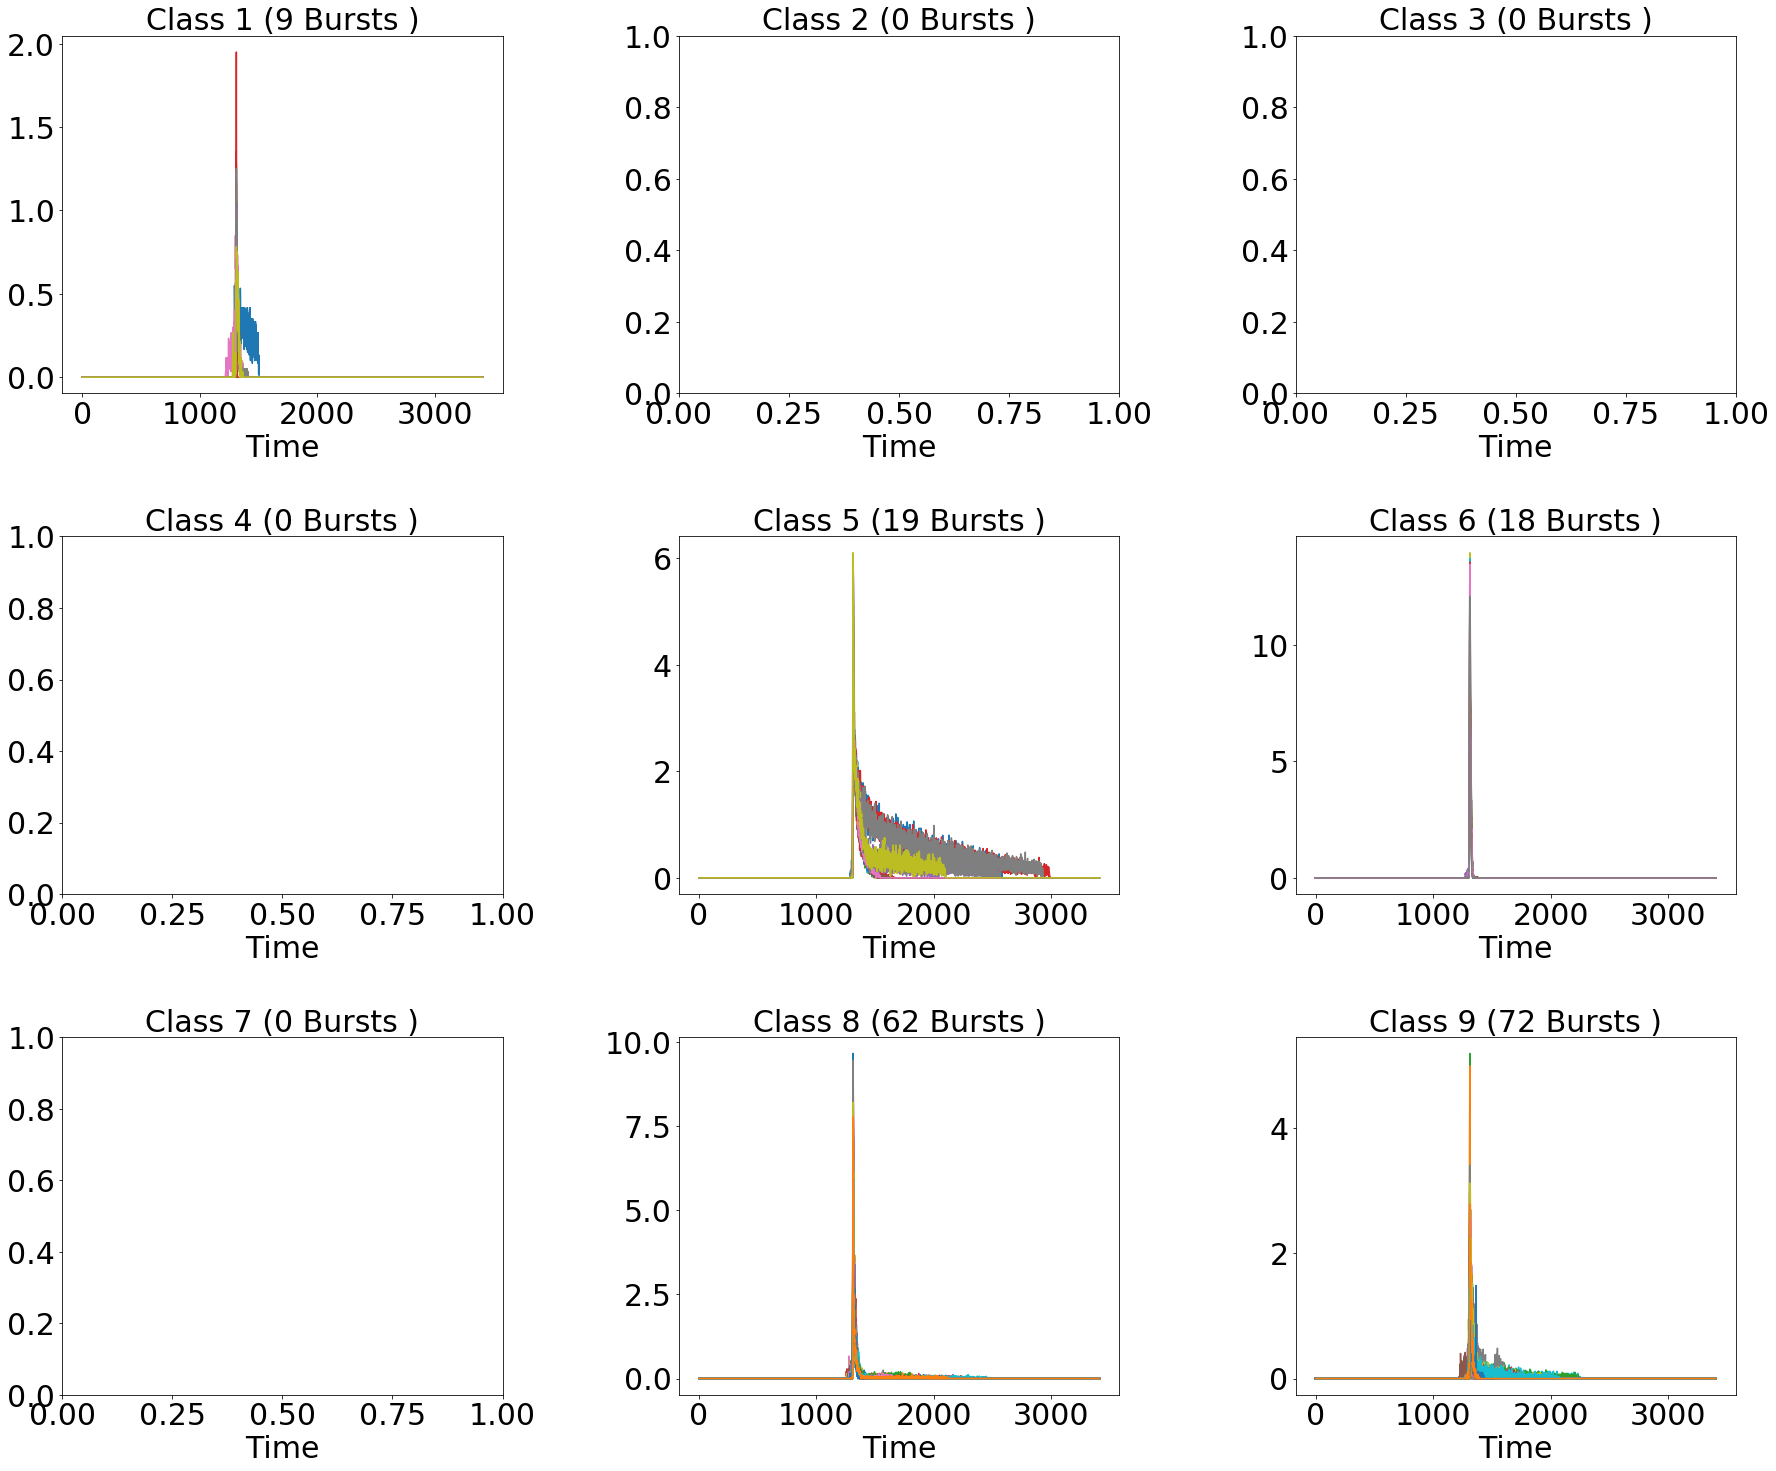

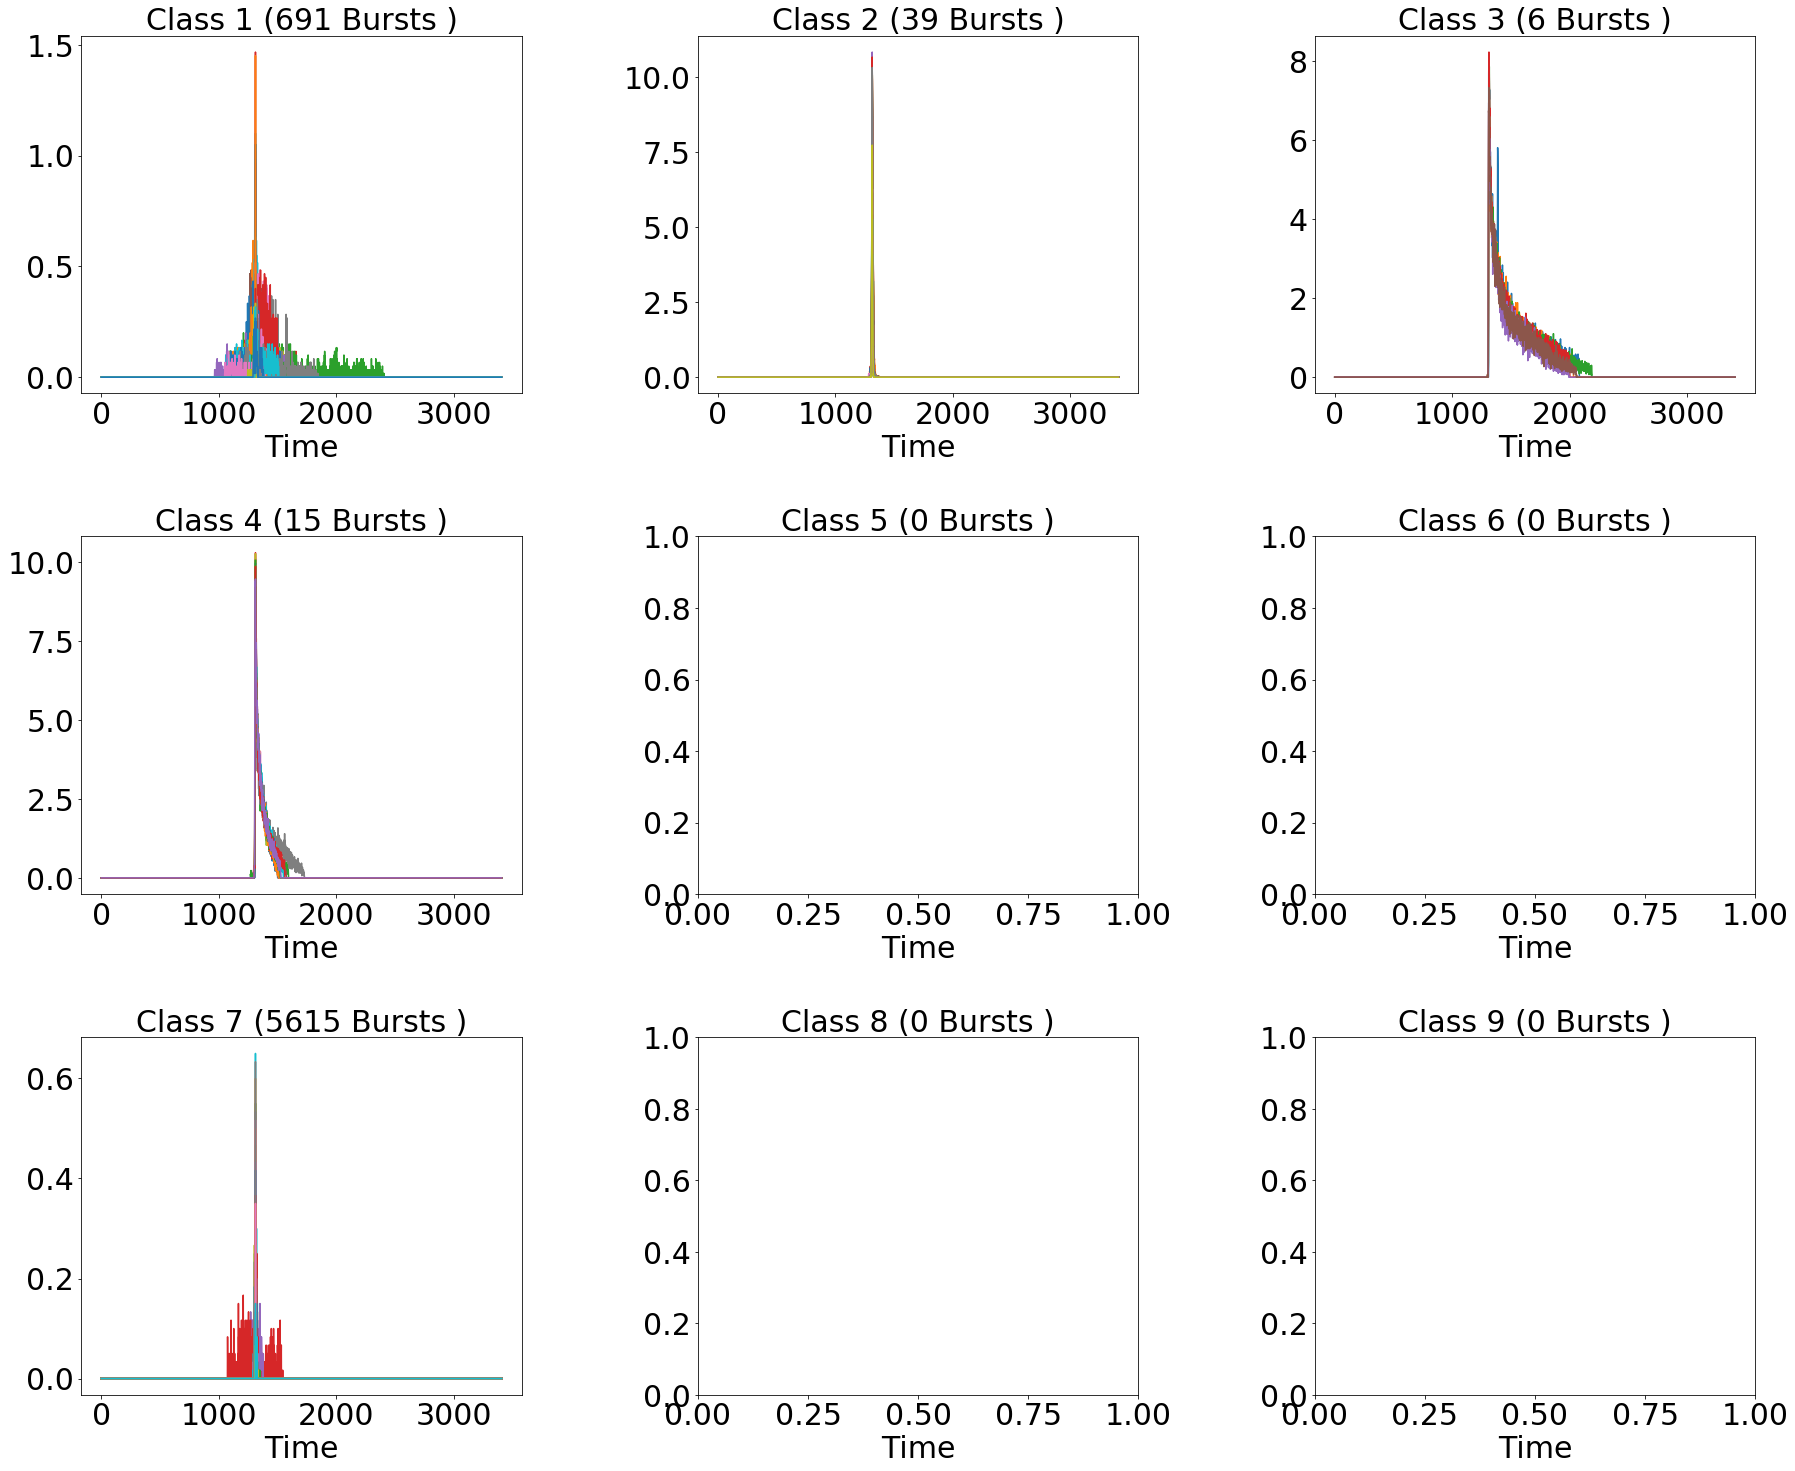

In [59]:
k_clusters_fold = [8,9]
for i in range(2):
    k_clusters = k_clusters_fold[i]
    plot_cluster_examples(data[k_low_ps_bursts_folds_gmm[k_clusters][i]],low_ps_bursts_fold_labels_gmm[i][k_clusters-1], k_clusters)
    plot_cluster_examples(data[k_high_ps_bursts_folds_gmm[k_clusters][i]],high_ps_bursts_fold_labels_gmm[i][k_clusters-1], k_clusters)

## Mean cluster Prediction Strength for clustering with k clusters

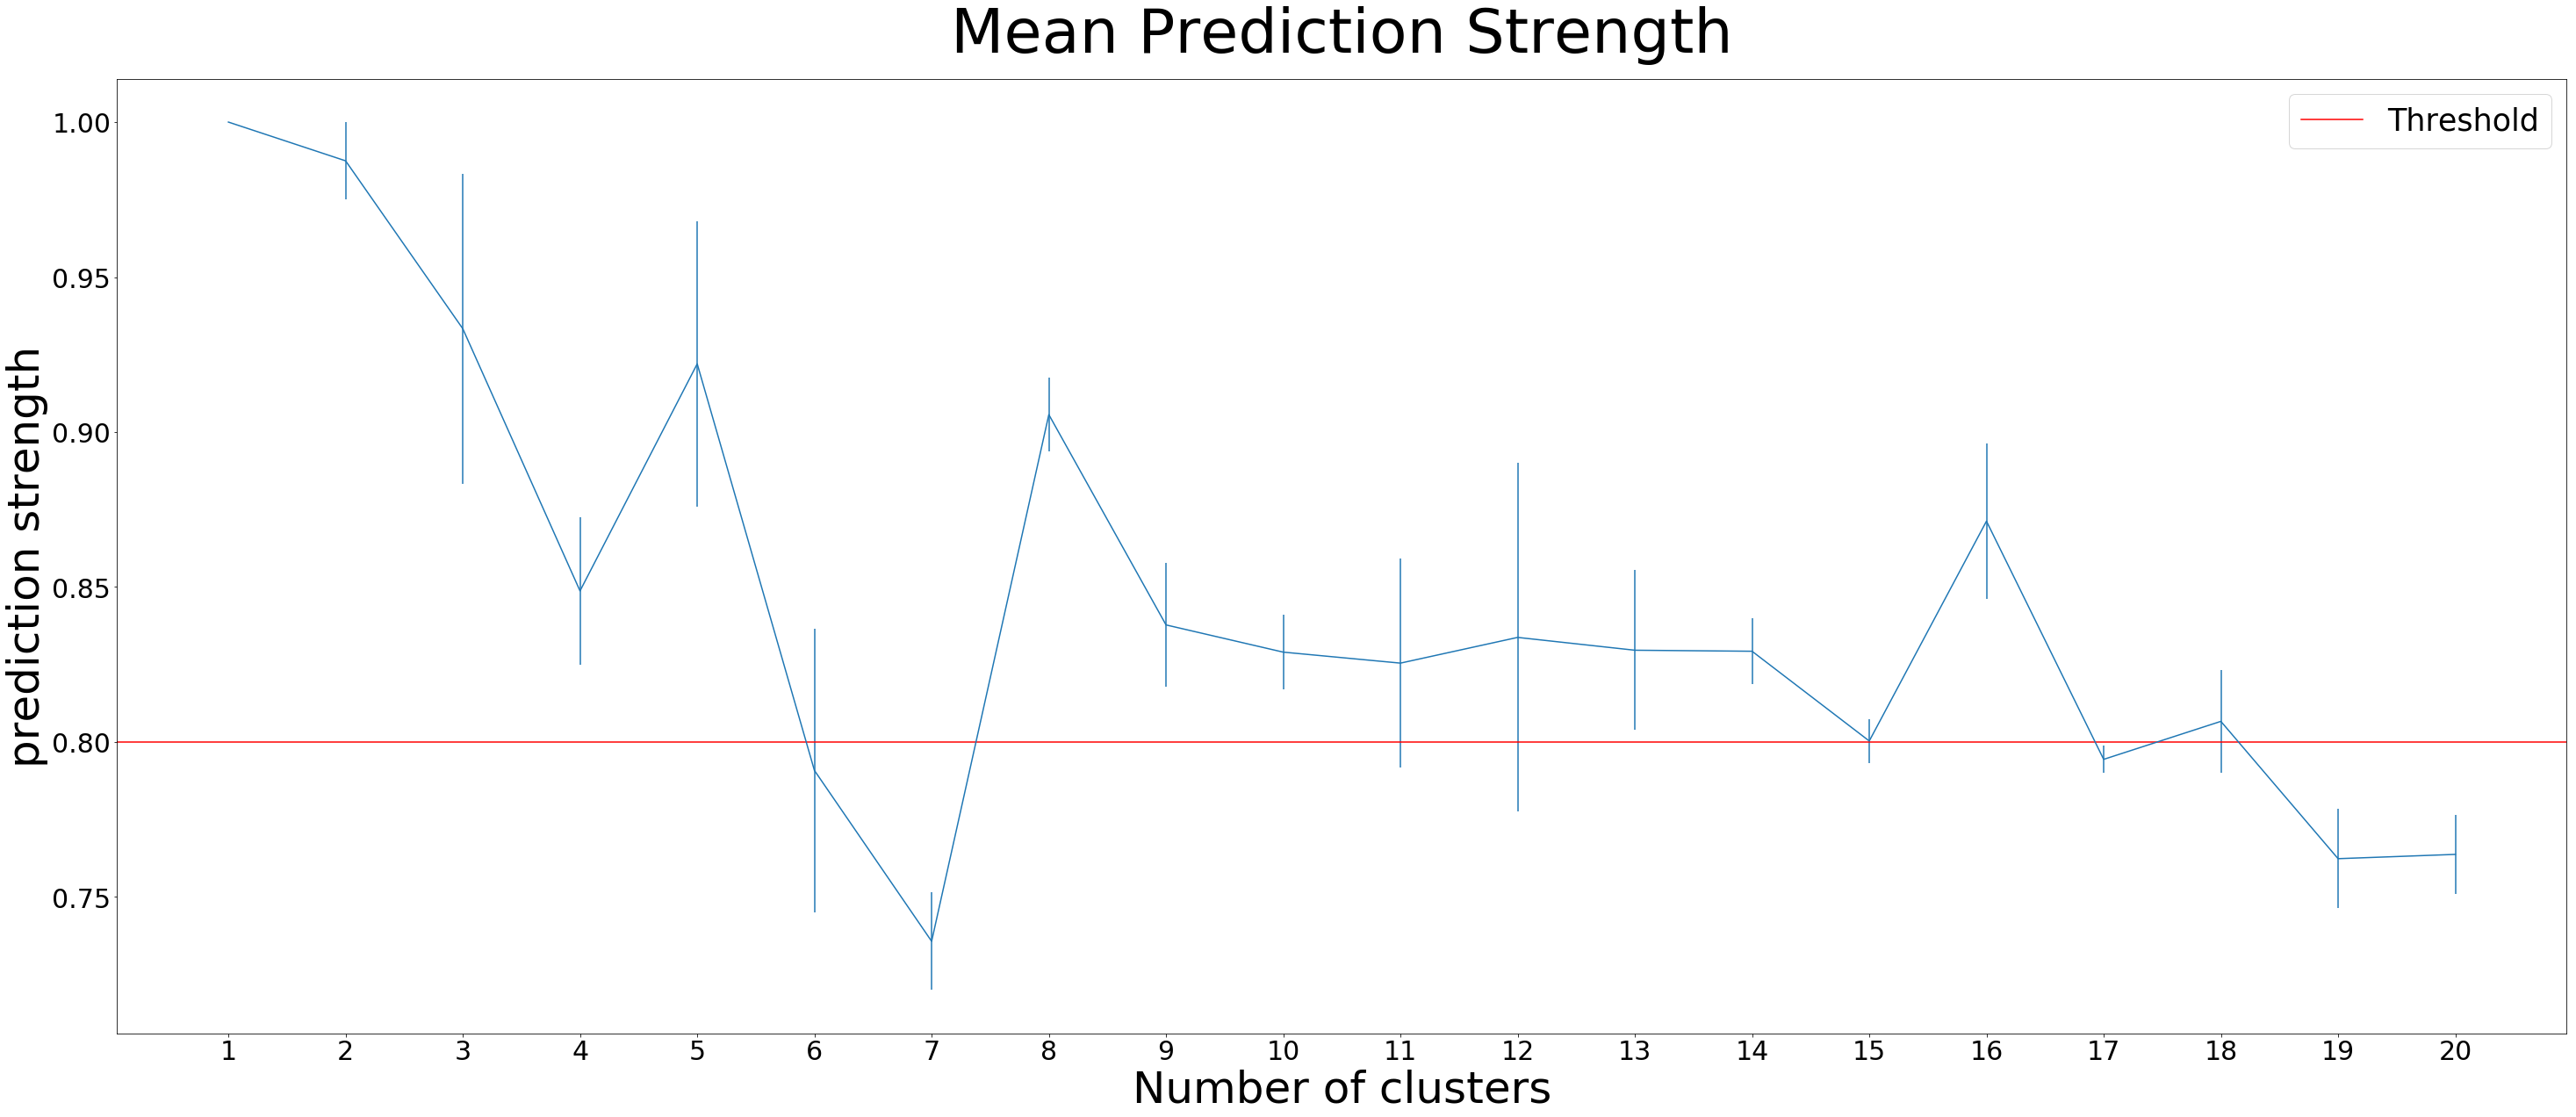

In [85]:
plot_mean_prediction_strengths(k_predictions_strength_cv_gmm)

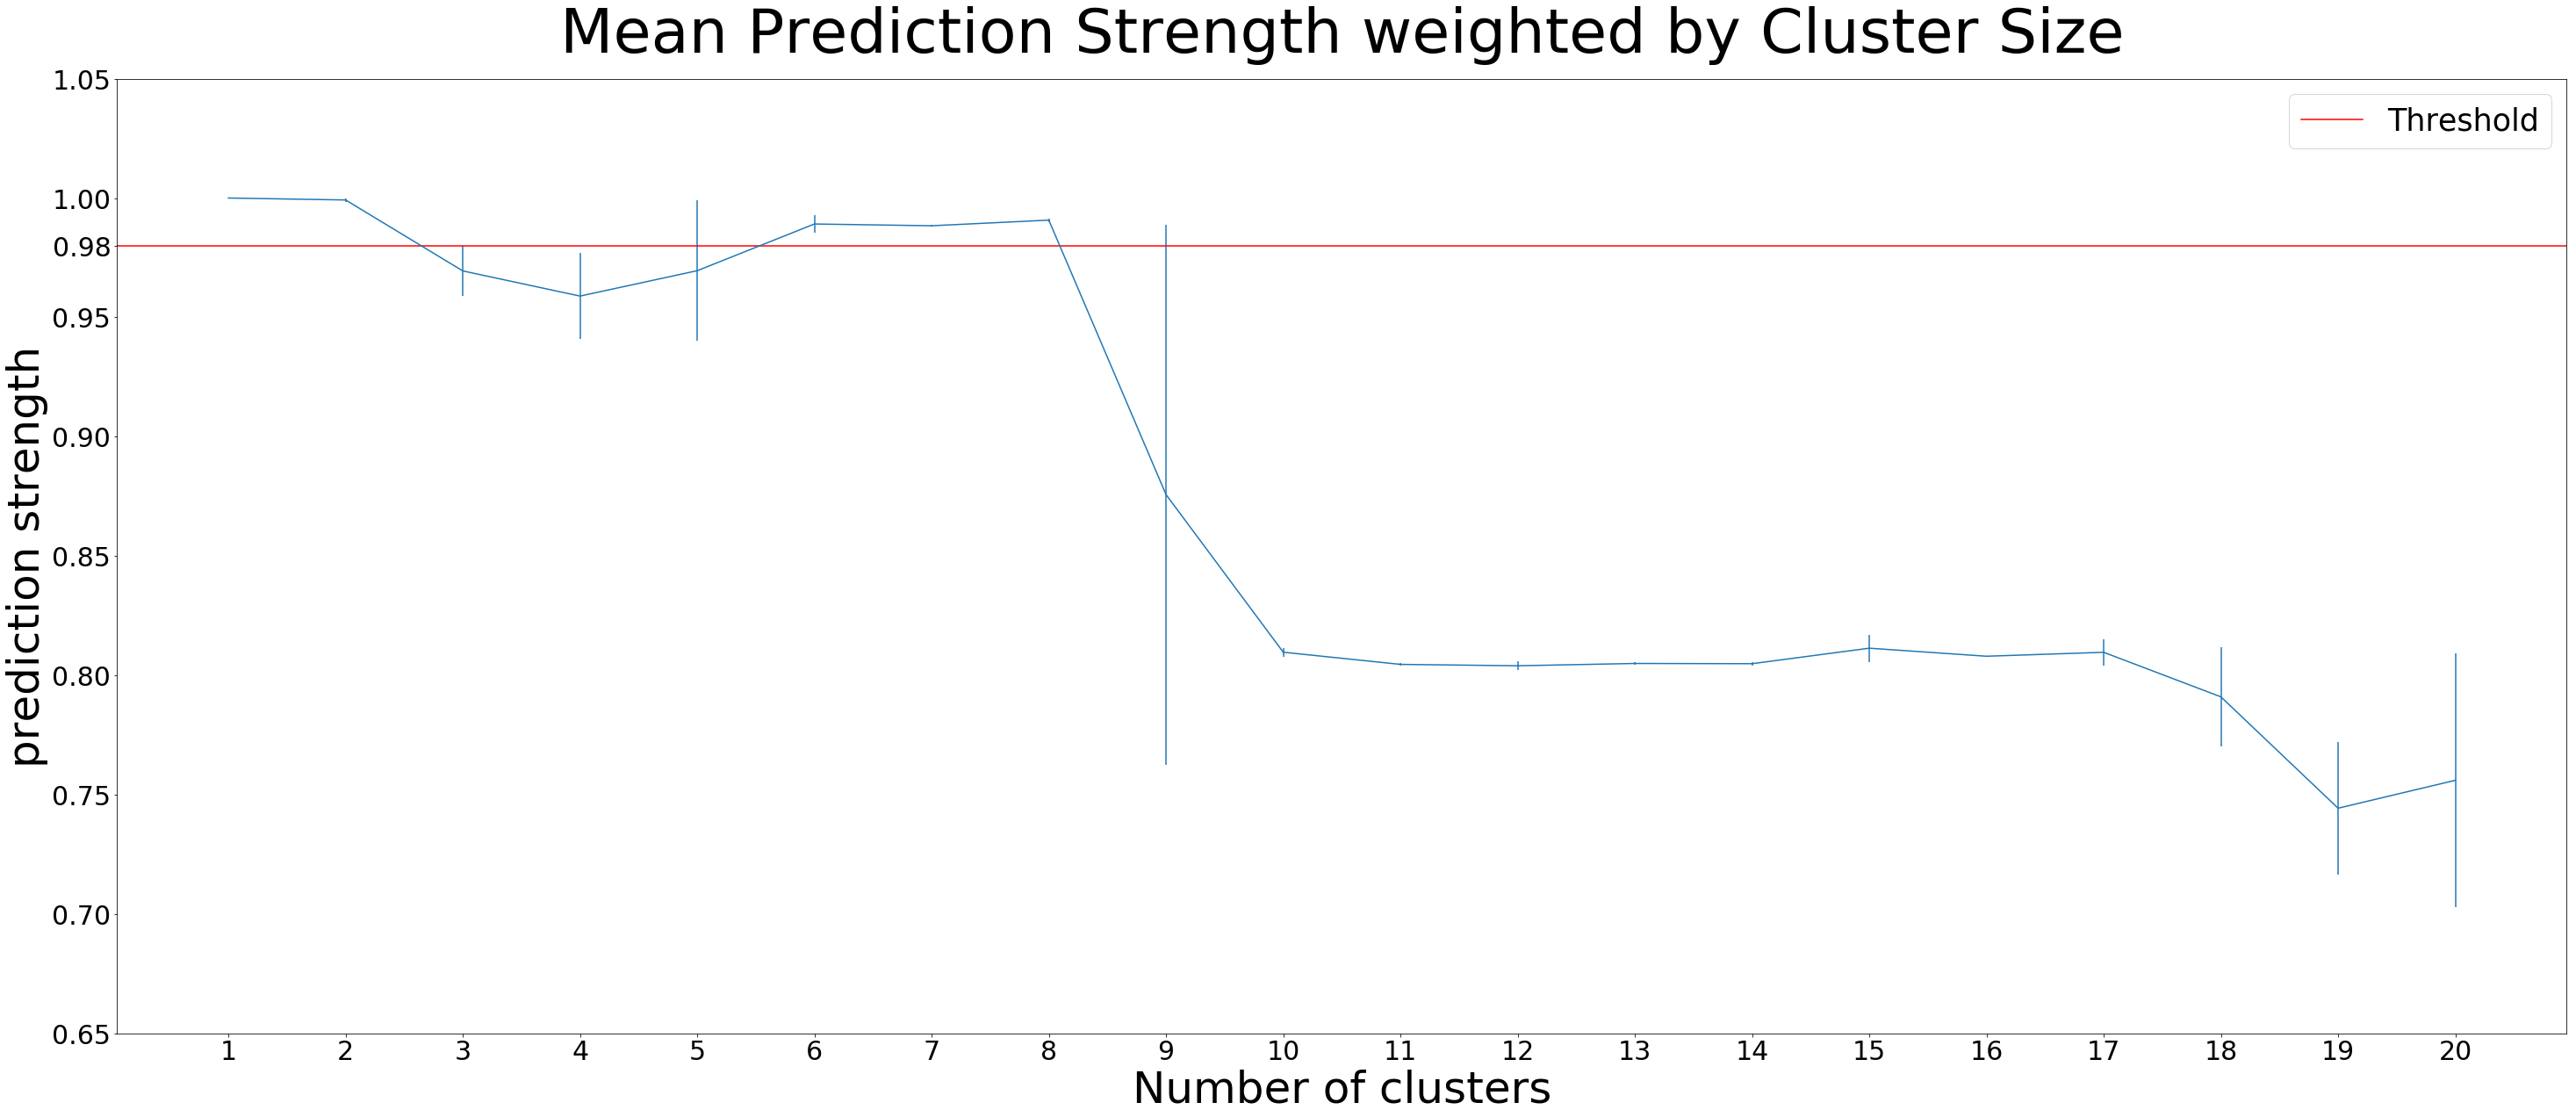

In [88]:
plot_proportion_weighted_mean_prediction_strengths(k_predictions_strength_cv_gmm, valid_cluster_size_gmm,n_folds = 1, threshold = 0.98)